#Import and Data Clean

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29103 sha256=419fd307009da68111fb16db6ea48933d2149cffe668f4d6e71e9eb726e4e3b5
  Stored in directory: /root/.cache/pip/wheels/6a/76/03/7f785aaa50b9c6ec7e3fd105a62c1b2c45a034512d51e024a9
Successfully built ta


In [ ]:
import os
import numpy as np
import ta
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math
import time
import tensorflow as tf
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
from keras.utils.vis_utils import plot_model
from pickle import load
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import statsmodels.api as sm
from math import sqrt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from pickle import dump
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
nltk.download('vader_lexicon')
import shutil

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
all_tweets = pd.read_csv('/content/drive/MyDrive/ST456 Project/Dataset/stock_tweets.csv')
all_stocks = pd.read_csv('/content/drive/MyDrive/ST456 Project/Dataset/stock_yfinance_data.csv')


In [ ]:
def clean_data(tweet_data, stock_data, stock_name):
  stock_name = stock_name
  df = tweet_data[tweet_data['Stock Name'] == stock_name]

  sent_df = df.copy()
  sent_df["sentiment_score"] = ''
  sent_df["Negative"] = ''
  sent_df["Neutral"] = ''
  sent_df["Positive"] = ''

  %time
  sentiment_analyzer = SentimentIntensityAnalyzer()
  for indx, row in sent_df.T.iteritems():
      try:
          sentence_i = unicodedata.normalize('NFKD', sent_df.loc[indx, 'Tweet'])
          sentence_sentiment = sentiment_analyzer.polarity_scores(sentence_i)
          sent_df.at[indx, 'sentiment_score'] = sentence_sentiment['compound']
          sent_df.at[indx, 'Negative'] = sentence_sentiment['neg']
          sent_df.at[indx, 'Neutral'] = sentence_sentiment['neu']
          sent_df.at[indx, 'Positive'] = sentence_sentiment['pos']
      except TypeError:
          print (sent_df.loc[indx, 'Tweet'])
          print (indx)
          break

  sent_df['Date'] = pd.to_datetime(sent_df['Date'])
  sent_df['Date'] = sent_df['Date'].dt.date
  sent_df = sent_df.drop(columns=['Negative', 'Positive', 'Neutral', 'Company Name'])
  twitter_df = sent_df.groupby(['Date']).mean()

  twitter_df = twitter_df.reset_index()

  all_stocks['Date'] = pd.to_datetime(all_stocks['Date'])
  all_stocks['Date'] = all_stocks['Date'].dt.date

  stock_df = all_stocks[all_stocks['Stock Name'] == stock_name]
  final_df = stock_df.merge(twitter_df, on = ['Date'], how = 'left')
  final_df = final_df.loc[:,['Date', 'Stock Name', 'sentiment_score', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
  final_df.reset_index(inplace = True, drop = True)

  cols = 0
  rows = 0 

  fig, ax = plt.subplots(1, 1, figsize = (20,8), tight_layout = True)

  for tic in list(final_df['Stock Name'].unique()):
      ax.plot(final_df.loc[final_df['Stock Name'] == tic, 'Date'] ,final_df.loc[final_df['Stock Name'] == tic,'Close'], color='#008B8B')
      ax.set(xlabel='Date', ylabel='USD', title=f'{tic} Stock Price')
      ax.xaxis.set_major_formatter(DateFormatter('%Y'))

  plt.show()

  def get_tech_ind(data):

    # Adding Simple Moving Average
    data['MA7'] = ta.trend.sma_indicator(close = data.iloc[:,6], window = 7)
    data['MA20'] = ta.trend.sma_indicator(close = data.iloc[:,6], window = 20)
    
    # Adding MACD
    data['MACD'] = ta.trend.macd(close = data.iloc[:,6])

    # Adding Rate of Change
    data['ROC'] = ta.momentum.roc(close = data.iloc[:,6], window = 12)

    # Adding Exponential Moving Average
    data['EMA'] = ta.trend.ema_indicator(close = data.iloc[:,6])

    # Adding Bollinger Bands
    data['Bollinger_Bands'] = ta.volatility.BollingerBands(close = data.iloc[:,6]).bollinger_mavg()

    # Adding LogMomentum
    data['Log_Momentum'] = np.log(data.iloc[:,6]-1)

    return data

  tech_df = pd.DataFrame()

  

  df_1 = final_df[final_df['Stock Name'] == stock_name]
  df_2 = get_tech_ind(df_1)
  df_2 = df_2.iloc[25:,].reset_index(drop=True)
  tech_df = pd.concat([tech_df,df_2], axis = 0)

  tech_df.iloc[:, 1:] = pd.concat([tech_df.iloc[:, 1:].ffill()])
  
  cols = 0
  rows = 0 

  fig, ax = plt.subplots(1, 1, figsize = (20,8), tight_layout = True);

  for tic in list(tech_df['Stock Name'].unique()):
    
      ax.plot(tech_df.loc[tech_df['Stock Name'] == tic, 'Date'] ,tech_df.loc[tech_df['Stock Name'] == tic,'MA7'], color='g', linestyle='--', label='Moving Average (7 days)');
      ax.plot(tech_df.loc[tech_df['Stock Name'] == tic, 'Date'] ,tech_df.loc[tech_df['Stock Name'] == tic,'Close'], color='#6A5ACD', label='Closing Price');
      ax.plot(tech_df.loc[tech_df['Stock Name'] == tic, 'Date'] ,tech_df.loc[tech_df['Stock Name'] == tic,'MA20'], color='r', linestyle='-.', label='Moving Average (20 days)');
      ax.set(xlabel='Date', ylabel='USD', title=f'{tic} Technical Indicators');
      ax.xaxis.set_major_formatter(DateFormatter('%Y'));
      ax.legend();


  plt.show();

  tech_df = tech_df.drop(['Stock Name'], axis = 1)
  date_col = tech_df['Date']
  tech_df = tech_df.set_index('Date')
  tech_df = tech_df.sort_values('Date')
  tech_df.reset_index(inplace=True,drop=True)

  X = tech_df.drop(['Adj Close'], axis = 1)
  y = pd.DataFrame(tech_df['Adj Close'])

  return X, y, date_col


def data_preprocess(X, y, days, predict):
  X_scaler = MinMaxScaler()
  y_scaler = MinMaxScaler()
  X_scaled_df = X_scaler.fit_transform(X)
  y_scaled_df = y_scaler.fit_transform(y)
  print(X_scaled_df.shape)

  days_to_consider = days
  n_features = X_scaled_df.shape[1]
  days_to_predict = predict

  def x_y_predictions(x_data, y_data):
    X_data = []
    Y_data = []
    YC_data = []

    for i in range(0,len(x_data),1):
      X = x_data[i: i + days_to_consider][:,:]
      y = y_data[i + days_to_consider : i + days_to_consider + days_to_predict][:,0]
      yc = y_data[i: i + days_to_consider][:,:]
      if len(X) == days_to_consider and len(y) == days_to_predict:
        X_data.append(X)
        Y_data.append(y)
        YC_data.append(yc)

    return np.array(X_data), np.array(Y_data), np.array(YC_data)

  X, y, yc = x_y_predictions(X_scaled_df, y_scaled_df)

  def split_train_test(data):
    train_size = round(len(data) * 0.85)
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

  X_train, X_test = split_train_test(X)
  y_train, y_test = split_train_test(y)
  yc_train, yc_test = split_train_test(yc)
  print('X_train shape', X_train.shape)
  print('y_train shape', y_train.shape)
  print('yc_train shape', yc_train.shape)
  print('X_test shape', X_test.shape)
  print('y_test shape', y_test.shape)
  print('yc_test shape', yc_test.shape)

  input_dim = X_train.shape[1] 
  feature_size = X_train.shape[2] 
  output_dim = y_train.shape[1]

  print('Input dimension', input_dim)
  print('Feature dimension', feature_size)
  print('Output dimension', output_dim)

  return X_train, y_train, yc_train, X_test, y_test, y_scaler, input_dim, feature_size, output_dim

#LSTM Models - Shallow and Deep
Reference for Coding: 
1. Lecture 7 - Week 8 (Seminar Exercises - Activity 1 and 2)
2. Zhang, Lipton, Li, and Smola, Dive into Deep Learning, Chapter 8: Recurrent Neural
Networks https://d2l.ai/chapter_recurrent-neural-networks/index.html



In [ ]:
def make_LSTM_model(input_dim, feature_size, output_dim):
   model = tf.keras.Sequential([LSTM(units = 64, return_sequences = True, 
                                    input_shape=(input_dim, feature_size),
                                    kernel_initializer = 'glorot_uniform', 
                                    activity_regularizer=tf.keras.regularizers.l1(0.01),
                                    activation = 'tanh',
                                    recurrent_dropout = (0.3)),
                                    Flatten(),
                                    Dense(1, activation = 'sigmoid')])
   return model

In [ ]:
def make_deep_LSTM_model(input_dim, feature_size, output_dim):
   model = tf.keras.Sequential([LSTM(units = 512, return_sequences = True, 
                                    input_shape=(input_dim, feature_size),
                                    kernel_initializer = 'glorot_uniform', 
                                    activity_regularizer=tf.keras.regularizers.l1(0.01),
                                    activation = 'tanh',
                                    recurrent_dropout = (0.3)),
                                LSTM(units = 256, return_sequences = True, 
                                    input_shape=(input_dim, feature_size),
                                    kernel_initializer = 'glorot_uniform', 
                                    activity_regularizer=tf.keras.regularizers.l1(0.01),
                                    activation = 'tanh',
                                    recurrent_dropout = (0.3)),
                                Dense(128, activation = 'tanh'),
                                Dense(64, activation = 'tanh'),
                                Dense(32, activation = 'tanh'),
                                Dense(16, activation = 'tanh'),
                                Flatten(),
                                Dense(1, activation = 'sigmoid')])
   return model

# LSTM Prediction Model Results
The model was tested on the following stocks: 
'TSLA', 'TSM', 'AAPL', 'PG', 'AMZN', 'MSFT', 'NIO', 'META', 'AMD', 'NFLX'.

The 4 consecutive days were taken into consideration to train the model. 

The model predicted price of the stock on 5th day.



In [ ]:
#ls = list(all_tweets['Stock Name'].value_counts()[:10].index)
days_to_consider = 4
days_to_predict = 1

# Stock Prediction for 'AMZN'

## Deep LSTM

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


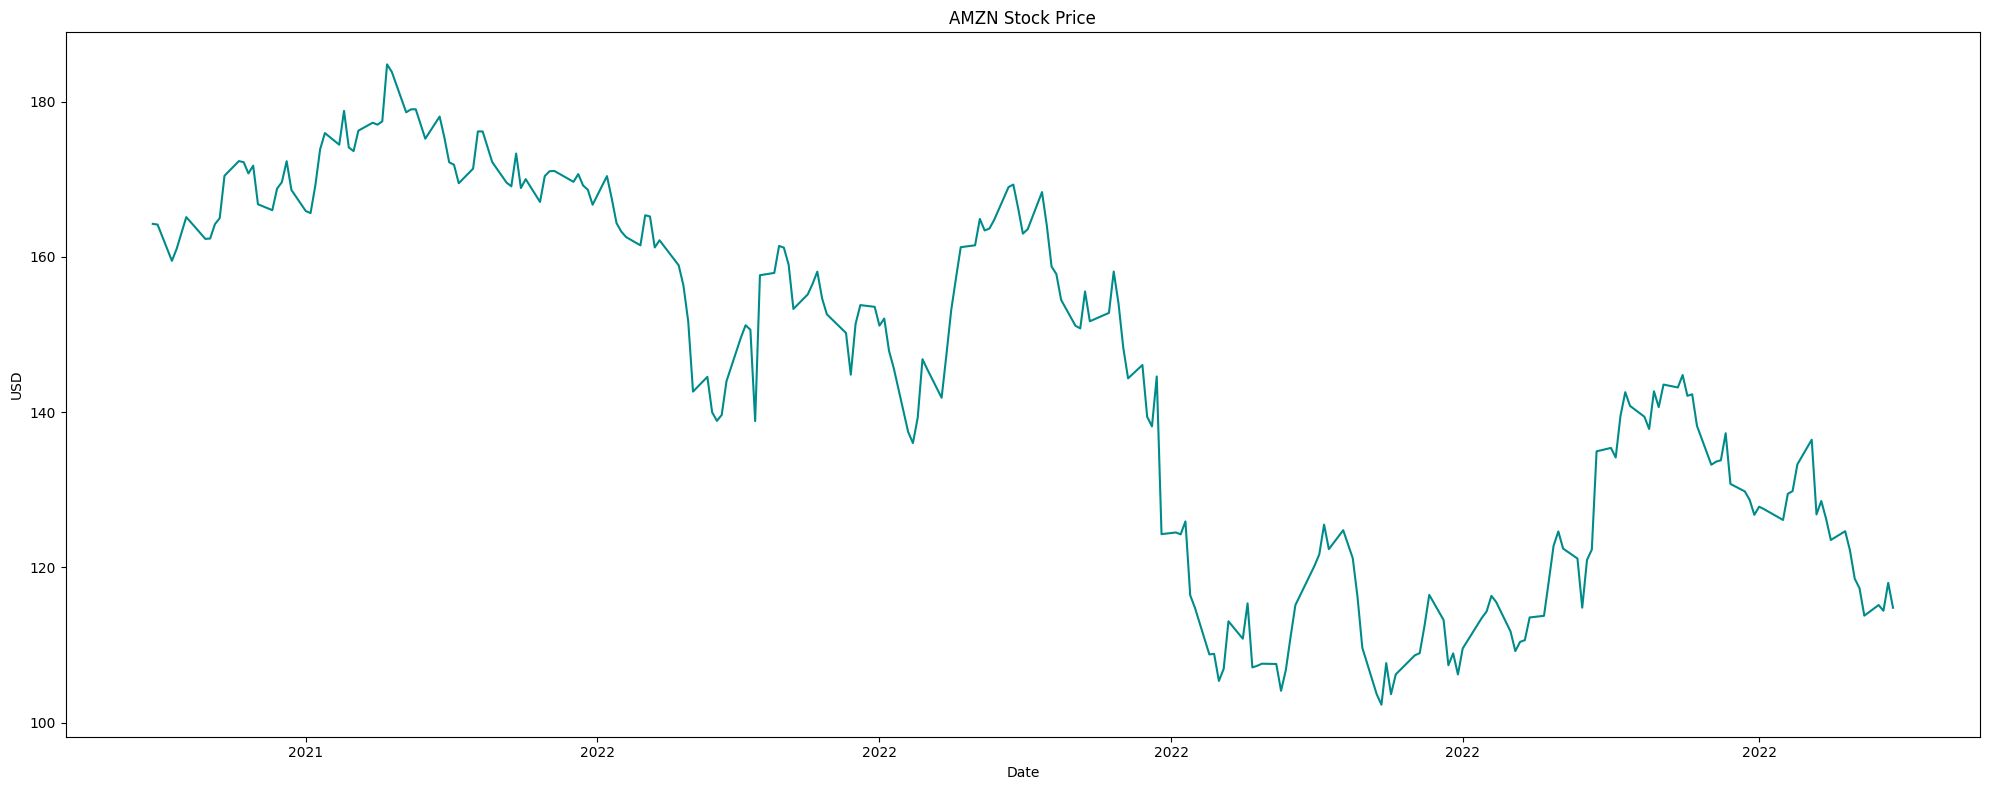

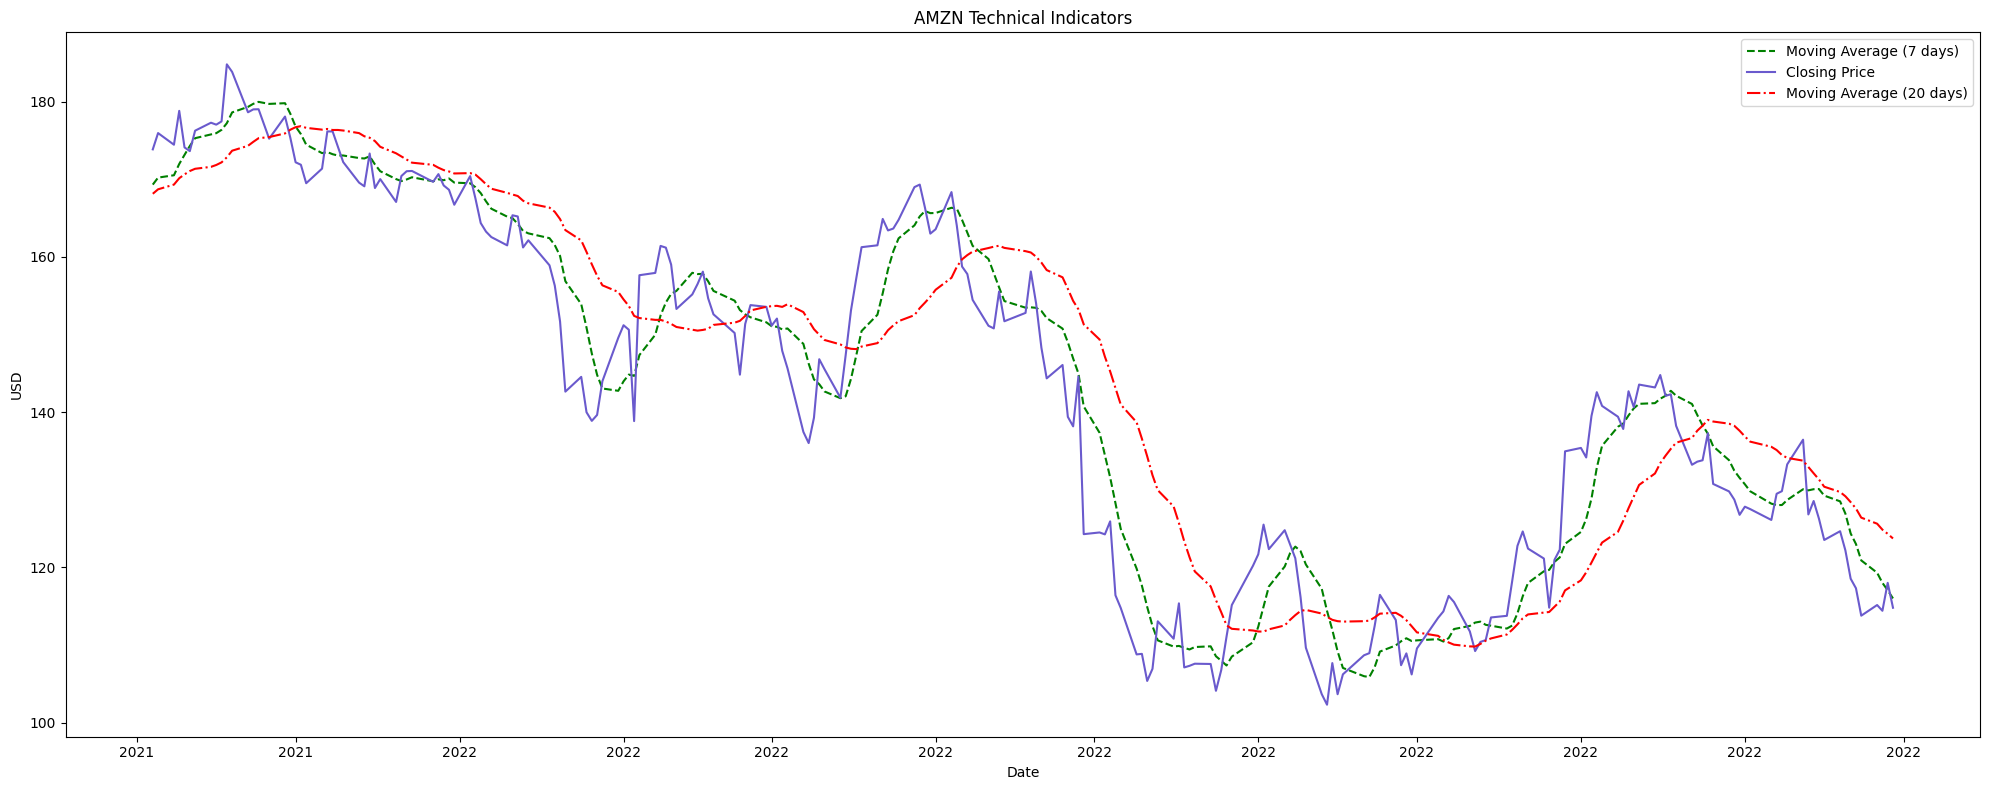

(227, 13)
X_train shape (190, 4, 13)
y_train shape (190, 1)
yc_train shape (190, 4, 1)
X_test shape (33, 4, 13)
y_test shape (33, 1)
yc_test shape (33, 4, 1)
Input dimension 4
Feature dimension 13
Output dimension 1
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 4, 512)            1077248   
                                                                 
 lstm_5 (LSTM)               (None, 4, 256)            787456    
                                                                 
 dense_10 (Dense)            (None, 4, 128)            32896     
                                                                 
 dense_11 (Dense)            (None, 4, 64)             8256      
                                                                 
 dense_12 (Dense)            (None, 4, 32)             2080      
                                    

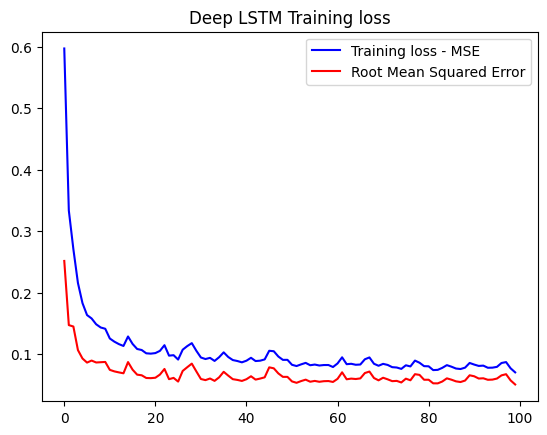

2/2 [==============================] - 1s 15ms/step
the test RMSE for Stock AMZN is 5.464790679201199


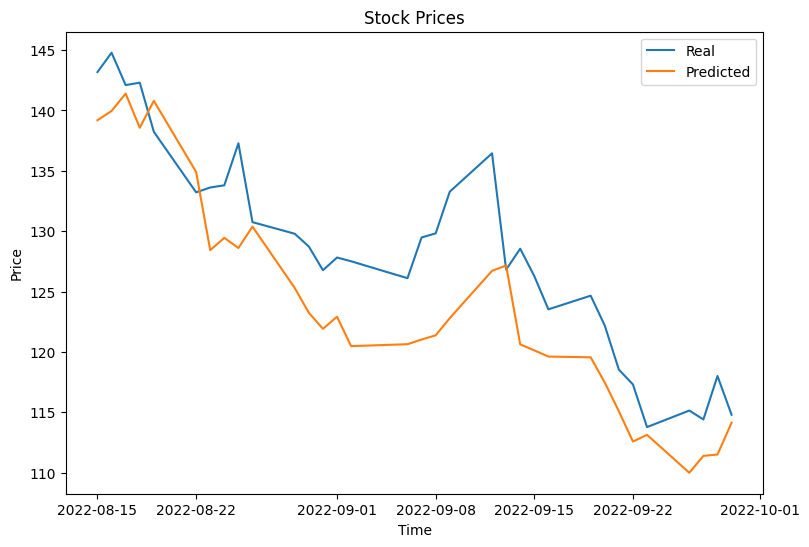

In [ ]:
X, y, date = clean_data(all_tweets, all_stocks, 'AMZN')
X_train, y_train, yc_train, X_test, y_test, y_scaler, input_dim, feature_size, output_dim = data_preprocess(X, y, days_to_consider, days_to_predict)

#
deep_model = make_deep_LSTM_model(input_dim, feature_size, output_dim)
print(deep_model.summary())

#Defining Optimizers
optimizeAdam=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
optimizeRMS=tf.keras.optimizers.RMSprop()
optimizeSGD =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
optimizeSGD1 =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

#Evaluation metric
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
      return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# Compile & Fit
#single_step_model.compile(optimizer=optimizeAdam, loss='mae',metrics=["mae"])
deep_model.compile(optimizer=optimizeAdam, loss=root_mean_squared_error,metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = deep_model.fit(x = X_train, y = y_train ,epochs=100, verbose = 0)
# evaluate the model on the training data
loss, accuracy = deep_model.evaluate(X_train, y_train)
print('Training loss:', loss)

#Plotting the training loss curve against the epochs
def plot_train_history(history, title):
  loss = history.history['loss']
  rmse = history.history['root_mean_squared_error']
  #mse = history.history['mse']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss - MSE')
  plt.plot(epochs, rmse, 'r', label='Root Mean Squared Error')
  #plt.plot(epochs, mse, 'r', label='Mean Squared Error')
  plt.title(title)
  plt.legend()

  plt.show()

plot_train_history(history, 'Deep LSTM Training loss')

#Testing and making Predictions
y_test_predicted = deep_model.predict(X_test)
real_y = y_scaler.inverse_transform(y_test)
predicted_y = y_scaler.inverse_transform(y_test_predicted)

#Printing the test RMSE
Test_RMSE = np.sqrt(mean_squared_error(real_y, predicted_y))
print("the test RMSE for Stock AMZN is",Test_RMSE)

#Plot the predictions
fig, ax = plt.subplots(figsize=(9,6))

# Plot the two arrays as lines on the same plot
ax.plot(date[X_train.shape[0] + days_to_consider :], real_y, label='Real')
ax.plot(date[X_train.shape[0] + days_to_consider :], predicted_y, label='Predicted')

# Set the x-axis and y-axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Price')

# Add a title to the plot
ax.set_title('Stock Prices')

# Add a legend to the plot
ax.legend()

# Show the plot
plt.show()


## Shallow LSTM

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


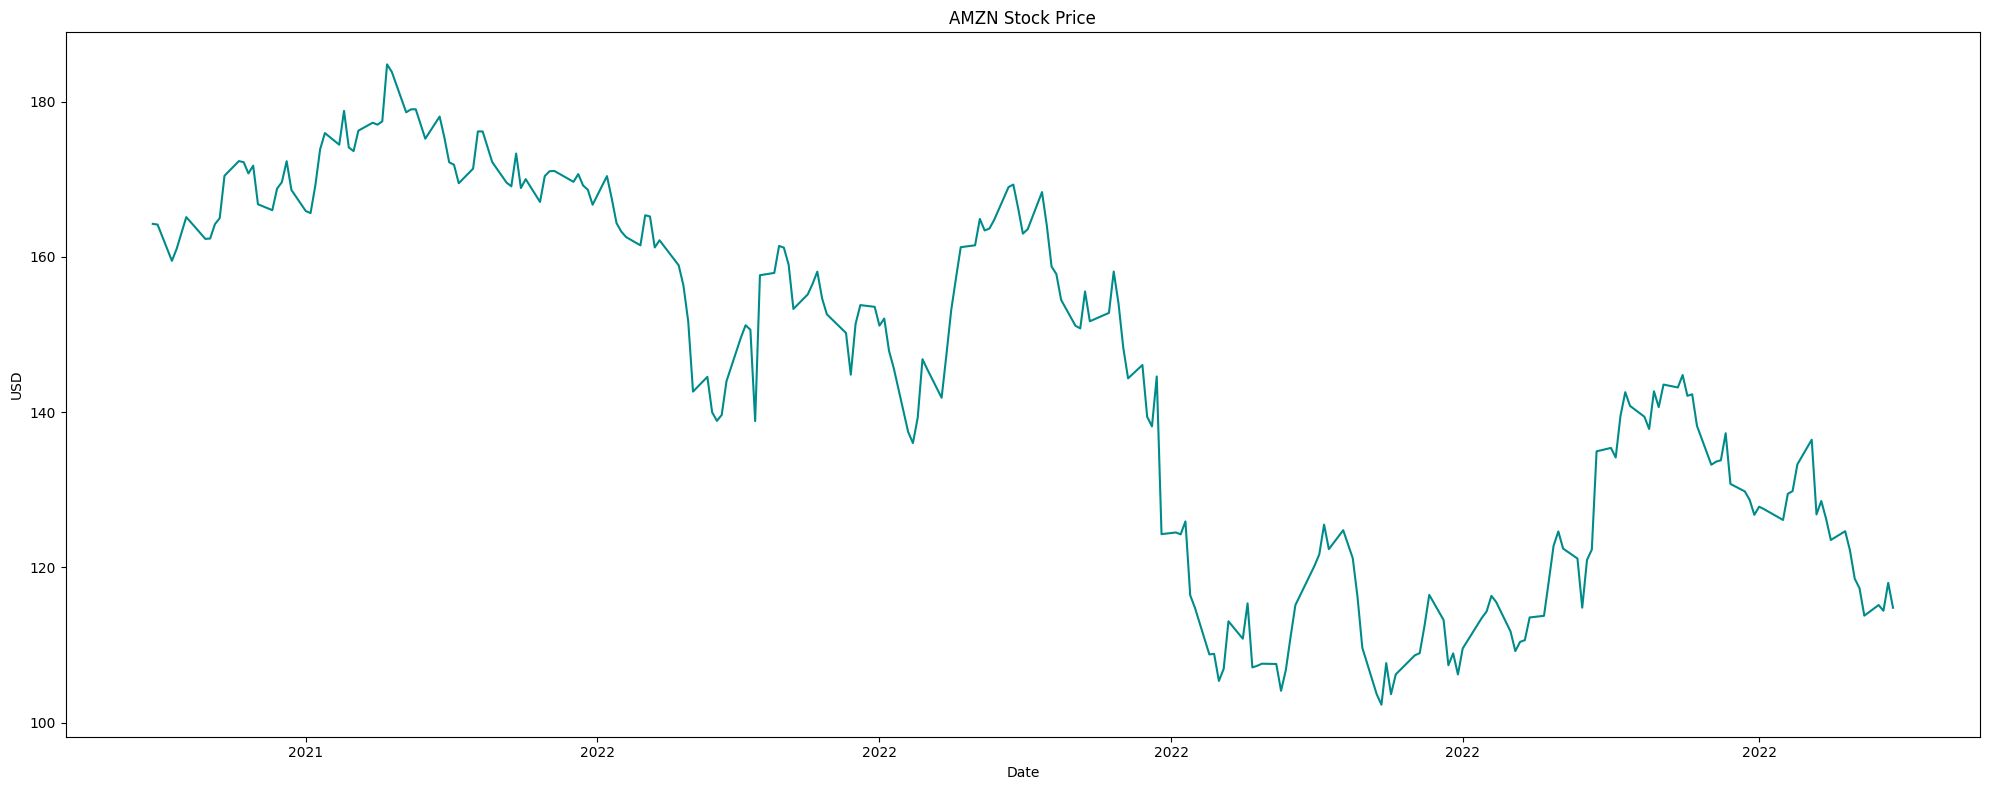

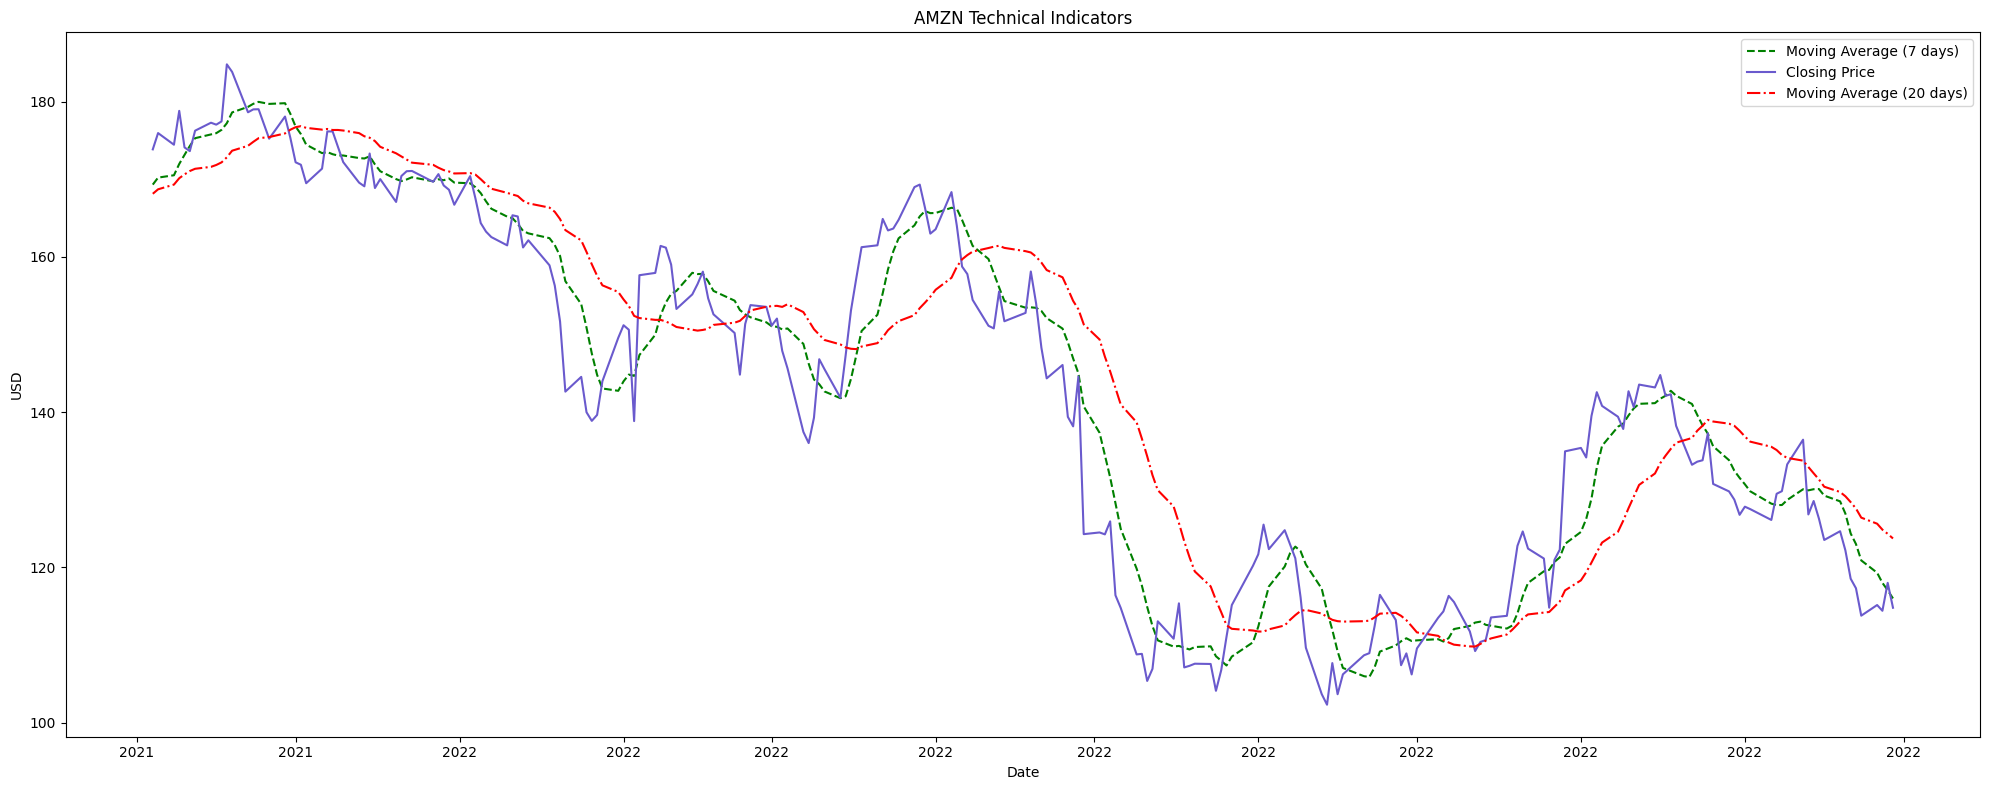

(227, 13)
X_train shape (190, 4, 13)
y_train shape (190, 1)
yc_train shape (190, 4, 1)
X_test shape (33, 4, 13)
y_test shape (33, 1)
yc_test shape (33, 4, 1)
Input dimension 4
Feature dimension 13
Output dimension 1
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 4, 64)             19968     
                                                                 
 flatten_3 (Flatten)         (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 1)                 257       
                                                                 
Total params: 20,225
Trainable params: 20,225
Non-trainable params: 0
_________________________________________________________________
None
6/6 [==============================] - 0s 5ms/step - loss: 0.0988 - root_mean_squared_error: 

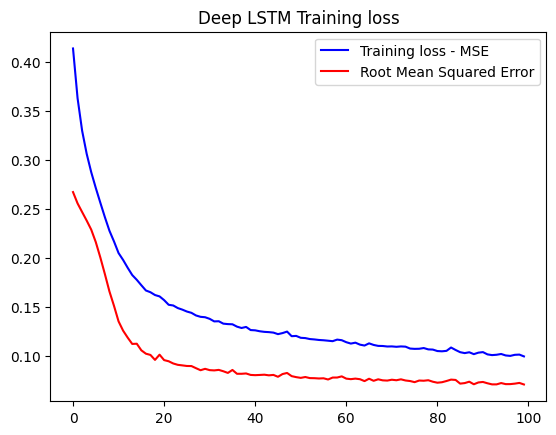

2/2 [==============================] - 0s 10ms/step
the test RMSE for Stock AMZN is 3.9714942264999324


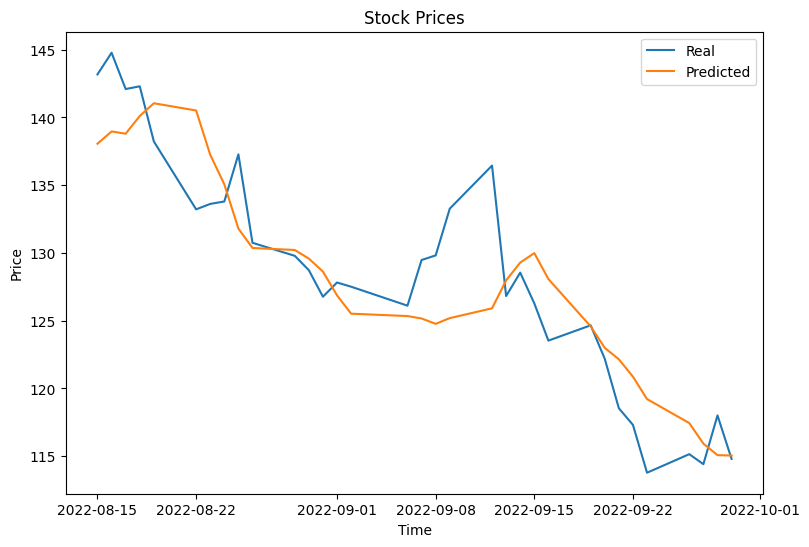

In [ ]:
X, y, date = clean_data(all_tweets, all_stocks, 'AMZN')
X_train, y_train, yc_train, X_test, y_test, y_scaler, input_dim, feature_size, output_dim = data_preprocess(X, y, days_to_consider, days_to_predict)

#
shallow_model = make_LSTM_model(input_dim, feature_size, output_dim)
print(shallow_model.summary())

#Defining Optimizers
optimizeAdam=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
optimizeRMS=tf.keras.optimizers.RMSprop()
optimizeSGD =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
optimizeSGD1 =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

#Evaluation metric
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
      return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# Compile & Fit
#single_step_model.compile(optimizer=optimizeAdam, loss='mae',metrics=["mae"])
shallow_model.compile(optimizer=optimizeAdam, loss=root_mean_squared_error,metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = shallow_model.fit(x = X_train, y = y_train ,epochs=100, verbose = 0)
# evaluate the model on the training data
loss, accuracy = shallow_model.evaluate(X_train, y_train)
print('Training loss:', loss)

#Plotting the training loss curve against the epochs
def plot_train_history(history, title):
  loss = history.history['loss']
  rmse = history.history['root_mean_squared_error']
  #mse = history.history['mse']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss - MSE')
  plt.plot(epochs, rmse, 'r', label='Root Mean Squared Error')
  #plt.plot(epochs, mse, 'r', label='Mean Squared Error')
  plt.title(title)
  plt.legend()

  plt.show()

plot_train_history(history, 'Deep LSTM Training loss')

#Testing and making Predictions
y_test_predicted = shallow_model.predict(X_test)
real_y = y_scaler.inverse_transform(y_test)
predicted_y = y_scaler.inverse_transform(y_test_predicted)

#Printing the test RMSE
Test_RMSE = np.sqrt(mean_squared_error(real_y, predicted_y))
print("the test RMSE for Stock AMZN is",Test_RMSE)

#Plot the predictions
fig, ax = plt.subplots(figsize=(9,6))

# Plot the two arrays as lines on the same plot
ax.plot(date[X_train.shape[0] + days_to_consider :], real_y, label='Real')
ax.plot(date[X_train.shape[0] + days_to_consider :], predicted_y, label='Predicted')

# Set the x-axis and y-axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Price')

# Add a title to the plot
ax.set_title('Stock Prices')

# Add a legend to the plot
ax.legend()

# Show the plot
plt.show()


# Stock Prediction for 'TSLA'

## Deep LSTM

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


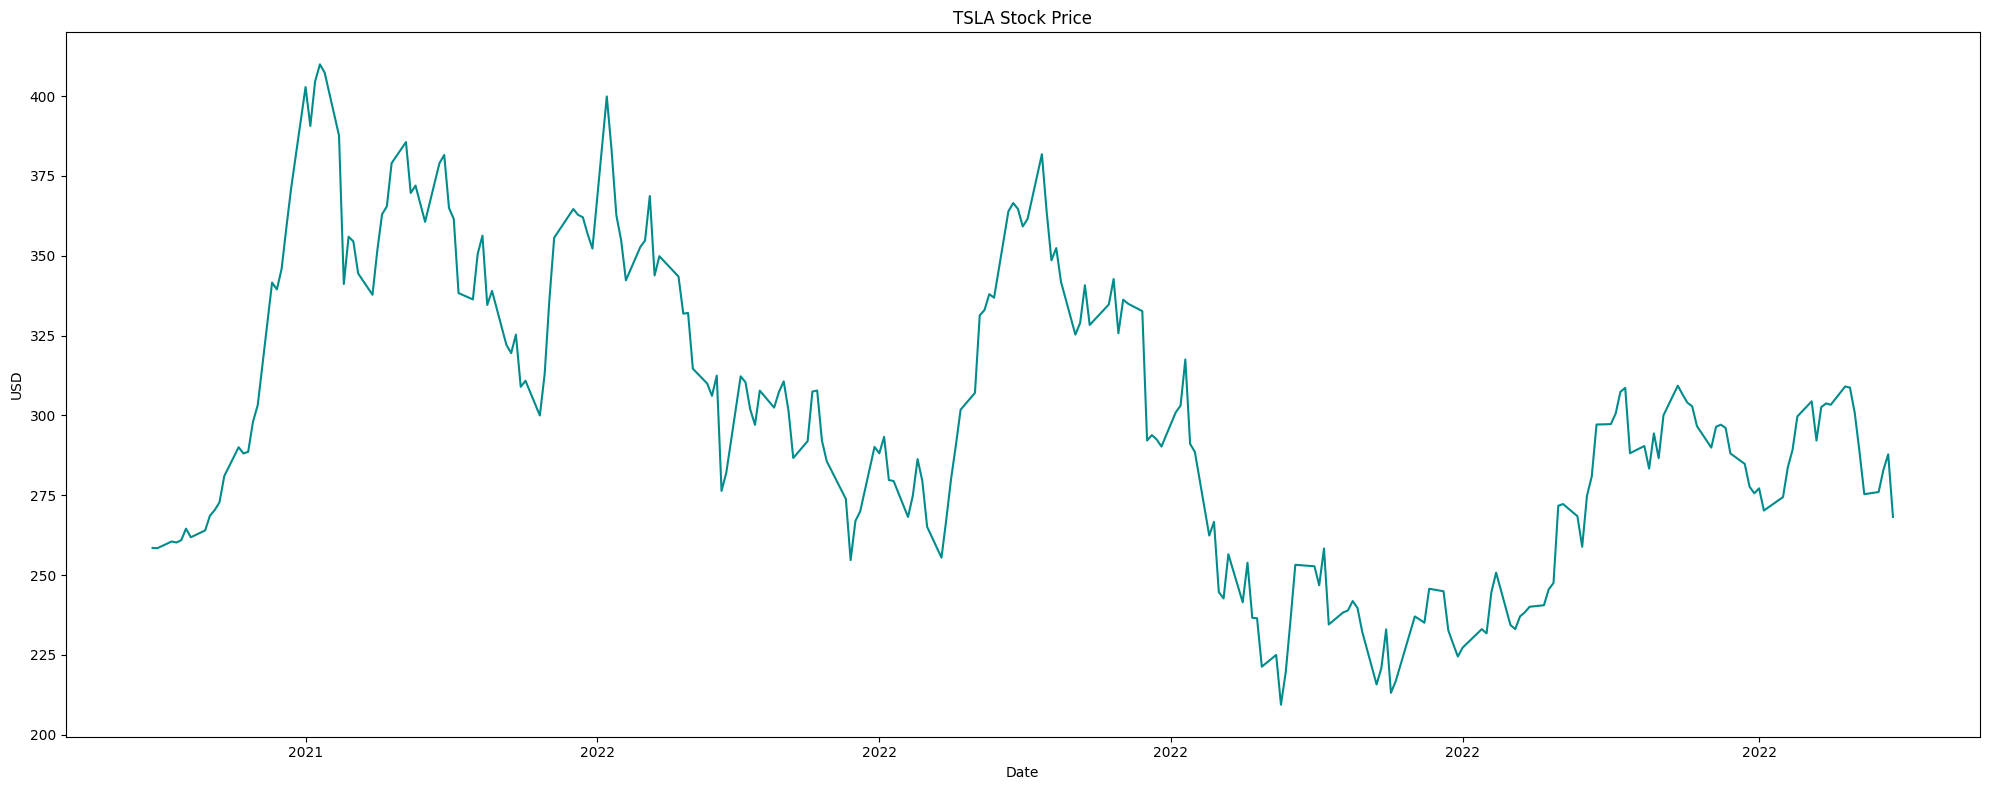

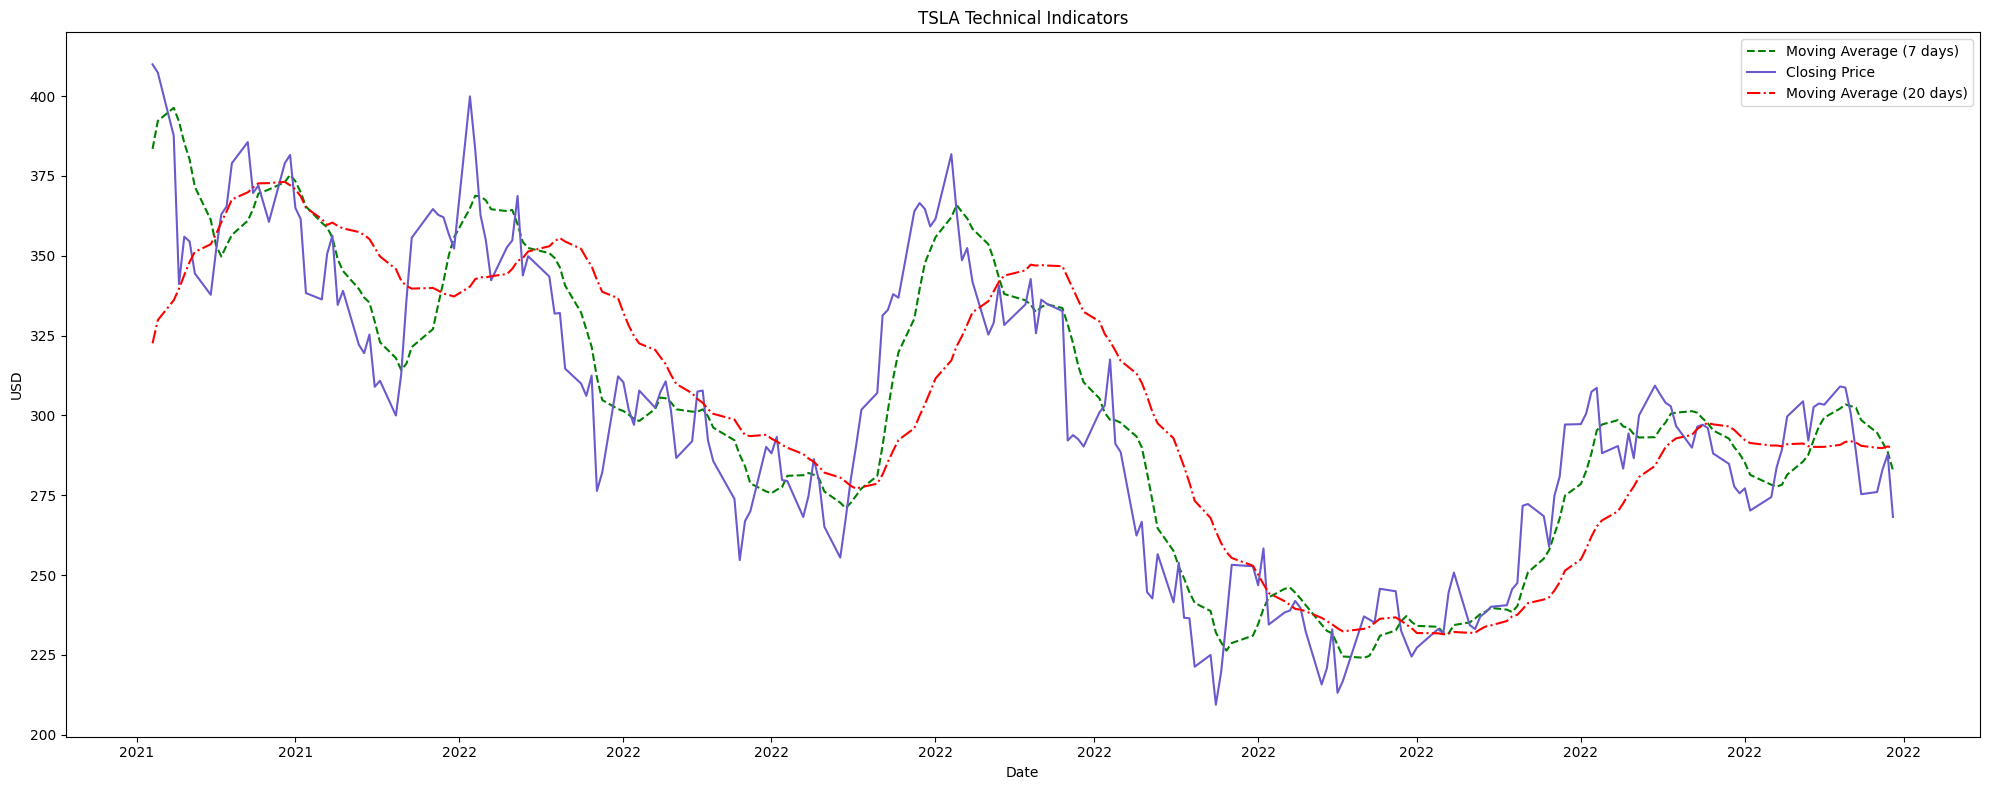

(227, 13)
X_train shape (190, 4, 13)
y_train shape (190, 1)
yc_train shape (190, 4, 1)
X_test shape (33, 4, 13)
y_test shape (33, 1)
yc_test shape (33, 4, 1)
Input dimension 4
Feature dimension 13
Output dimension 1
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 4, 512)            1077248   
                                                                 
 lstm_11 (LSTM)              (None, 4, 256)            787456    
                                                                 
 dense_22 (Dense)            (None, 4, 128)            32896     
                                                                 
 dense_23 (Dense)            (None, 4, 64)             8256      
                                                                 
 dense_24 (Dense)            (None, 4, 32)             2080      
                                    

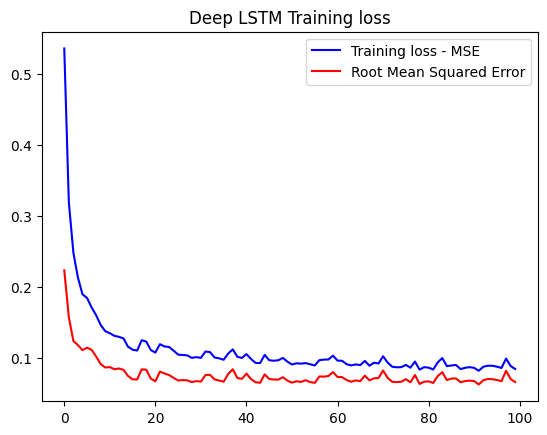

2/2 [==============================] - 0s 13ms/step
the test RMSE for Stock TSLA is 9.66758748250554


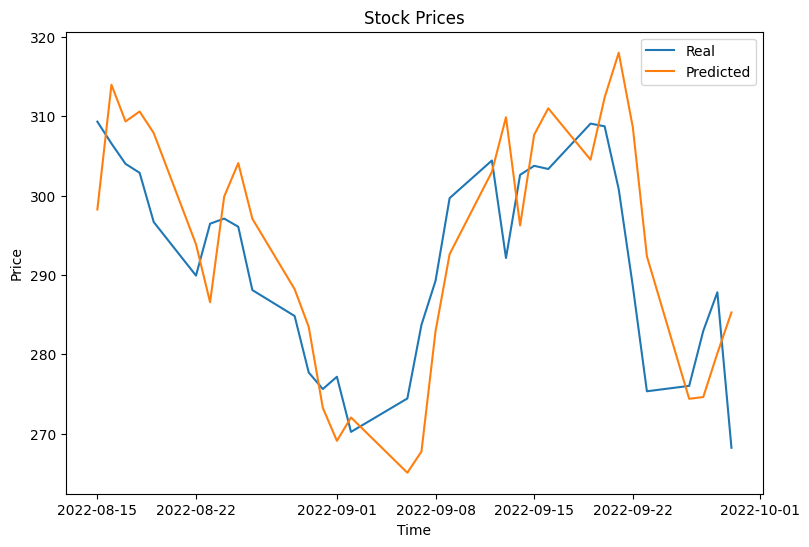

In [ ]:
X, y, date = clean_data(all_tweets, all_stocks, 'TSLA')
X_train, y_train, yc_train, X_test, y_test, y_scaler, input_dim, feature_size, output_dim = data_preprocess(X, y, days_to_consider, days_to_predict)

#
deep_model = make_deep_LSTM_model(input_dim, feature_size, output_dim)
print(deep_model.summary())

#Defining Optimizers
optimizeAdam=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
optimizeRMS=tf.keras.optimizers.RMSprop()
optimizeSGD =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
optimizeSGD1 =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

#Evaluation metric
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
      return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# Compile & Fit
#single_step_model.compile(optimizer=optimizeAdam, loss='mae',metrics=["mae"])
deep_model.compile(optimizer=optimizeAdam, loss=root_mean_squared_error,metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = deep_model.fit(x = X_train, y = y_train ,epochs=100, verbose = 0)
# evaluate the model on the training data
loss, accuracy = deep_model.evaluate(X_train, y_train)
print('Training loss:', loss)

#Plotting the training loss curve against the epochs
def plot_train_history(history, title):
  loss = history.history['loss']
  rmse = history.history['root_mean_squared_error']
  #mse = history.history['mse']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss - MSE')
  plt.plot(epochs, rmse, 'r', label='Root Mean Squared Error')
  #plt.plot(epochs, mse, 'r', label='Mean Squared Error')
  plt.title(title)
  plt.legend()

  plt.show()

plot_train_history(history, 'Deep LSTM Training loss')

#Testing and making Predictions
y_test_predicted = deep_model.predict(X_test)
real_y = y_scaler.inverse_transform(y_test)
predicted_y = y_scaler.inverse_transform(y_test_predicted)

#Printing the test RMSE
Test_RMSE = np.sqrt(mean_squared_error(real_y, predicted_y))
print("the test RMSE for Stock TSLA is",Test_RMSE)

#Plot the predictions
fig, ax = plt.subplots(figsize=(9,6))

# Plot the two arrays as lines on the same plot
ax.plot(date[X_train.shape[0] + days_to_consider :], real_y, label='Real')
ax.plot(date[X_train.shape[0] + days_to_consider :], predicted_y, label='Predicted')

# Set the x-axis and y-axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Price')

# Add a title to the plot
ax.set_title('Stock Prices')

# Add a legend to the plot
ax.legend()

# Show the plot
plt.show()


## Shallow LSTM

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 6.68 µs


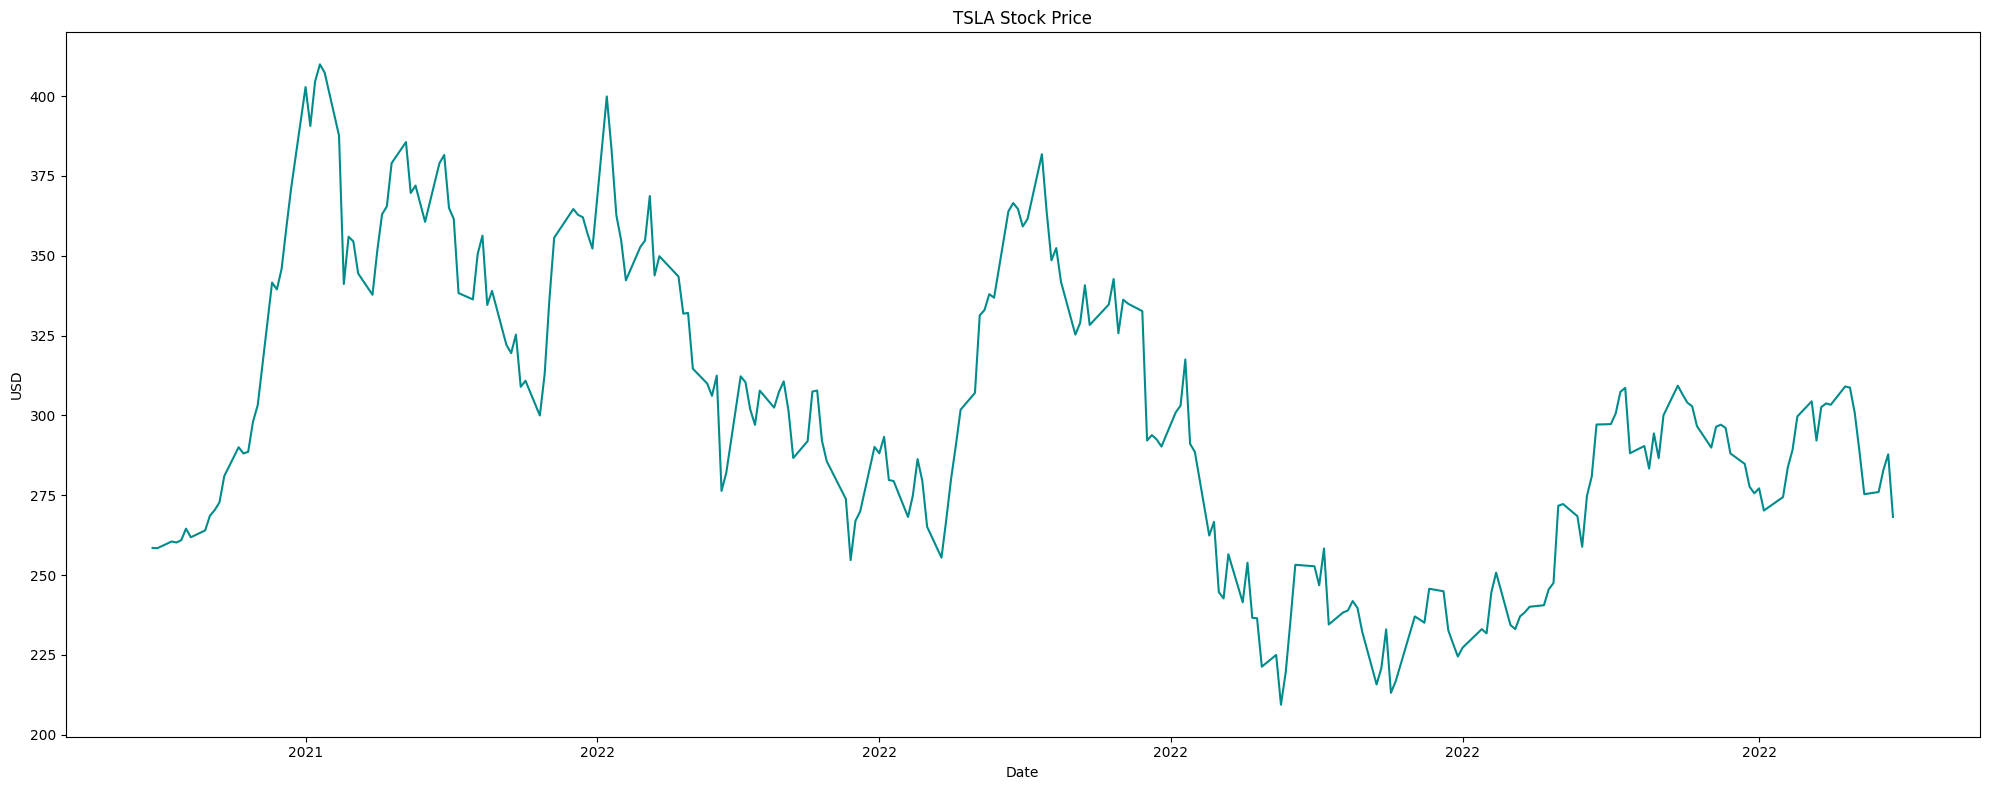

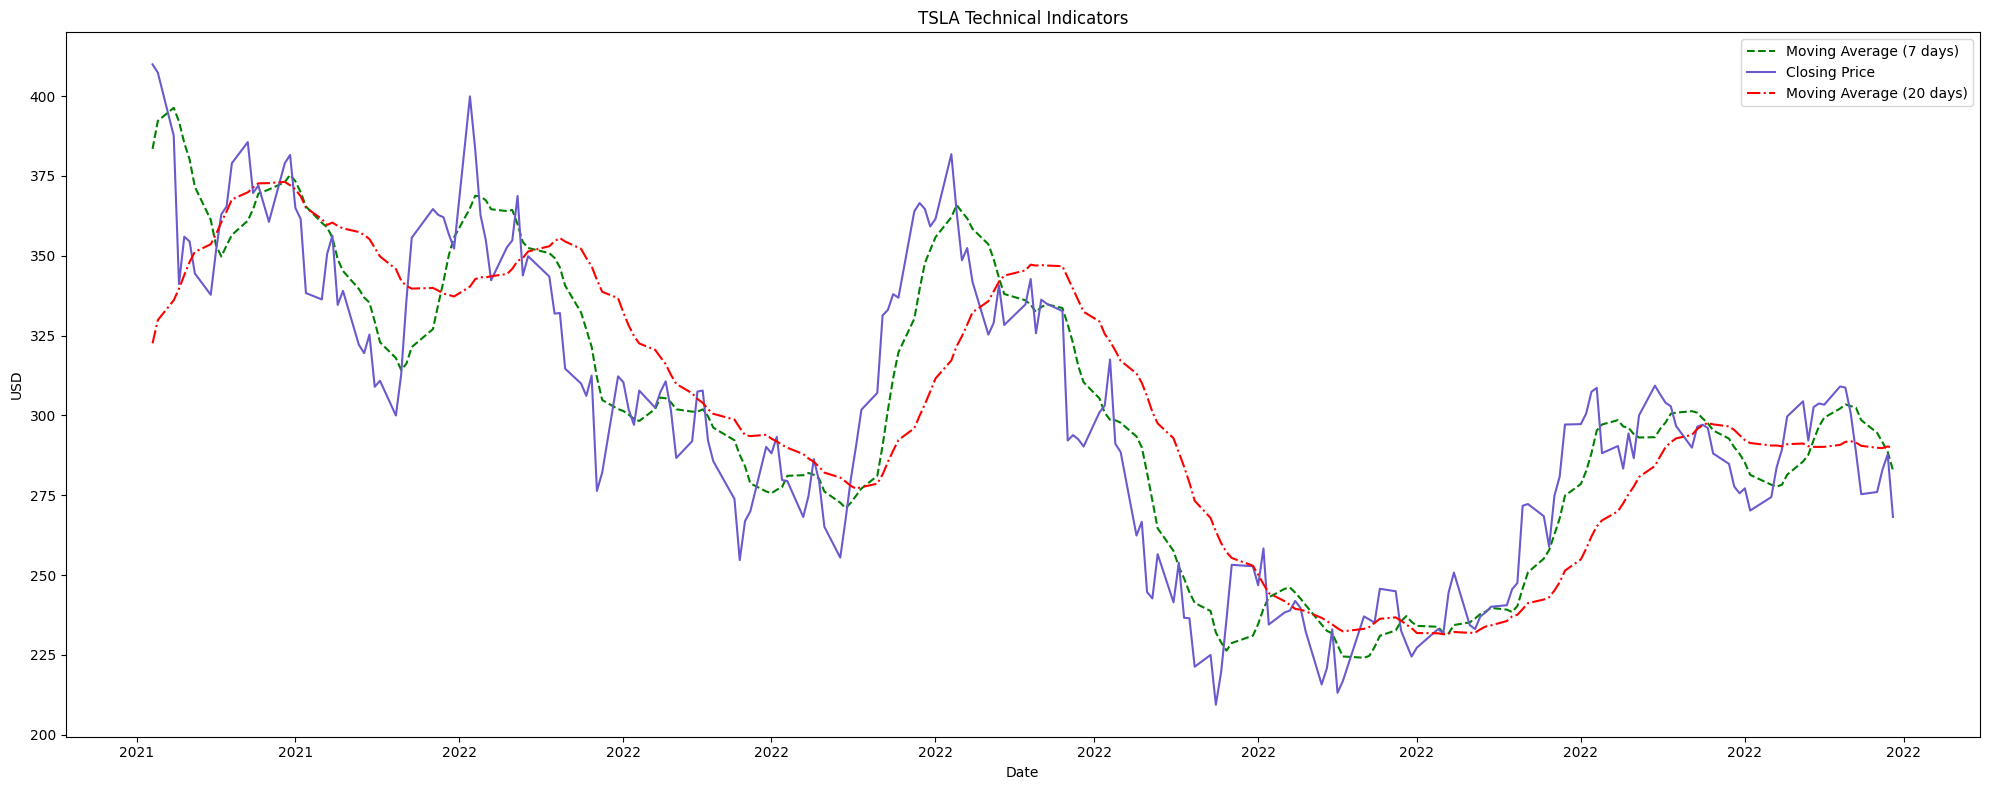

(227, 13)
X_train shape (190, 4, 13)
y_train shape (190, 1)
yc_train shape (190, 4, 1)
X_test shape (33, 4, 13)
y_test shape (33, 1)
yc_test shape (33, 4, 1)
Input dimension 4
Feature dimension 13
Output dimension 1
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 4, 64)             19968     
                                                                 
 flatten_7 (Flatten)         (None, 256)               0         
                                                                 
 dense_27 (Dense)            (None, 1)                 257       
                                                                 
Total params: 20,225
Trainable params: 20,225
Non-trainable params: 0
_________________________________________________________________
None
6/6 [==============================] - 0s 5ms/step - loss: 0.1011 - root_mean_squared_error: 

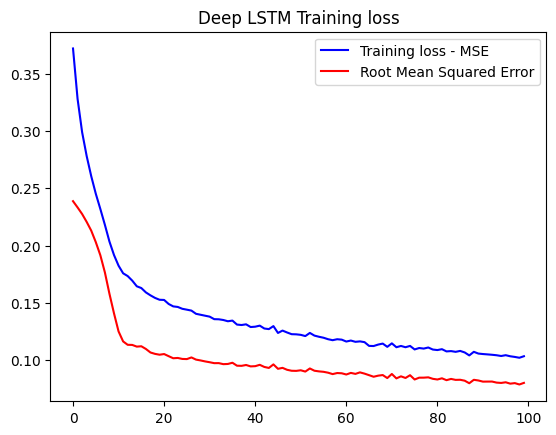

2/2 [==============================] - 0s 11ms/step
the test RMSE for Stock TSLA is 12.245060977579254


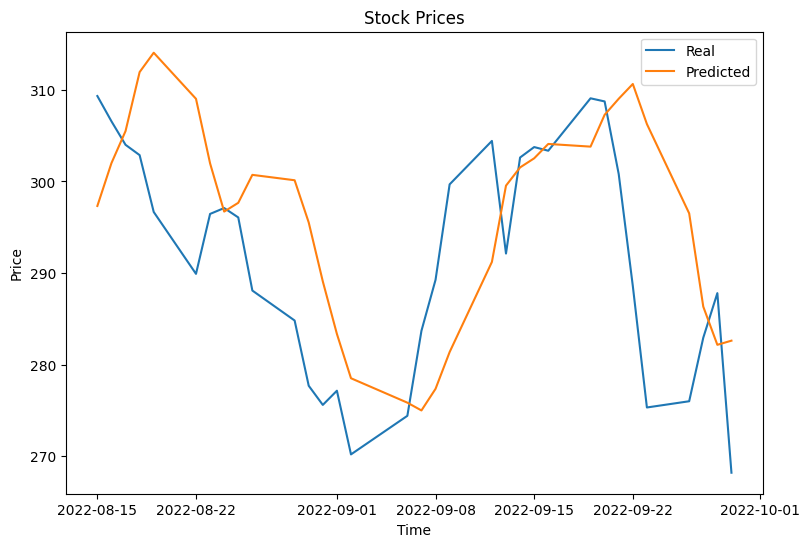

In [ ]:
X, y, date = clean_data(all_tweets, all_stocks, 'TSLA')
X_train, y_train, yc_train, X_test, y_test, y_scaler, input_dim, feature_size, output_dim = data_preprocess(X, y, days_to_consider, days_to_predict)

#
shallow_model = make_LSTM_model(input_dim, feature_size, output_dim)
print(shallow_model.summary())

#Defining Optimizers
optimizeAdam=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
optimizeRMS=tf.keras.optimizers.RMSprop()
optimizeSGD =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
optimizeSGD1 =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

#Evaluation metric
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
      return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# Compile & Fit
#single_step_model.compile(optimizer=optimizeAdam, loss='mae',metrics=["mae"])
shallow_model.compile(optimizer=optimizeAdam, loss=root_mean_squared_error,metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = shallow_model.fit(x = X_train, y = y_train ,epochs=100, verbose = 0)
# evaluate the model on the training data
loss, accuracy = shallow_model.evaluate(X_train, y_train)
print('Training loss:', loss)

#Plotting the training loss curve against the epochs
def plot_train_history(history, title):
  loss = history.history['loss']
  rmse = history.history['root_mean_squared_error']
  #mse = history.history['mse']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss - MSE')
  plt.plot(epochs, rmse, 'r', label='Root Mean Squared Error')
  #plt.plot(epochs, mse, 'r', label='Mean Squared Error')
  plt.title(title)
  plt.legend()

  plt.show()

plot_train_history(history, 'Deep LSTM Training loss')

#Testing and making Predictions
y_test_predicted = shallow_model.predict(X_test)
real_y = y_scaler.inverse_transform(y_test)
predicted_y = y_scaler.inverse_transform(y_test_predicted)

#Printing the test RMSE
Test_RMSE = np.sqrt(mean_squared_error(real_y, predicted_y))
print("the test RMSE for Stock TSLA is",Test_RMSE)

#Plot the predictions
fig, ax = plt.subplots(figsize=(9,6))

# Plot the two arrays as lines on the same plot
ax.plot(date[X_train.shape[0] + days_to_consider :], real_y, label='Real')
ax.plot(date[X_train.shape[0] + days_to_consider :], predicted_y, label='Predicted')

# Set the x-axis and y-axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Price')

# Add a title to the plot
ax.set_title('Stock Prices')

# Add a legend to the plot
ax.legend()

# Show the plot
plt.show()


# Stock Prediction for 'TSM'

## Deep LSTM

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.2 µs


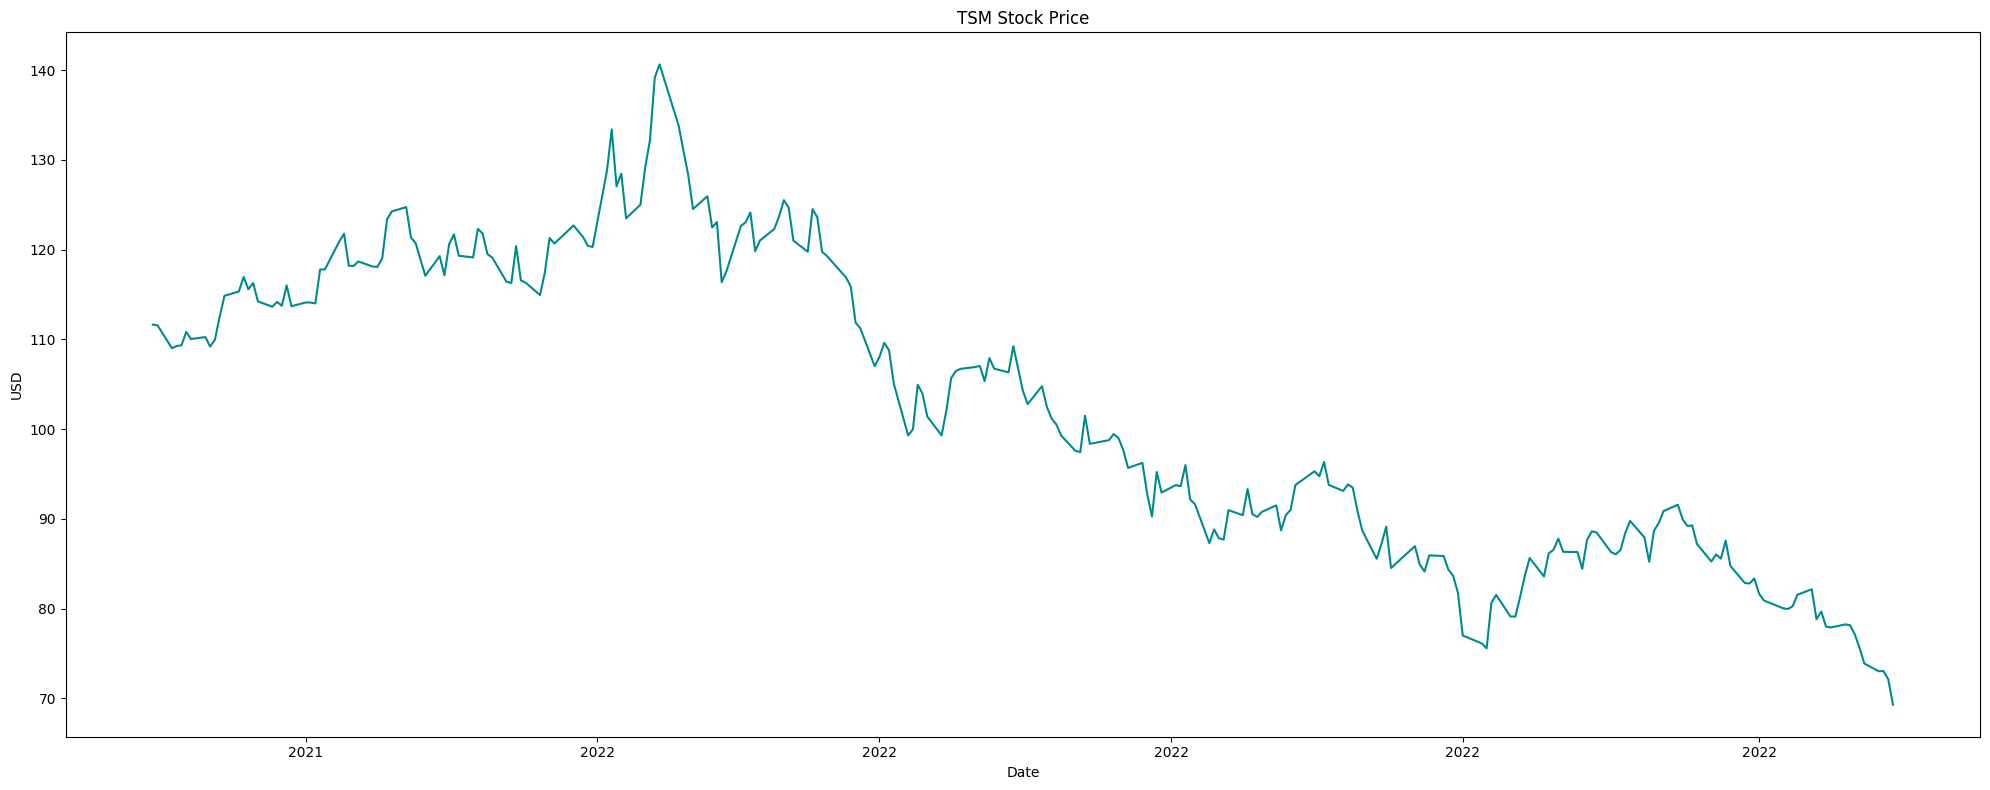

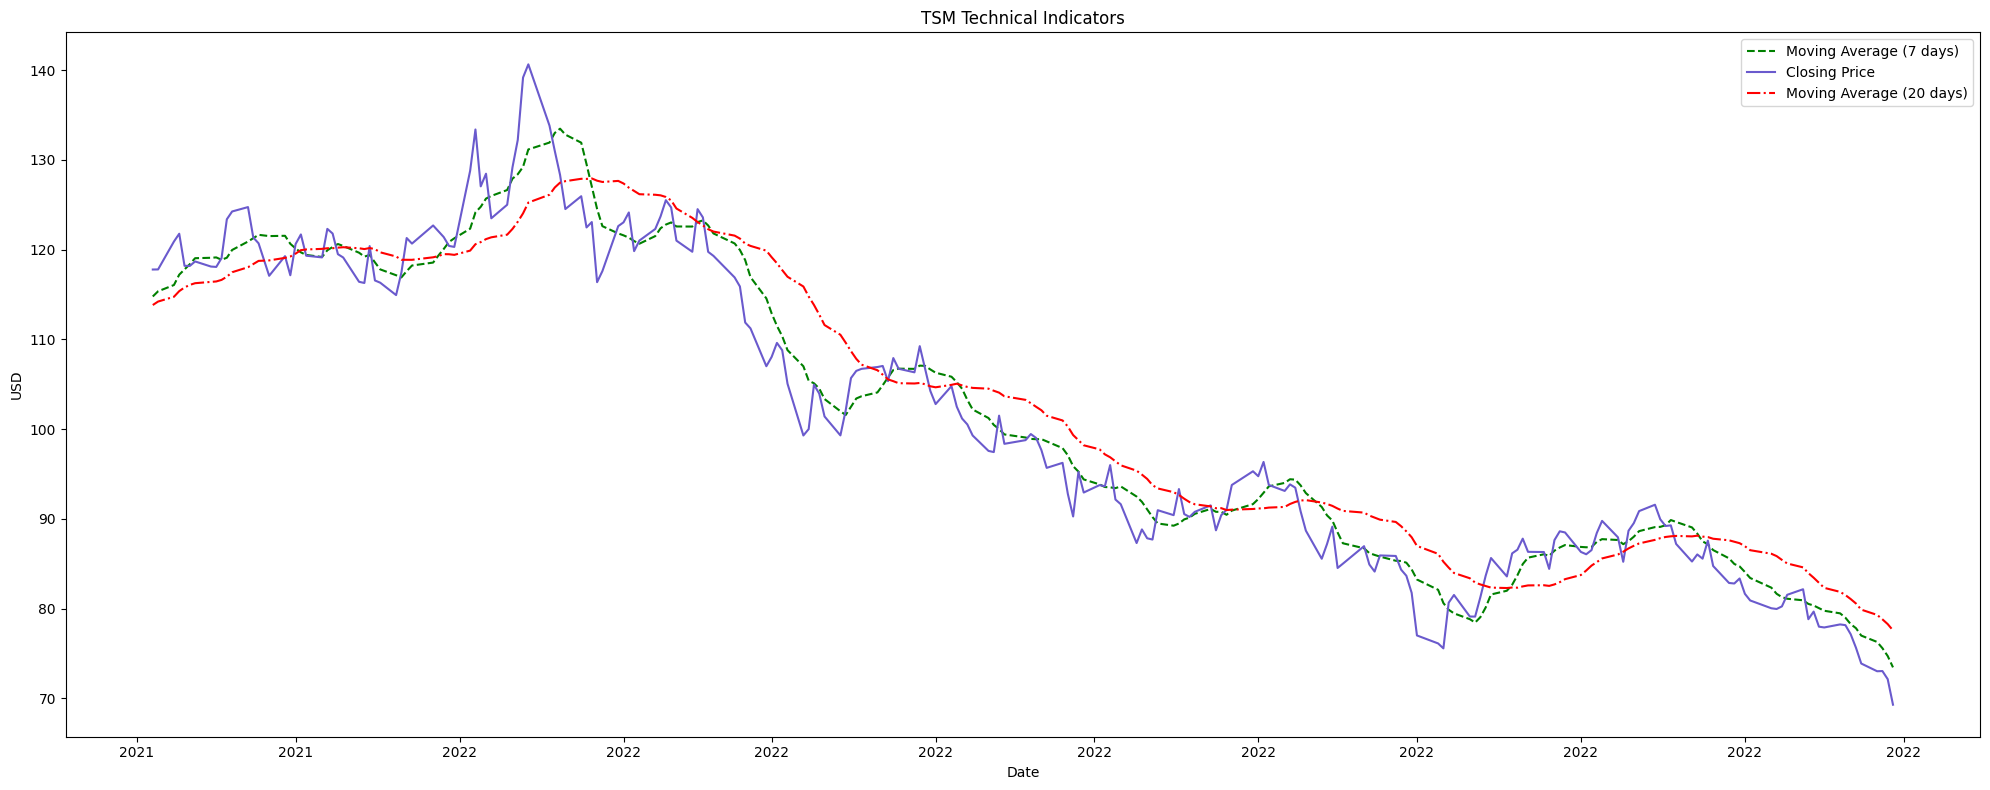

(227, 13)
X_train shape (190, 4, 13)
y_train shape (190, 1)
yc_train shape (190, 4, 1)
X_test shape (33, 4, 13)
y_test shape (33, 1)
yc_test shape (33, 4, 1)
Input dimension 4
Feature dimension 13
Output dimension 1
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 4, 512)            1077248   
                                                                 
 lstm_14 (LSTM)              (None, 4, 256)            787456    
                                                                 
 dense_28 (Dense)            (None, 4, 128)            32896     
                                                                 
 dense_29 (Dense)            (None, 4, 64)             8256      
                                                                 
 dense_30 (Dense)            (None, 4, 32)             2080      
                                    

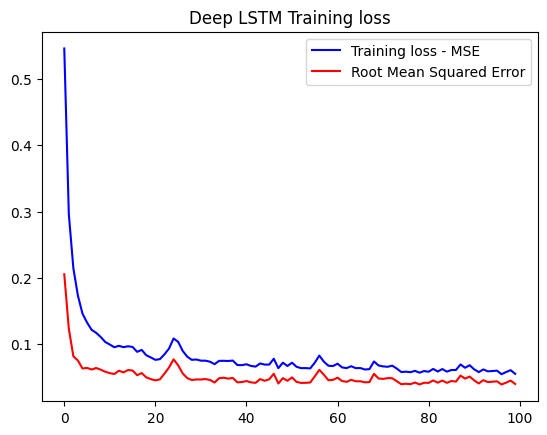

2/2 [==============================] - 1s 13ms/step
the test RMSE for Stock TSM is 3.2470720291980575


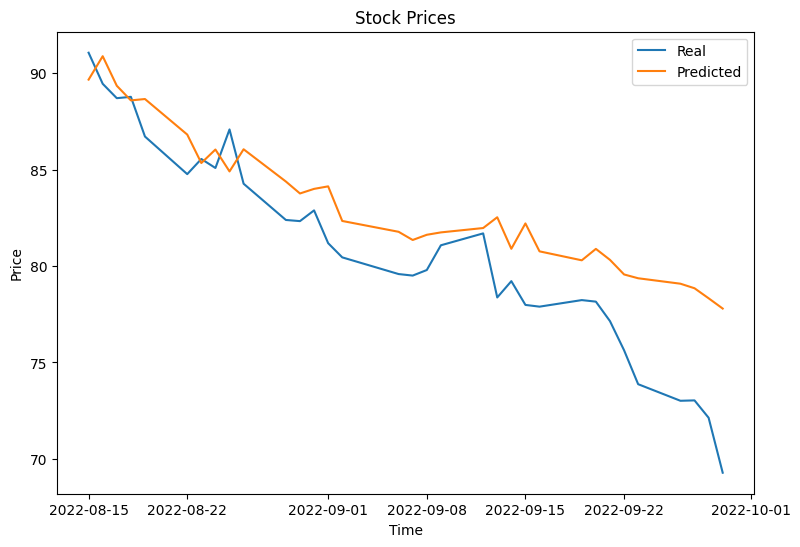

In [ ]:
X, y, date = clean_data(all_tweets, all_stocks, 'TSM')
X_train, y_train, yc_train, X_test, y_test, y_scaler, input_dim, feature_size, output_dim = data_preprocess(X, y, days_to_consider, days_to_predict)

#
deep_model = make_deep_LSTM_model(input_dim, feature_size, output_dim)
print(deep_model.summary())

#Defining Optimizers
optimizeAdam=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
optimizeRMS=tf.keras.optimizers.RMSprop()
optimizeSGD =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
optimizeSGD1 =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

#Evaluation metric
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
      return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# Compile & Fit
#single_step_model.compile(optimizer=optimizeAdam, loss='mae',metrics=["mae"])
deep_model.compile(optimizer=optimizeAdam, loss=root_mean_squared_error,metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = deep_model.fit(x = X_train, y = y_train ,epochs=100, verbose = 0)
# evaluate the model on the training data
loss, accuracy = deep_model.evaluate(X_train, y_train)
print('Training loss:', loss)

#Plotting the training loss curve against the epochs
def plot_train_history(history, title):
  loss = history.history['loss']
  rmse = history.history['root_mean_squared_error']
  #mse = history.history['mse']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss - MSE')
  plt.plot(epochs, rmse, 'r', label='Root Mean Squared Error')
  #plt.plot(epochs, mse, 'r', label='Mean Squared Error')
  plt.title(title)
  plt.legend()

  plt.show()

plot_train_history(history, 'Deep LSTM Training loss')

#Testing and making Predictions
y_test_predicted = deep_model.predict(X_test)
real_y = y_scaler.inverse_transform(y_test)
predicted_y = y_scaler.inverse_transform(y_test_predicted)

#Printing the test RMSE
Test_RMSE = np.sqrt(mean_squared_error(real_y, predicted_y))
print("the test RMSE for Stock TSM is",Test_RMSE)

#Plot the predictions
fig, ax = plt.subplots(figsize=(9,6))

# Plot the two arrays as lines on the same plot
ax.plot(date[X_train.shape[0] + days_to_consider :], real_y, label='Real')
ax.plot(date[X_train.shape[0] + days_to_consider :], predicted_y, label='Predicted')

# Set the x-axis and y-axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Price')

# Add a title to the plot
ax.set_title('Stock Prices')

# Add a legend to the plot
ax.legend()

# Show the plot
plt.show()


## Shallow LSTM

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.72 µs


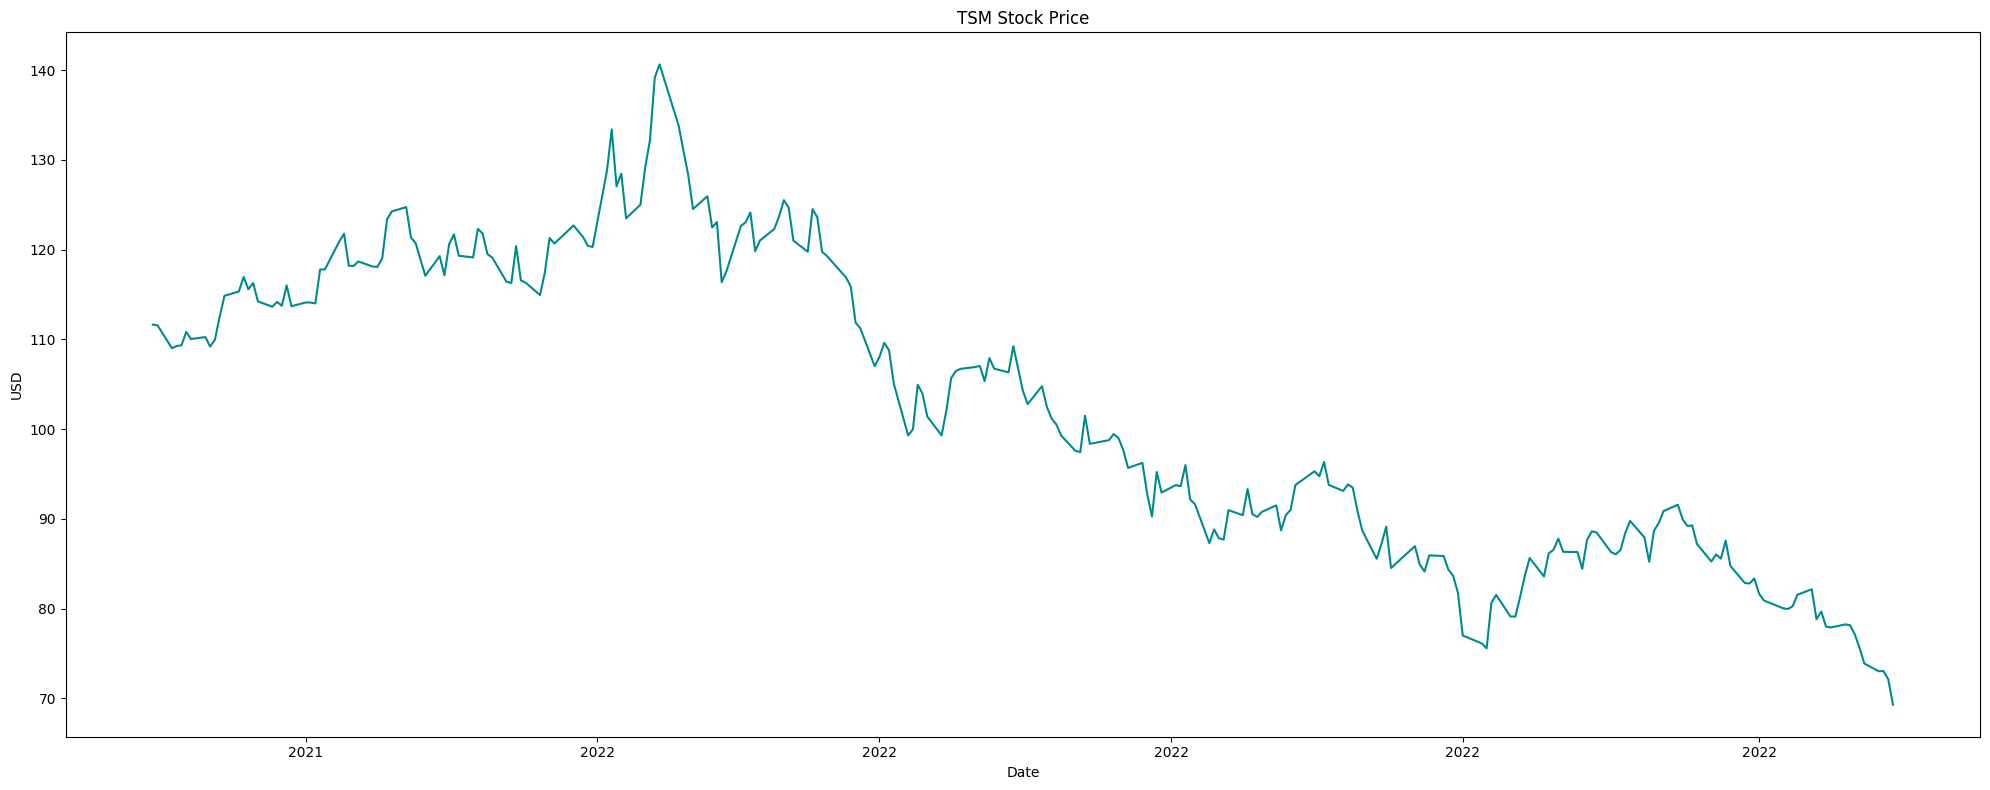

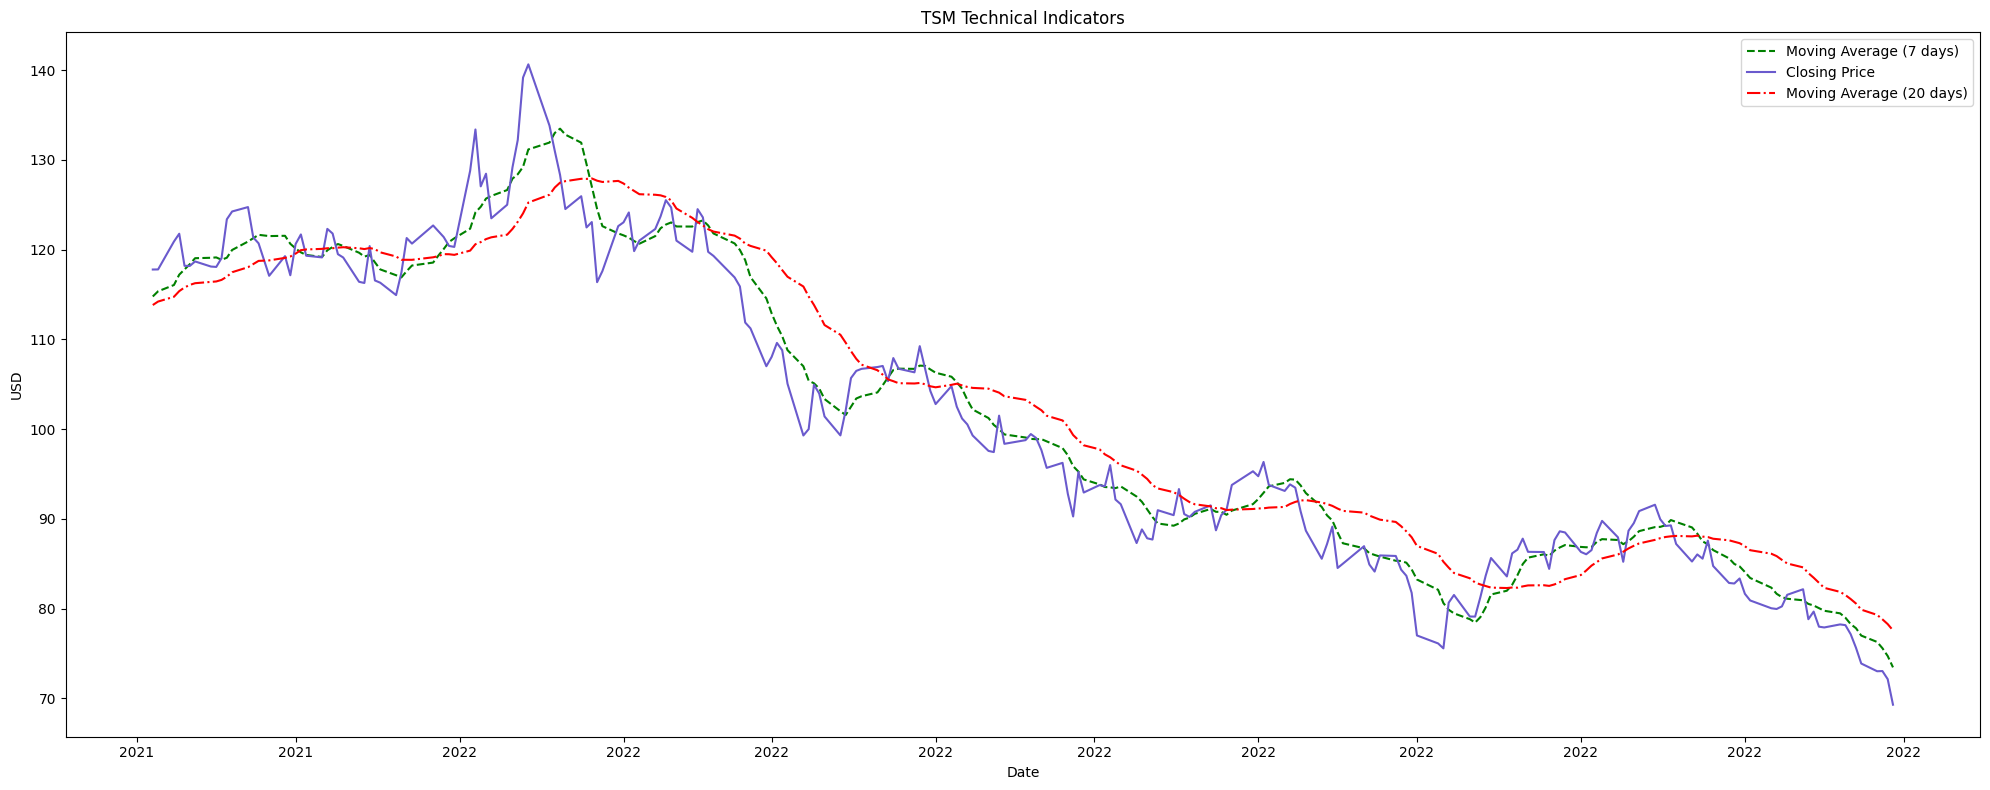

(227, 13)
X_train shape (190, 4, 13)
y_train shape (190, 1)
yc_train shape (190, 4, 1)
X_test shape (33, 4, 13)
y_test shape (33, 1)
yc_test shape (33, 4, 1)
Input dimension 4
Feature dimension 13
Output dimension 1
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 4, 64)             19968     
                                                                 
 flatten_9 (Flatten)         (None, 256)               0         
                                                                 
 dense_33 (Dense)            (None, 1)                 257       
                                                                 
Total params: 20,225
Trainable params: 20,225
Non-trainable params: 0
_________________________________________________________________
None
6/6 [==============================] - 0s 5ms/step - loss: 0.0709 - root_mean_squared_error: 

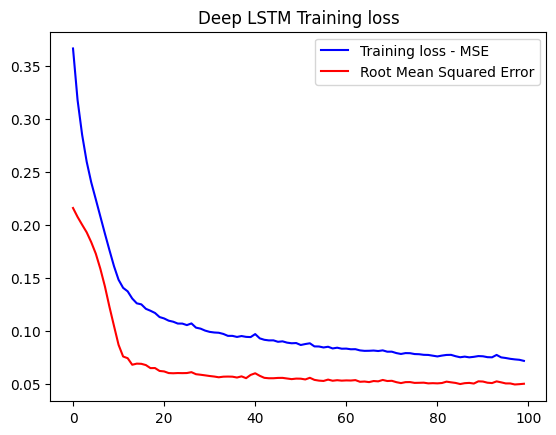

2/2 [==============================] - 0s 6ms/step
the test RMSE for Stock TSM is 3.8051761783757834


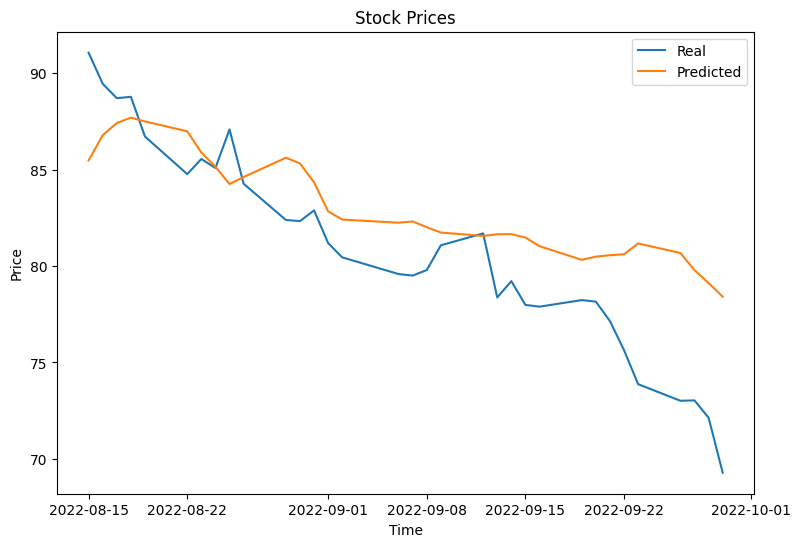

In [ ]:
X, y, date = clean_data(all_tweets, all_stocks, 'TSM')
X_train, y_train, yc_train, X_test, y_test, y_scaler, input_dim, feature_size, output_dim = data_preprocess(X, y, days_to_consider, days_to_predict)

#
shallow_model = make_LSTM_model(input_dim, feature_size, output_dim)
print(shallow_model.summary())

#Defining Optimizers
optimizeAdam=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
optimizeRMS=tf.keras.optimizers.RMSprop()
optimizeSGD =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
optimizeSGD1 =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

#Evaluation metric
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
      return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# Compile & Fit
#single_step_model.compile(optimizer=optimizeAdam, loss='mae',metrics=["mae"])
shallow_model.compile(optimizer=optimizeAdam, loss=root_mean_squared_error,metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = shallow_model.fit(x = X_train, y = y_train ,epochs=100, verbose = 0)
# evaluate the model on the training data
loss, accuracy = shallow_model.evaluate(X_train, y_train)
print('Training loss:', loss)

#Plotting the training loss curve against the epochs
def plot_train_history(history, title):
  loss = history.history['loss']
  rmse = history.history['root_mean_squared_error']
  #mse = history.history['mse']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss - MSE')
  plt.plot(epochs, rmse, 'r', label='Root Mean Squared Error')
  #plt.plot(epochs, mse, 'r', label='Mean Squared Error')
  plt.title(title)
  plt.legend()

  plt.show()

plot_train_history(history, 'Deep LSTM Training loss')

#Testing and making Predictions
y_test_predicted = shallow_model.predict(X_test)
real_y = y_scaler.inverse_transform(y_test)
predicted_y = y_scaler.inverse_transform(y_test_predicted)

#Printing the test RMSE
Test_RMSE = np.sqrt(mean_squared_error(real_y, predicted_y))
print("the test RMSE for Stock TSM is",Test_RMSE)

#Plot the predictions
fig, ax = plt.subplots(figsize=(9,6))

# Plot the two arrays as lines on the same plot
ax.plot(date[X_train.shape[0] + days_to_consider :], real_y, label='Real')
ax.plot(date[X_train.shape[0] + days_to_consider :], predicted_y, label='Predicted')

# Set the x-axis and y-axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Price')

# Add a title to the plot
ax.set_title('Stock Prices')

# Add a legend to the plot
ax.legend()

# Show the plot
plt.show()


# Stock Prediction for 'AAPL'

## Deep LSTM

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.82 µs


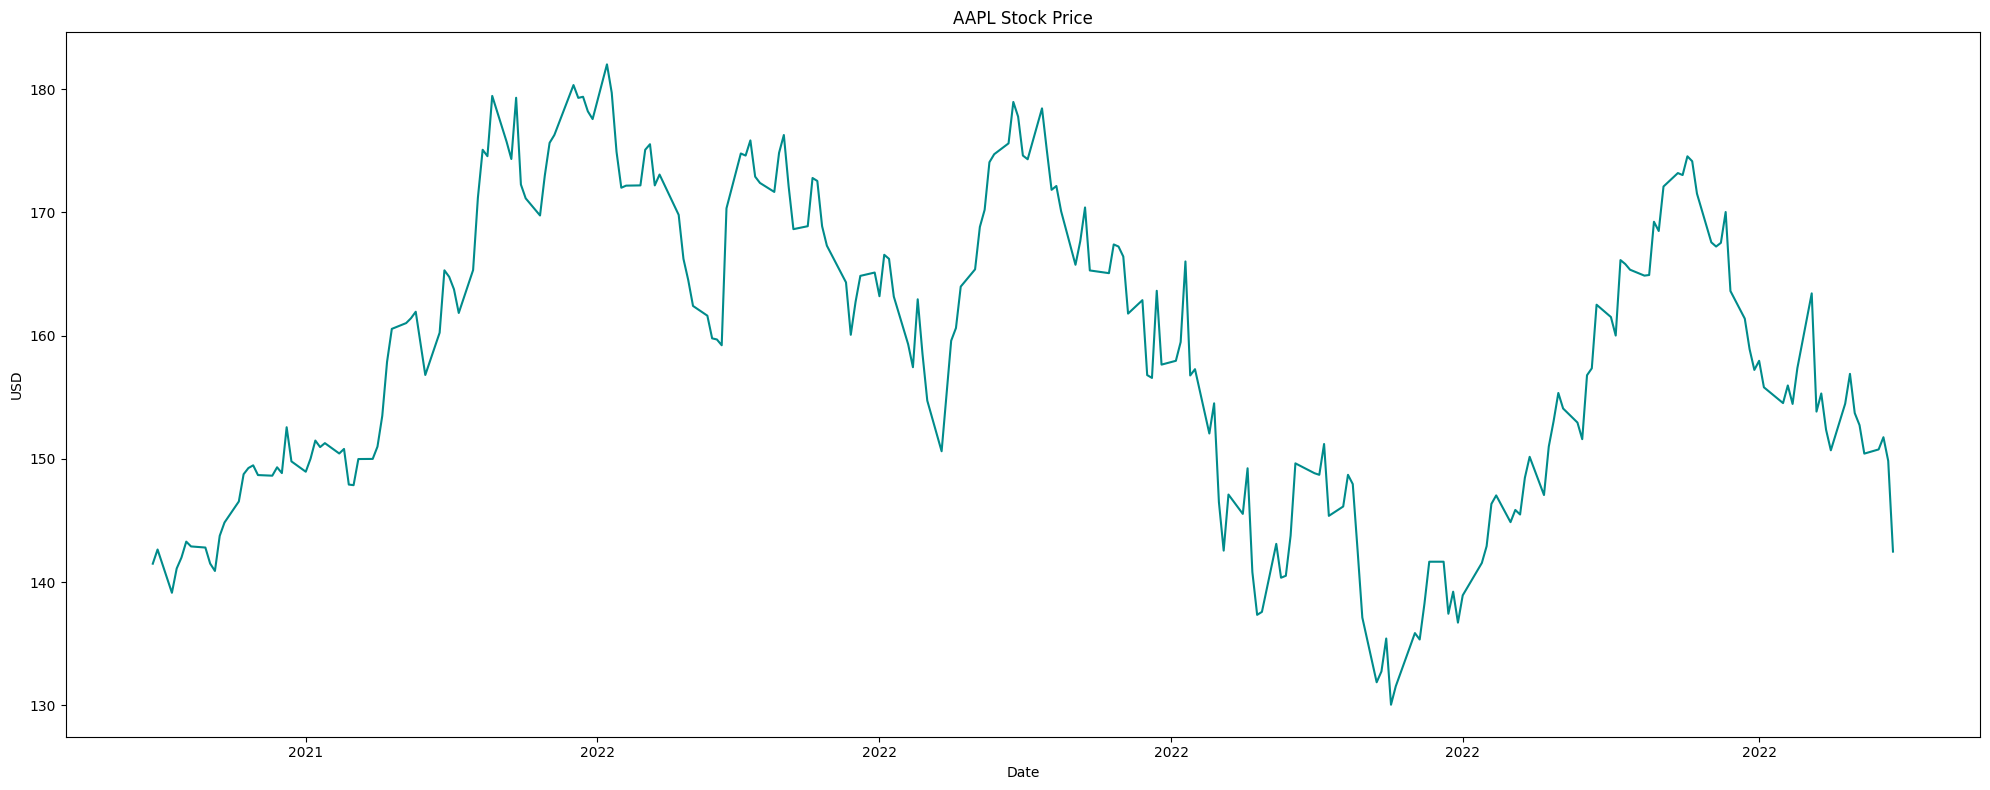

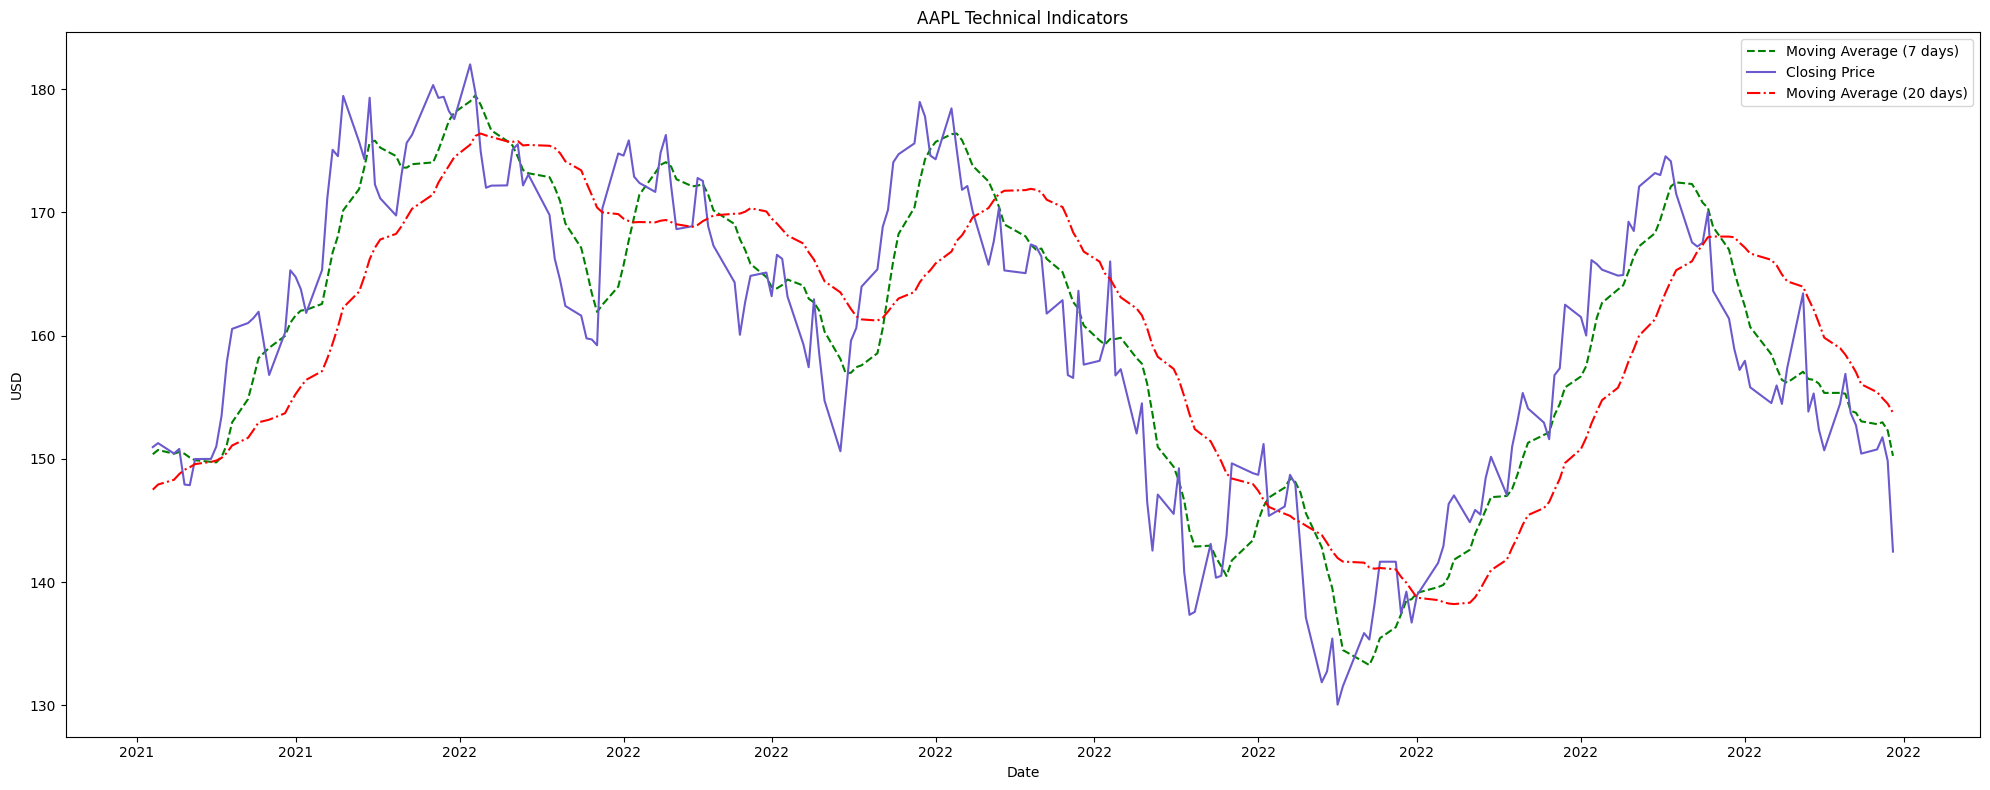

(227, 13)
X_train shape (190, 4, 13)
y_train shape (190, 1)
yc_train shape (190, 4, 1)
X_test shape (33, 4, 13)
y_test shape (33, 1)
yc_test shape (33, 4, 1)
Input dimension 4
Feature dimension 13
Output dimension 1
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 4, 512)            1077248   
                                                                 
 lstm_17 (LSTM)              (None, 4, 256)            787456    
                                                                 
 dense_34 (Dense)            (None, 4, 128)            32896     
                                                                 
 dense_35 (Dense)            (None, 4, 64)             8256      
                                                                 
 dense_36 (Dense)            (None, 4, 32)             2080      
                                   

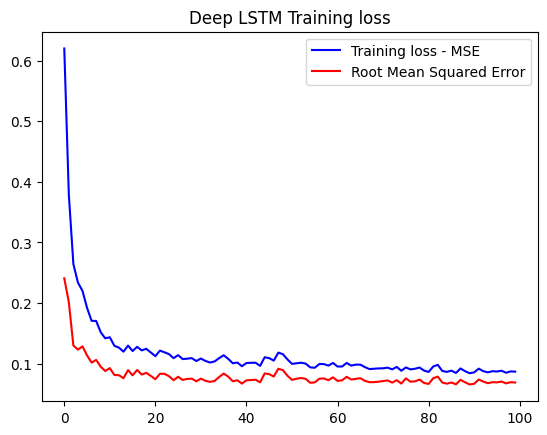

2/2 [==============================] - 2s 25ms/step
the test RMSE for Stock AAPL is 3.696092935536416


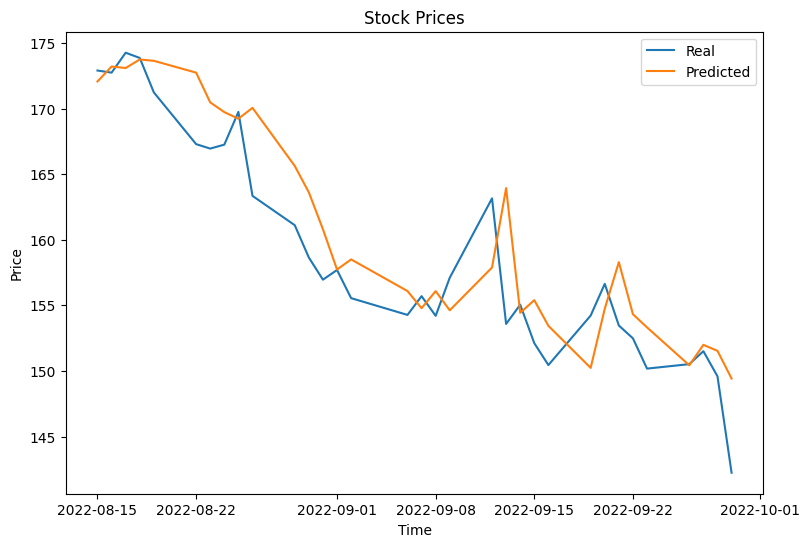

In [ ]:
X, y, date = clean_data(all_tweets, all_stocks, 'AAPL')
X_train, y_train, yc_train, X_test, y_test, y_scaler, input_dim, feature_size, output_dim = data_preprocess(X, y, days_to_consider, days_to_predict)

#
deep_model = make_deep_LSTM_model(input_dim, feature_size, output_dim)
print(deep_model.summary())

#Defining Optimizers
optimizeAdam=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
optimizeRMS=tf.keras.optimizers.RMSprop()
optimizeSGD =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
optimizeSGD1 =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

#Evaluation metric
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
      return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# Compile & Fit
#single_step_model.compile(optimizer=optimizeAdam, loss='mae',metrics=["mae"])
deep_model.compile(optimizer=optimizeAdam, loss=root_mean_squared_error,metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = deep_model.fit(x = X_train, y = y_train ,epochs=100, verbose = 0)
# evaluate the model on the training data
loss, accuracy = deep_model.evaluate(X_train, y_train)
print('Training loss:', loss)

#Plotting the training loss curve against the epochs
def plot_train_history(history, title):
  loss = history.history['loss']
  rmse = history.history['root_mean_squared_error']
  #mse = history.history['mse']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss - MSE')
  plt.plot(epochs, rmse, 'r', label='Root Mean Squared Error')
  #plt.plot(epochs, mse, 'r', label='Mean Squared Error')
  plt.title(title)
  plt.legend()

  plt.show()

plot_train_history(history, 'Deep LSTM Training loss')

#Testing and making Predictions
y_test_predicted = deep_model.predict(X_test)
real_y = y_scaler.inverse_transform(y_test)
predicted_y = y_scaler.inverse_transform(y_test_predicted)

#Printing the test RMSE
Test_RMSE = np.sqrt(mean_squared_error(real_y, predicted_y))
print("the test RMSE for Stock AAPL is",Test_RMSE)

#Plot the predictions
fig, ax = plt.subplots(figsize=(9,6))

# Plot the two arrays as lines on the same plot
ax.plot(date[X_train.shape[0] + days_to_consider :], real_y, label='Real')
ax.plot(date[X_train.shape[0] + days_to_consider :], predicted_y, label='Predicted')

# Set the x-axis and y-axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Price')

# Add a title to the plot
ax.set_title('Stock Prices')

# Add a legend to the plot
ax.legend()

# Show the plot
plt.show()


## Shallow LSTM

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


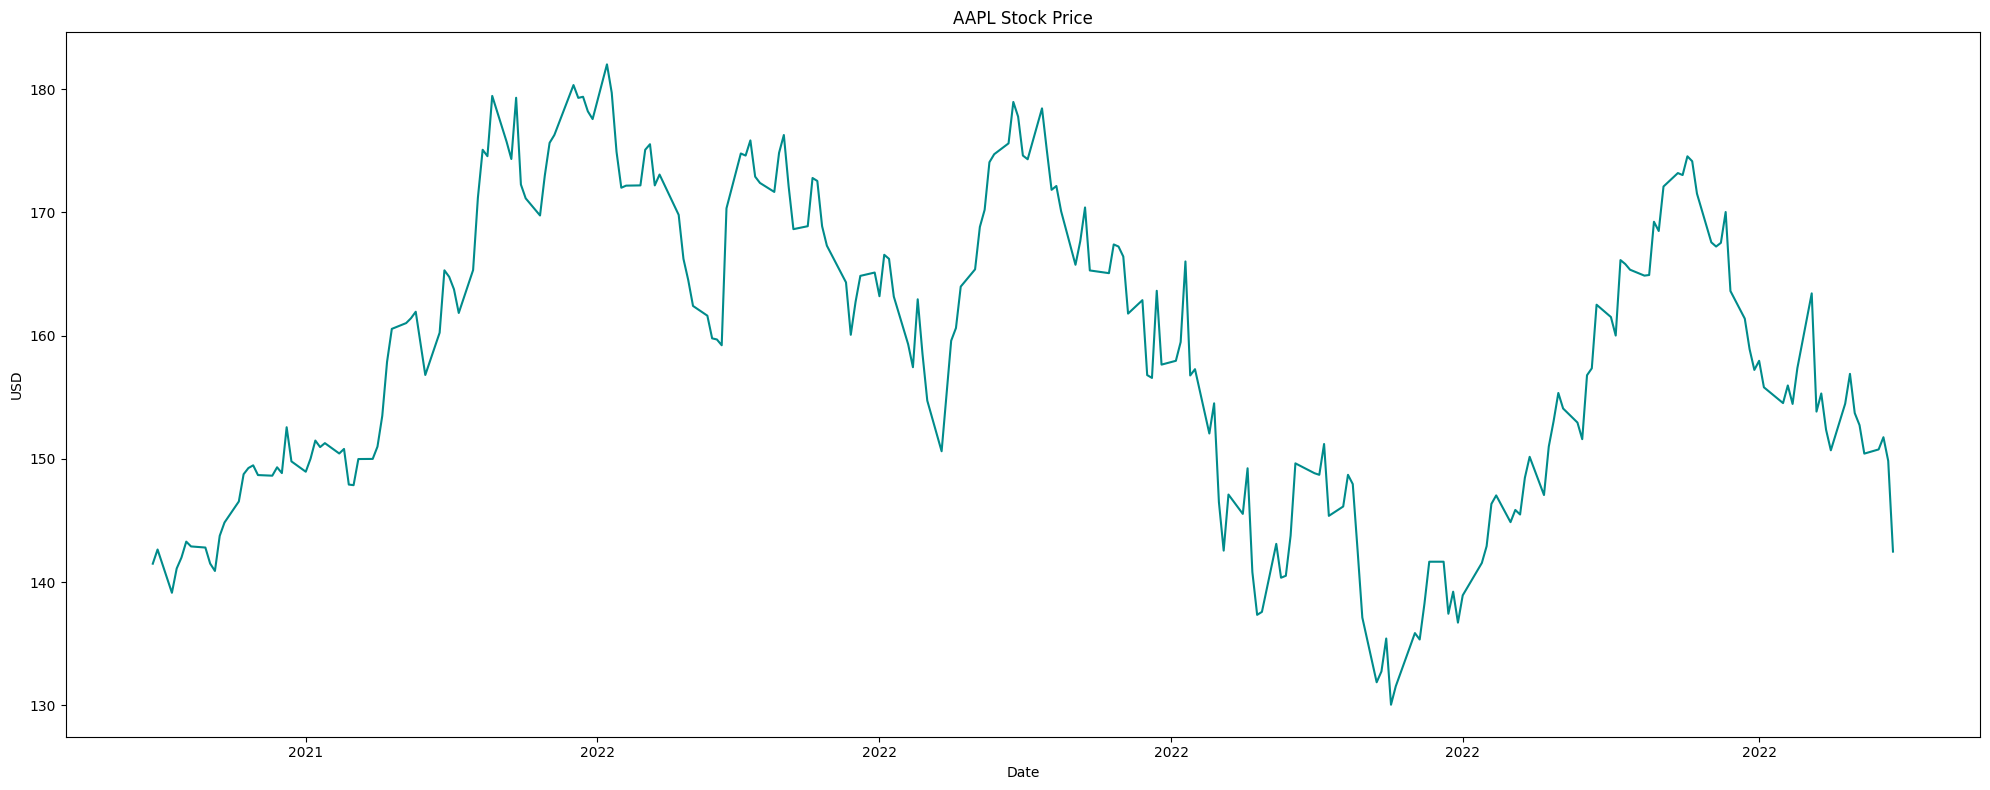

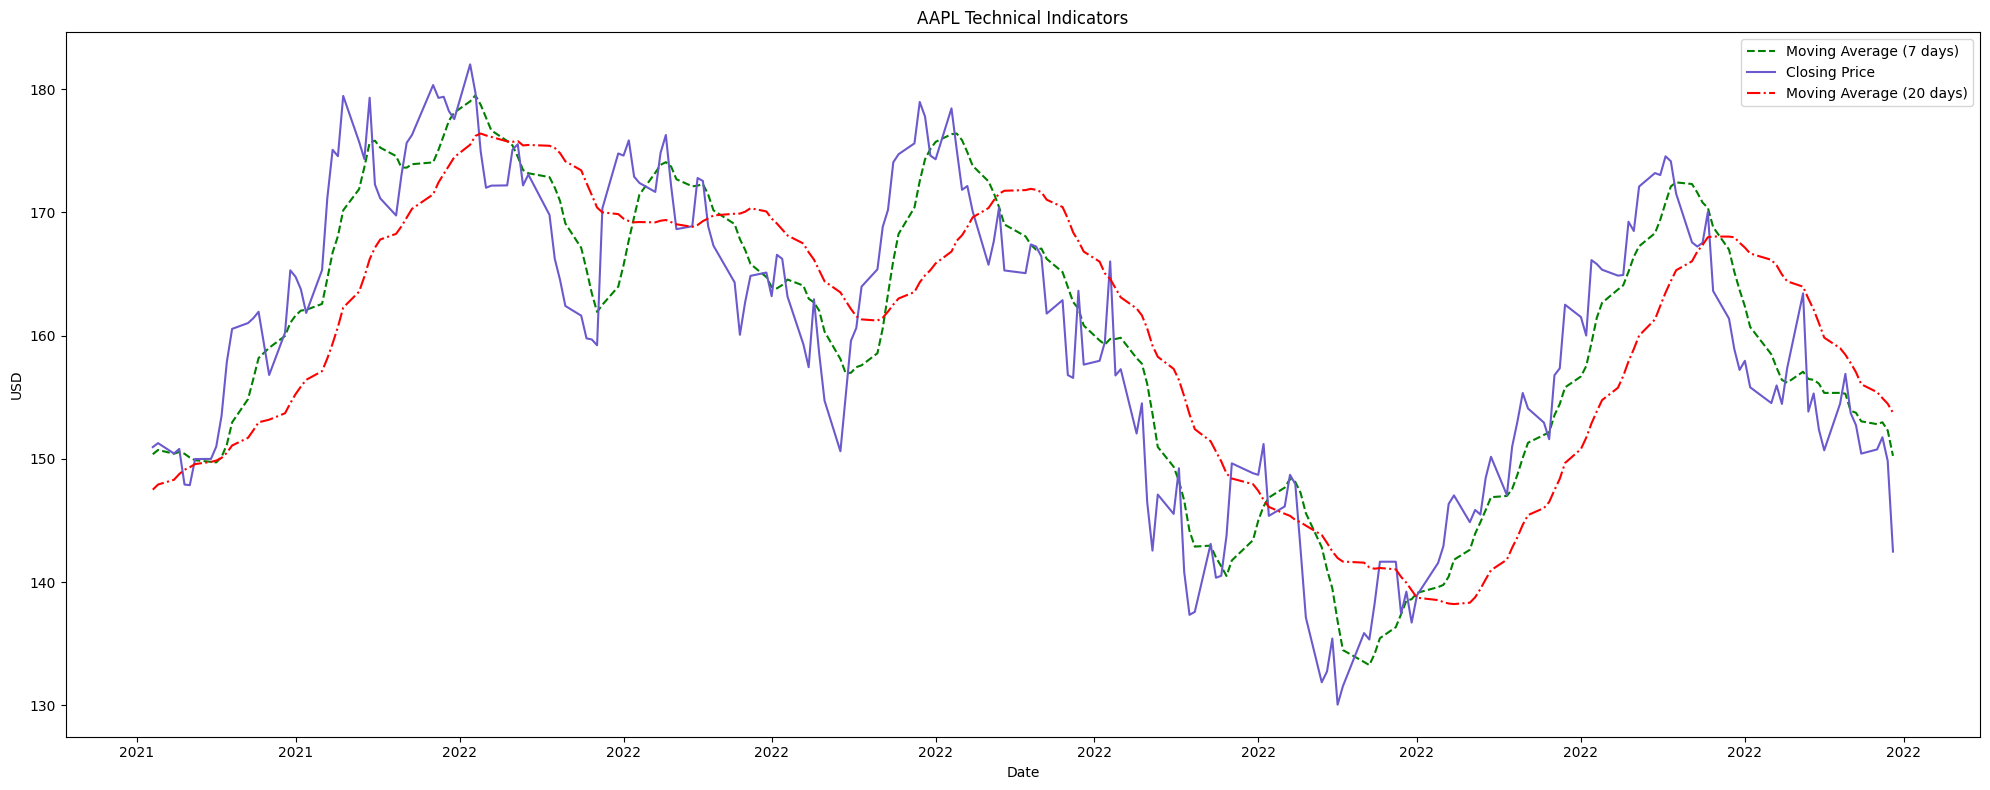

(227, 13)
X_train shape (190, 4, 13)
y_train shape (190, 1)
yc_train shape (190, 4, 1)
X_test shape (33, 4, 13)
y_test shape (33, 1)
yc_test shape (33, 4, 1)
Input dimension 4
Feature dimension 13
Output dimension 1
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 4, 64)             19968     
                                                                 
 flatten_11 (Flatten)        (None, 256)               0         
                                                                 
 dense_39 (Dense)            (None, 1)                 257       
                                                                 
Total params: 20,225
Trainable params: 20,225
Non-trainable params: 0
_________________________________________________________________
None
6/6 [==============================] - 0s 5ms/step - loss: 0.1075 - root_mean_squared_error:

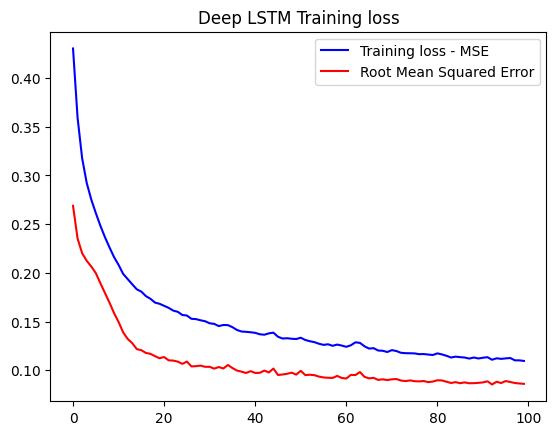

2/2 [==============================] - 0s 6ms/step
the test RMSE for Stock AAPL is 3.981282908033688


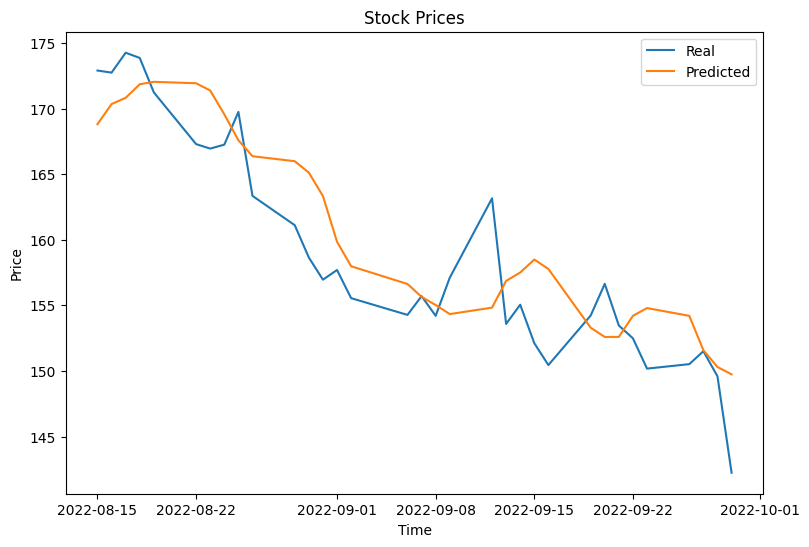

In [ ]:
X, y, date = clean_data(all_tweets, all_stocks, 'AAPL')
X_train, y_train, yc_train, X_test, y_test, y_scaler, input_dim, feature_size, output_dim = data_preprocess(X, y, days_to_consider, days_to_predict)

#
shallow_model = make_LSTM_model(input_dim, feature_size, output_dim)
print(shallow_model.summary())

#Defining Optimizers
optimizeAdam=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
optimizeRMS=tf.keras.optimizers.RMSprop()
optimizeSGD =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
optimizeSGD1 =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

#Evaluation metric
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
      return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# Compile & Fit
#single_step_model.compile(optimizer=optimizeAdam, loss='mae',metrics=["mae"])
shallow_model.compile(optimizer=optimizeAdam, loss=root_mean_squared_error,metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = shallow_model.fit(x = X_train, y = y_train ,epochs=100, verbose = 0)
# evaluate the model on the training data
loss, accuracy = shallow_model.evaluate(X_train, y_train)
print('Training loss:', loss)

#Plotting the training loss curve against the epochs
def plot_train_history(history, title):
  loss = history.history['loss']
  rmse = history.history['root_mean_squared_error']
  #mse = history.history['mse']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss - MSE')
  plt.plot(epochs, rmse, 'r', label='Root Mean Squared Error')
  #plt.plot(epochs, mse, 'r', label='Mean Squared Error')
  plt.title(title)
  plt.legend()

  plt.show()

plot_train_history(history, 'Deep LSTM Training loss')

#Testing and making Predictions
y_test_predicted = shallow_model.predict(X_test)
real_y = y_scaler.inverse_transform(y_test)
predicted_y = y_scaler.inverse_transform(y_test_predicted)

#Printing the test RMSE
Test_RMSE = np.sqrt(mean_squared_error(real_y, predicted_y))
print("the test RMSE for Stock AAPL is",Test_RMSE)

#Plot the predictions
fig, ax = plt.subplots(figsize=(9,6))

# Plot the two arrays as lines on the same plot
ax.plot(date[X_train.shape[0] + days_to_consider :], real_y, label='Real')
ax.plot(date[X_train.shape[0] + days_to_consider :], predicted_y, label='Predicted')

# Set the x-axis and y-axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Price')

# Add a title to the plot
ax.set_title('Stock Prices')

# Add a legend to the plot
ax.legend()

# Show the plot
plt.show()


# Stock Prediction for 'PG'

## Deep LSTM

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs


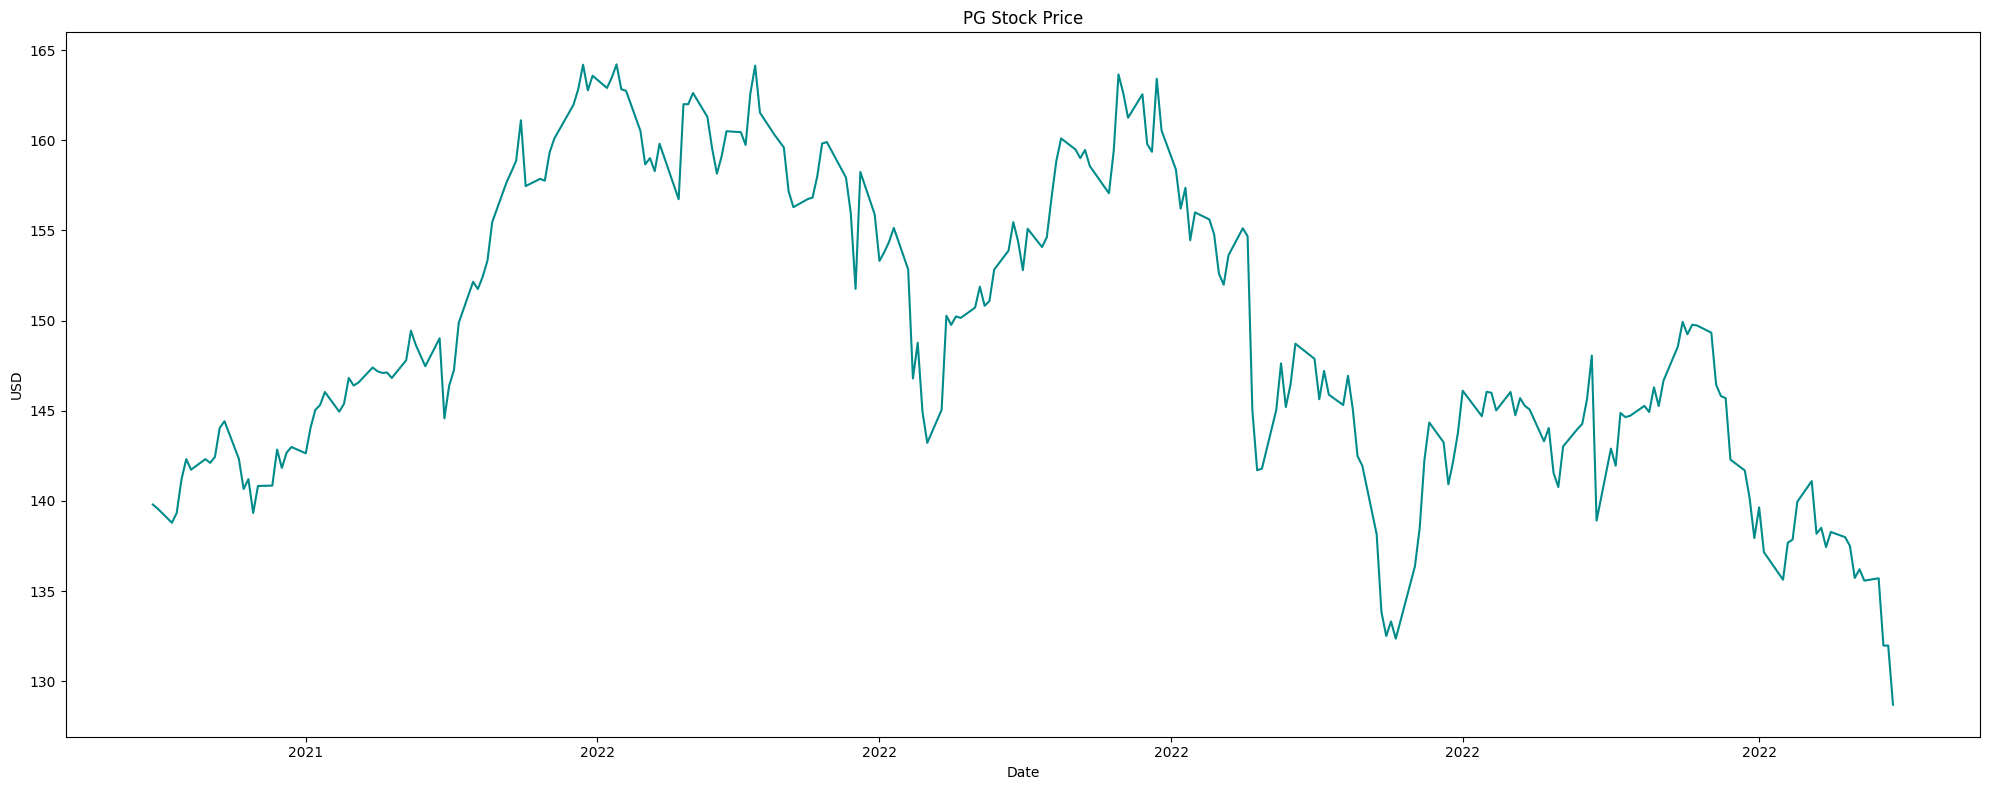

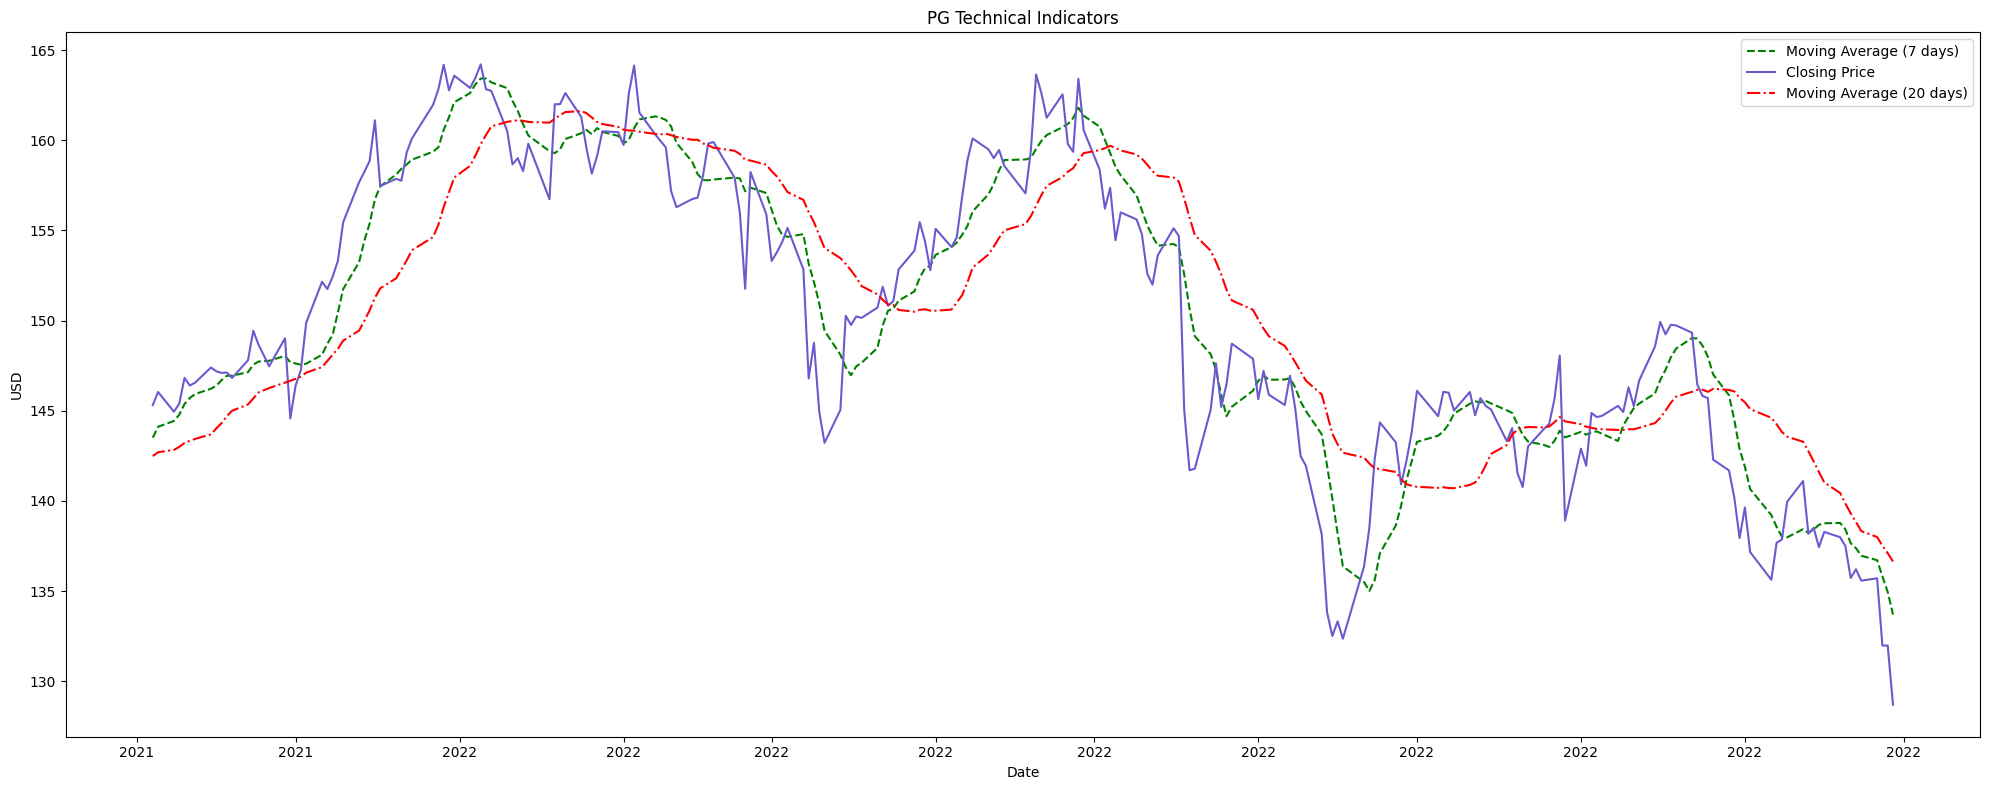

(227, 13)
X_train shape (190, 4, 13)
y_train shape (190, 1)
yc_train shape (190, 4, 1)
X_test shape (33, 4, 13)
y_test shape (33, 1)
yc_test shape (33, 4, 1)
Input dimension 4
Feature dimension 13
Output dimension 1
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 4, 512)            1077248   
                                                                 
 lstm_20 (LSTM)              (None, 4, 256)            787456    
                                                                 
 dense_40 (Dense)            (None, 4, 128)            32896     
                                                                 
 dense_41 (Dense)            (None, 4, 64)             8256      
                                                                 
 dense_42 (Dense)            (None, 4, 32)             2080      
                                   

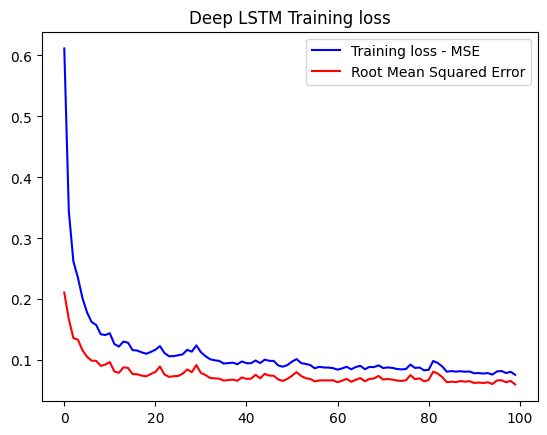

2/2 [==============================] - 1s 18ms/step
the test RMSE for Stock PG is 2.2960100065501217


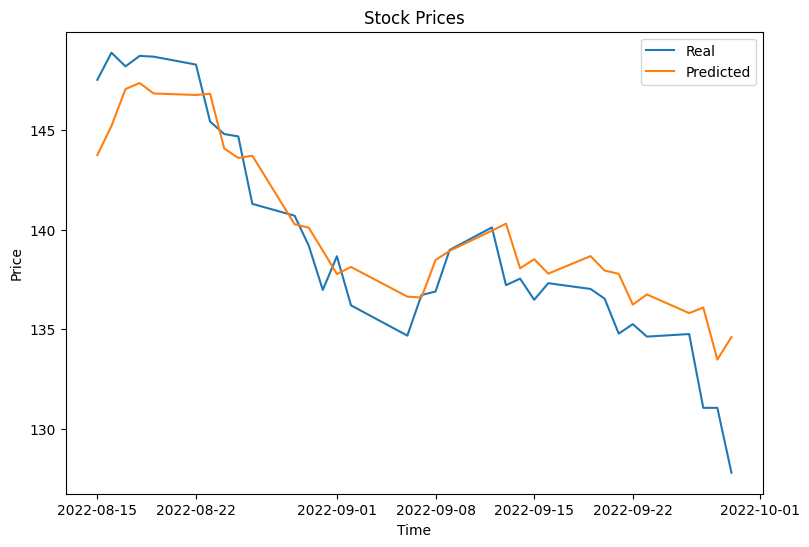

In [ ]:
X, y, date = clean_data(all_tweets, all_stocks, 'PG')
X_train, y_train, yc_train, X_test, y_test, y_scaler, input_dim, feature_size, output_dim = data_preprocess(X, y, days_to_consider, days_to_predict)

#
deep_model = make_deep_LSTM_model(input_dim, feature_size, output_dim)
print(deep_model.summary())

#Defining Optimizers
optimizeAdam=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
optimizeRMS=tf.keras.optimizers.RMSprop()
optimizeSGD =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
optimizeSGD1 =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

#Evaluation metric
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
      return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# Compile & Fit
#single_step_model.compile(optimizer=optimizeAdam, loss='mae',metrics=["mae"])
deep_model.compile(optimizer=optimizeAdam, loss=root_mean_squared_error,metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = deep_model.fit(x = X_train, y = y_train ,epochs=100, verbose = 0)
# evaluate the model on the training data
loss, accuracy = deep_model.evaluate(X_train, y_train)
print('Training loss:', loss)

#Plotting the training loss curve against the epochs
def plot_train_history(history, title):
  loss = history.history['loss']
  rmse = history.history['root_mean_squared_error']
  #mse = history.history['mse']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss - MSE')
  plt.plot(epochs, rmse, 'r', label='Root Mean Squared Error')
  #plt.plot(epochs, mse, 'r', label='Mean Squared Error')
  plt.title(title)
  plt.legend()

  plt.show()

plot_train_history(history, 'Deep LSTM Training loss')

#Testing and making Predictions
y_test_predicted = deep_model.predict(X_test)
real_y = y_scaler.inverse_transform(y_test)
predicted_y = y_scaler.inverse_transform(y_test_predicted)

#Printing the test RMSE
Test_RMSE = np.sqrt(mean_squared_error(real_y, predicted_y))
print("the test RMSE for Stock PG is",Test_RMSE)

#Plot the predictions
fig, ax = plt.subplots(figsize=(9,6))

# Plot the two arrays as lines on the same plot
ax.plot(date[X_train.shape[0] + days_to_consider :], real_y, label='Real')
ax.plot(date[X_train.shape[0] + days_to_consider :], predicted_y, label='Predicted')

# Set the x-axis and y-axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Price')

# Add a title to the plot
ax.set_title('Stock Prices')

# Add a legend to the plot
ax.legend()

# Show the plot
plt.show()


## Shallow LSTM

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.11 µs


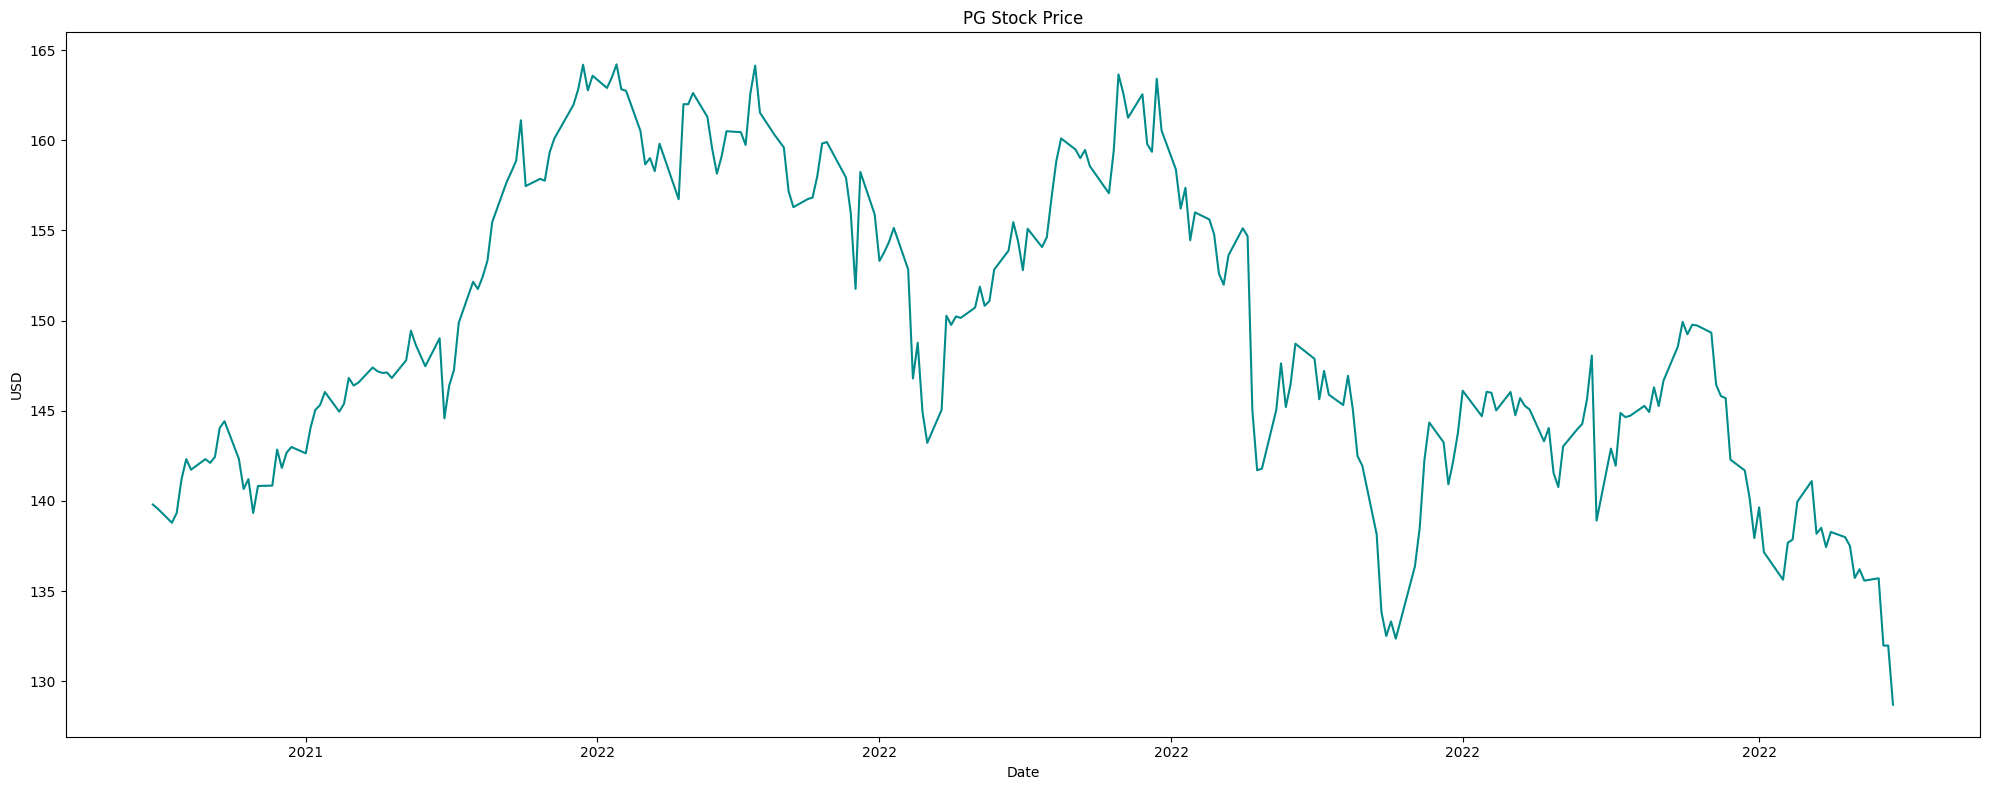

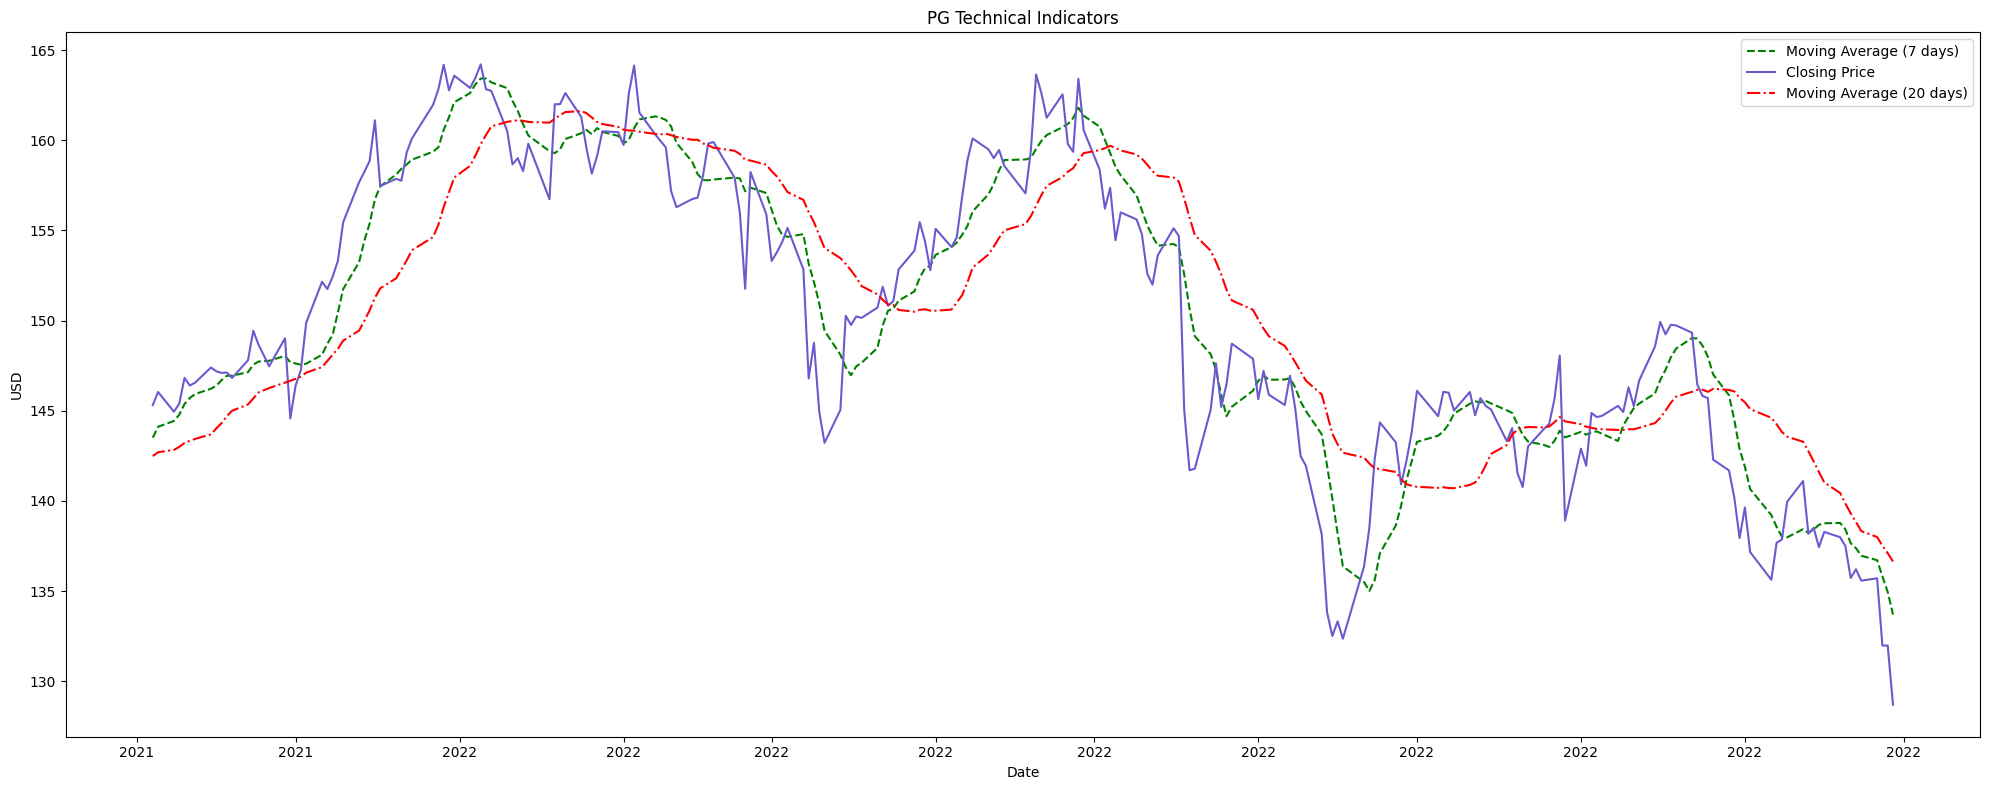

(227, 13)
X_train shape (190, 4, 13)
y_train shape (190, 1)
yc_train shape (190, 4, 1)
X_test shape (33, 4, 13)
y_test shape (33, 1)
yc_test shape (33, 4, 1)
Input dimension 4
Feature dimension 13
Output dimension 1
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 4, 64)             19968     
                                                                 
 flatten_13 (Flatten)        (None, 256)               0         
                                                                 
 dense_45 (Dense)            (None, 1)                 257       
                                                                 
Total params: 20,225
Trainable params: 20,225
Non-trainable params: 0
_________________________________________________________________
None
6/6 [==============================] - 0s 5ms/step - loss: 0.0994 - root_mean_squared_error:

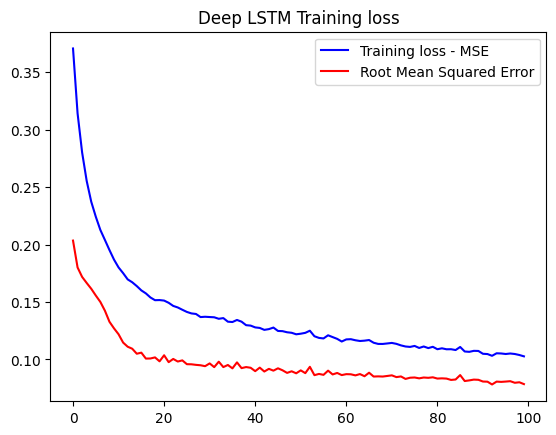

2/2 [==============================] - 0s 6ms/step
the test RMSE for Stock PG is 3.072822378273713


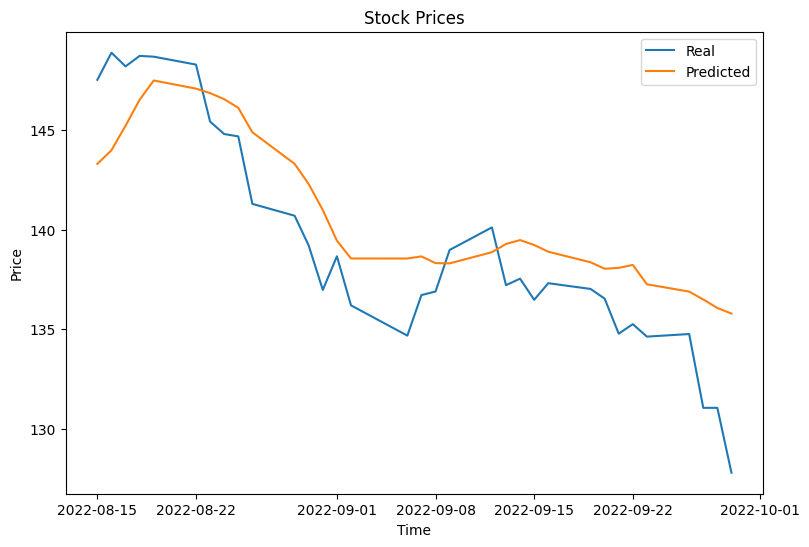

In [ ]:
X, y, date = clean_data(all_tweets, all_stocks, 'PG')
X_train, y_train, yc_train, X_test, y_test, y_scaler, input_dim, feature_size, output_dim = data_preprocess(X, y, days_to_consider, days_to_predict)

#
shallow_model = make_LSTM_model(input_dim, feature_size, output_dim)
print(shallow_model.summary())

#Defining Optimizers
optimizeAdam=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
optimizeRMS=tf.keras.optimizers.RMSprop()
optimizeSGD =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
optimizeSGD1 =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

#Evaluation metric
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
      return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# Compile & Fit
#single_step_model.compile(optimizer=optimizeAdam, loss='mae',metrics=["mae"])
shallow_model.compile(optimizer=optimizeAdam, loss=root_mean_squared_error,metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = shallow_model.fit(x = X_train, y = y_train ,epochs=100, verbose = 0)
# evaluate the model on the training data
loss, accuracy = shallow_model.evaluate(X_train, y_train)
print('Training loss:', loss)

#Plotting the training loss curve against the epochs
def plot_train_history(history, title):
  loss = history.history['loss']
  rmse = history.history['root_mean_squared_error']
  #mse = history.history['mse']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss - MSE')
  plt.plot(epochs, rmse, 'r', label='Root Mean Squared Error')
  #plt.plot(epochs, mse, 'r', label='Mean Squared Error')
  plt.title(title)
  plt.legend()

  plt.show()

plot_train_history(history, 'Deep LSTM Training loss')

#Testing and making Predictions
y_test_predicted = shallow_model.predict(X_test)
real_y = y_scaler.inverse_transform(y_test)
predicted_y = y_scaler.inverse_transform(y_test_predicted)

#Printing the test RMSE
Test_RMSE = np.sqrt(mean_squared_error(real_y, predicted_y))
print("the test RMSE for Stock PG is",Test_RMSE)

#Plot the predictions
fig, ax = plt.subplots(figsize=(9,6))

# Plot the two arrays as lines on the same plot
ax.plot(date[X_train.shape[0] + days_to_consider :], real_y, label='Real')
ax.plot(date[X_train.shape[0] + days_to_consider :], predicted_y, label='Predicted')

# Set the x-axis and y-axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Price')

# Add a title to the plot
ax.set_title('Stock Prices')

# Add a legend to the plot
ax.legend()

# Show the plot
plt.show()


# Stock Prediction for 'MSFT'

## Deep LSTM

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


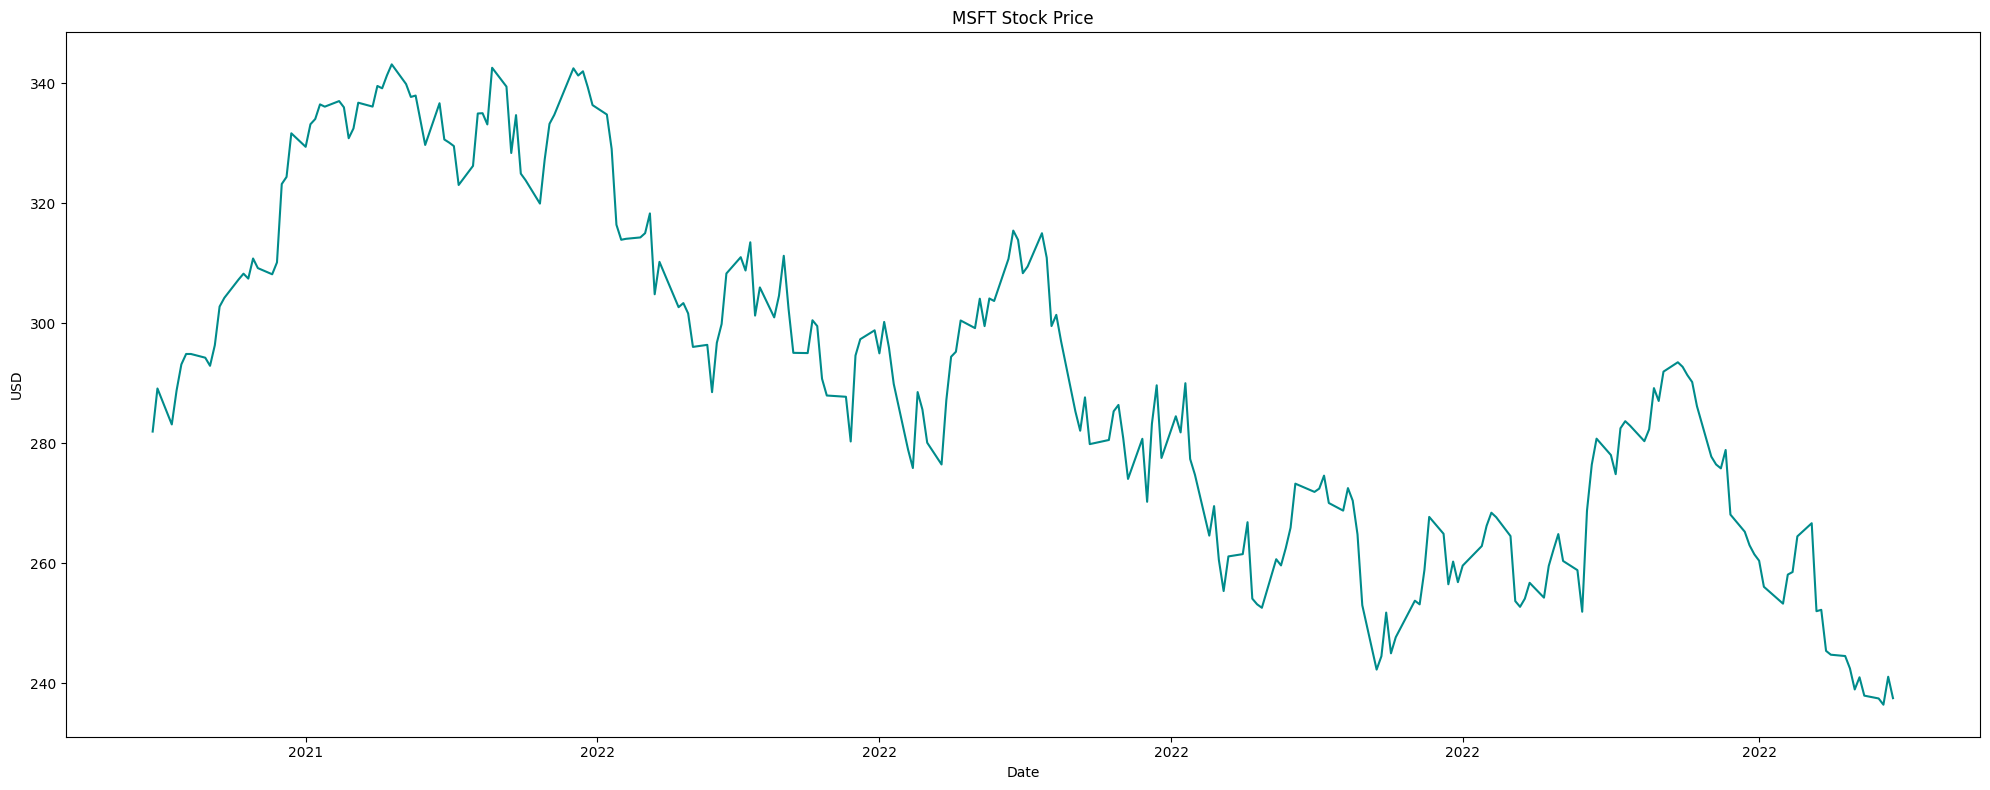

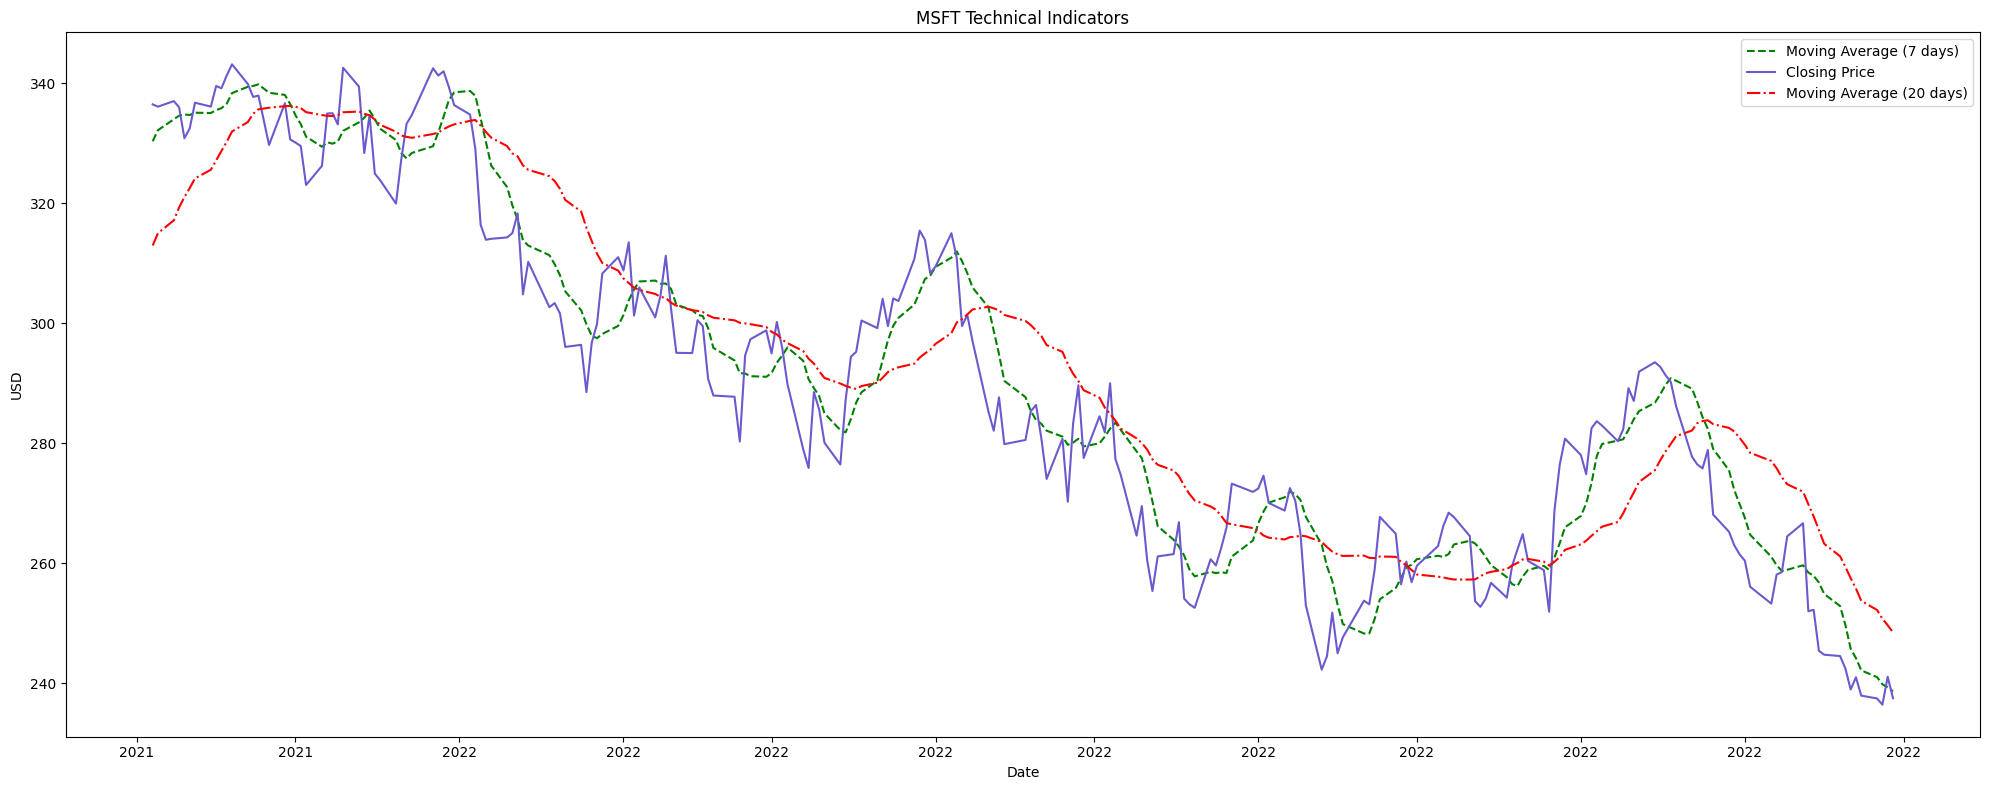

(227, 13)
X_train shape (190, 4, 13)
y_train shape (190, 1)
yc_train shape (190, 4, 1)
X_test shape (33, 4, 13)
y_test shape (33, 1)
yc_test shape (33, 4, 1)
Input dimension 4
Feature dimension 13
Output dimension 1
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 4, 512)            1077248   
                                                                 
 lstm_23 (LSTM)              (None, 4, 256)            787456    
                                                                 
 dense_46 (Dense)            (None, 4, 128)            32896     
                                                                 
 dense_47 (Dense)            (None, 4, 64)             8256      
                                                                 
 dense_48 (Dense)            (None, 4, 32)             2080      
                                   

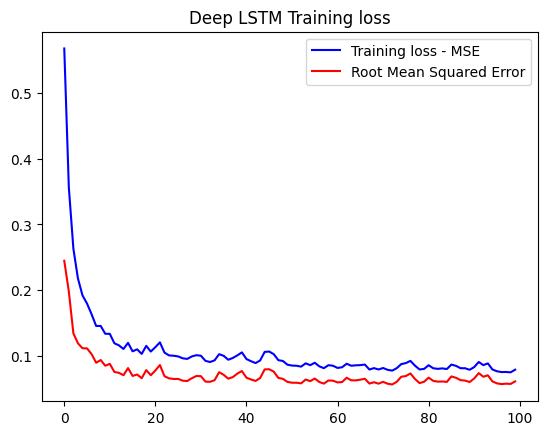

2/2 [==============================] - 1s 14ms/step
the test RMSE for Stock MSFT is 6.303697554311628


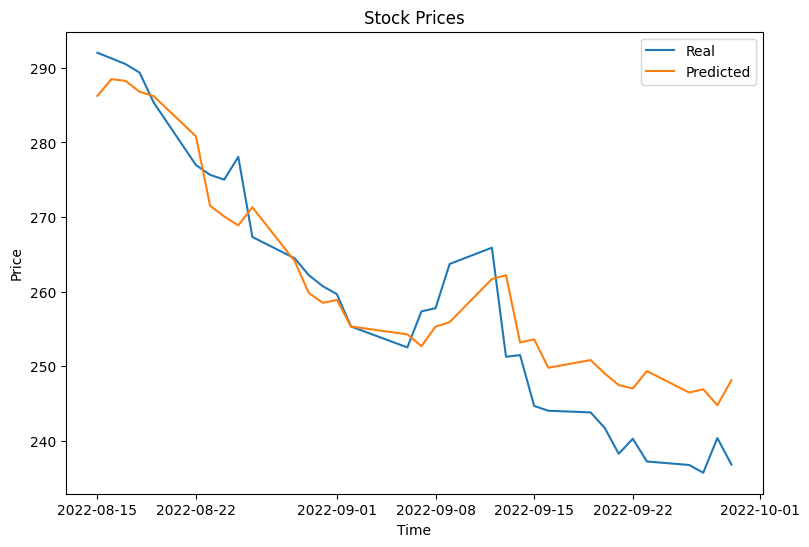

In [ ]:
X, y, date = clean_data(all_tweets, all_stocks, 'MSFT')
X_train, y_train, yc_train, X_test, y_test, y_scaler, input_dim, feature_size, output_dim = data_preprocess(X, y, days_to_consider, days_to_predict)

#
deep_model = make_deep_LSTM_model(input_dim, feature_size, output_dim)
print(deep_model.summary())

#Defining Optimizers
optimizeAdam=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
optimizeRMS=tf.keras.optimizers.RMSprop()
optimizeSGD =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
optimizeSGD1 =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

#Evaluation metric
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
      return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# Compile & Fit
#single_step_model.compile(optimizer=optimizeAdam, loss='mae',metrics=["mae"])
deep_model.compile(optimizer=optimizeAdam, loss=root_mean_squared_error,metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = deep_model.fit(x = X_train, y = y_train ,epochs=100, verbose = 0)
# evaluate the model on the training data
loss, accuracy = deep_model.evaluate(X_train, y_train)
print('Training loss:', loss)

#Plotting the training loss curve against the epochs
def plot_train_history(history, title):
  loss = history.history['loss']
  rmse = history.history['root_mean_squared_error']
  #mse = history.history['mse']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss - MSE')
  plt.plot(epochs, rmse, 'r', label='Root Mean Squared Error')
  #plt.plot(epochs, mse, 'r', label='Mean Squared Error')
  plt.title(title)
  plt.legend()

  plt.show()

plot_train_history(history, 'Deep LSTM Training loss')

#Testing and making Predictions
y_test_predicted = deep_model.predict(X_test)
real_y = y_scaler.inverse_transform(y_test)
predicted_y = y_scaler.inverse_transform(y_test_predicted)

#Printing the test RMSE
Test_RMSE = np.sqrt(mean_squared_error(real_y, predicted_y))
print("the test RMSE for Stock MSFT is",Test_RMSE)

#Plot the predictions
fig, ax = plt.subplots(figsize=(9,6))

# Plot the two arrays as lines on the same plot
ax.plot(date[X_train.shape[0] + days_to_consider :], real_y, label='Real')
ax.plot(date[X_train.shape[0] + days_to_consider :], predicted_y, label='Predicted')

# Set the x-axis and y-axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Price')

# Add a title to the plot
ax.set_title('Stock Prices')

# Add a legend to the plot
ax.legend()

# Show the plot
plt.show()


## Shallow LSTM

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


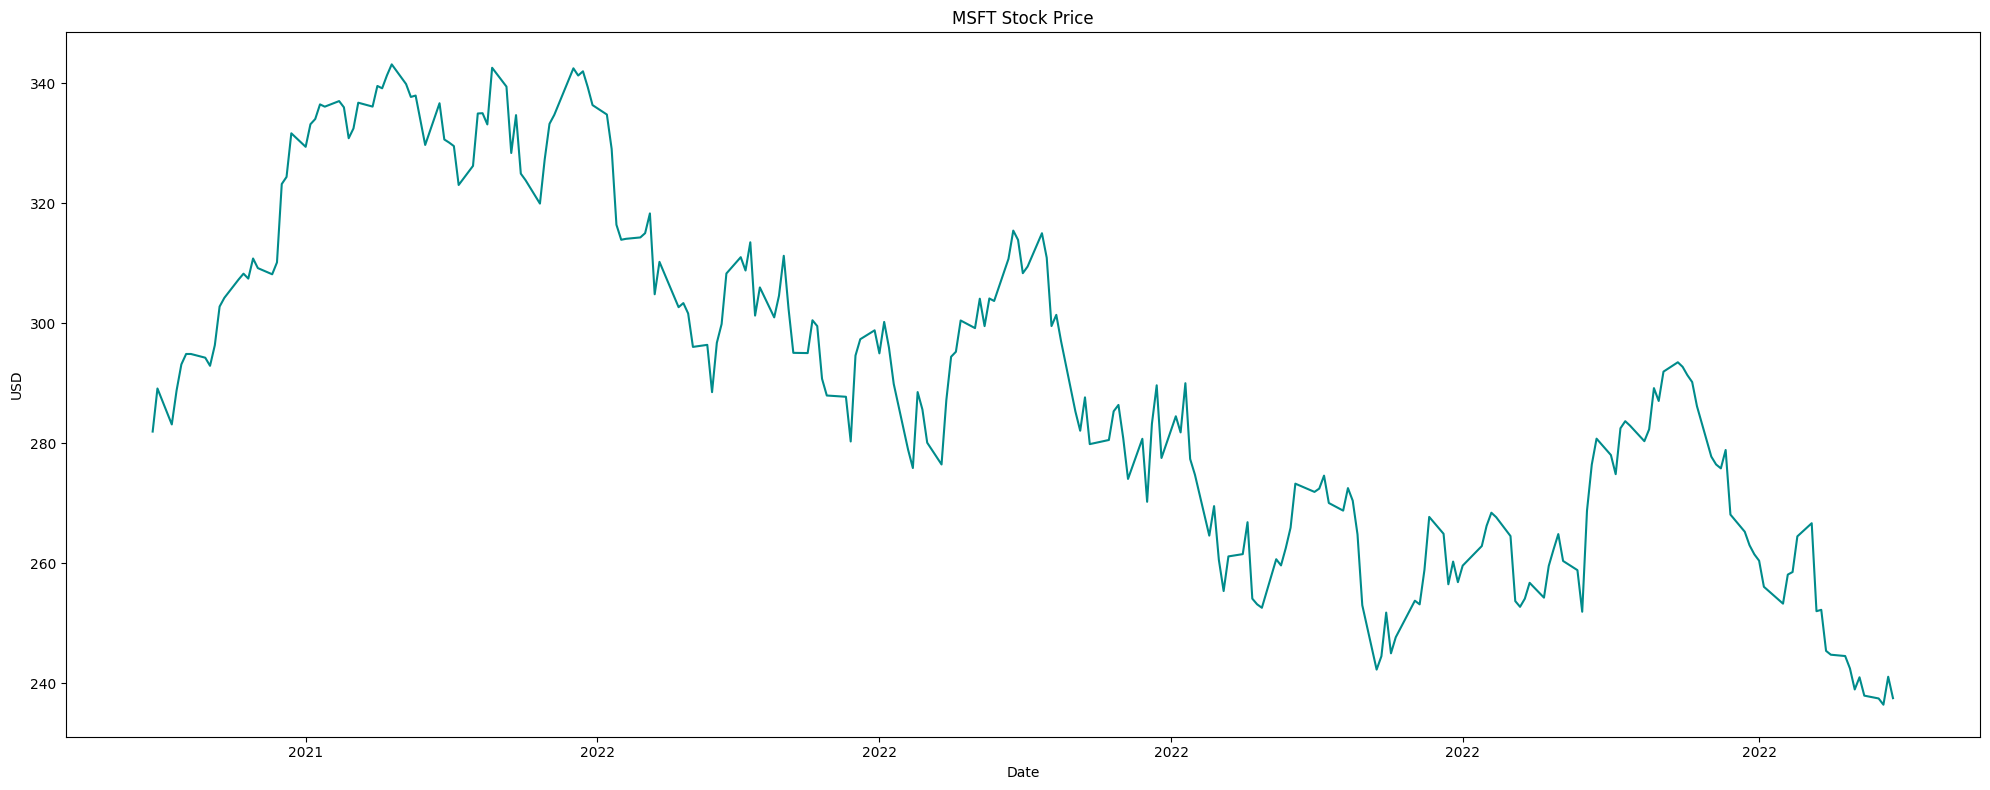

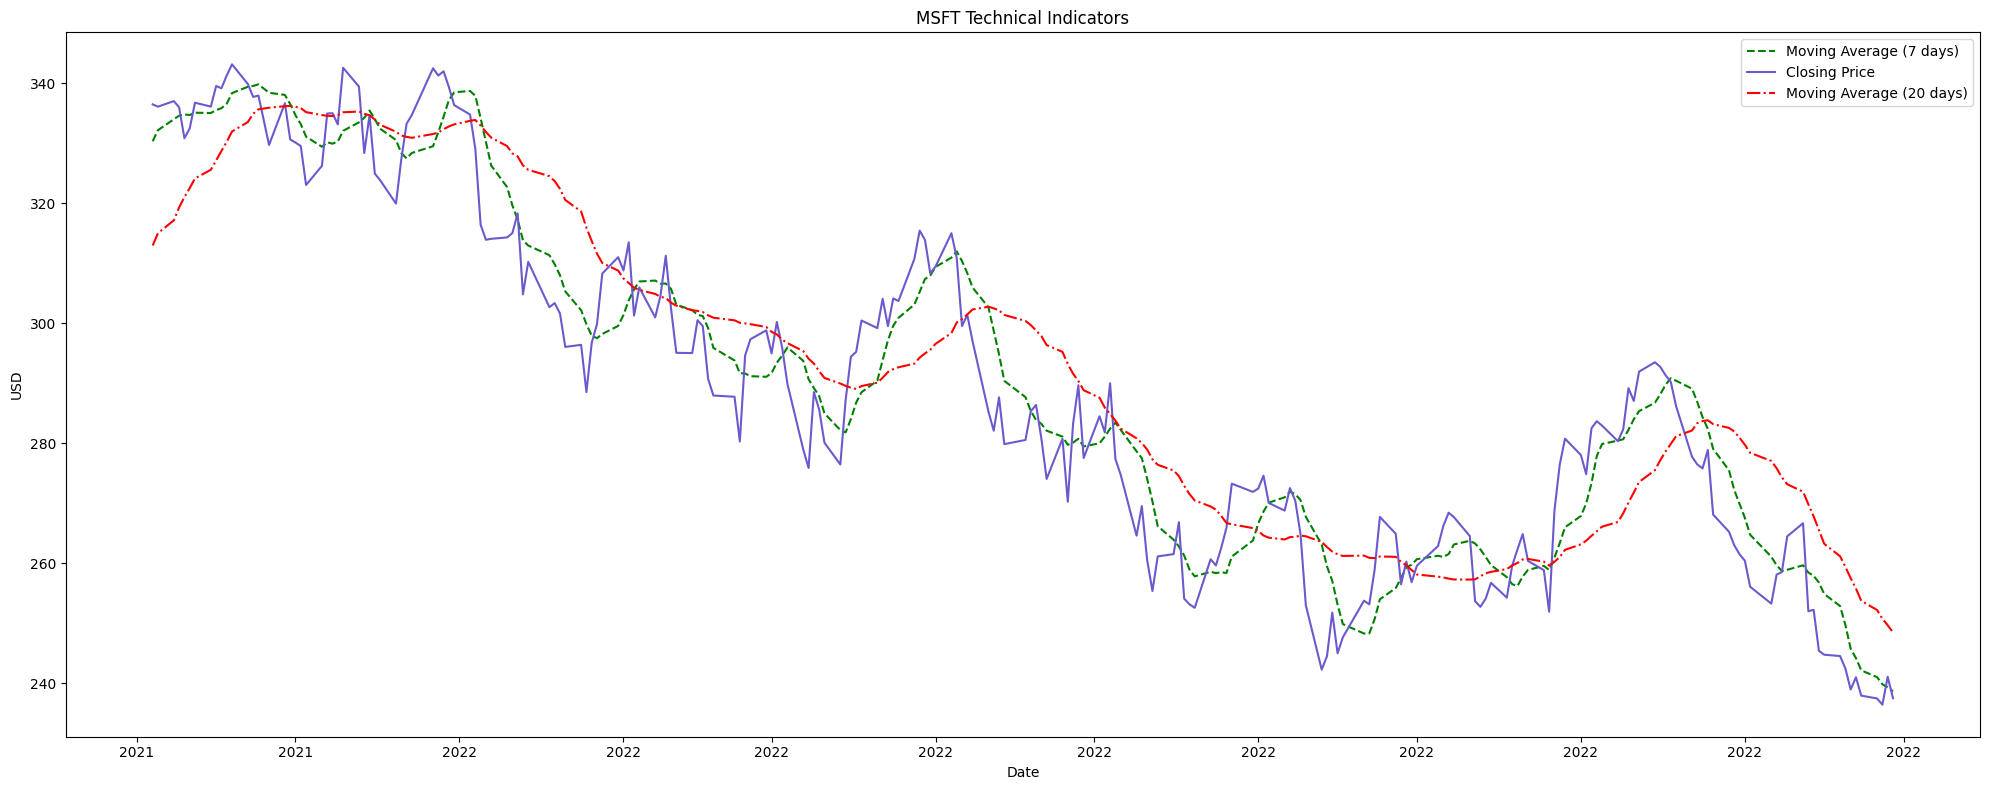

(227, 13)
X_train shape (190, 4, 13)
y_train shape (190, 1)
yc_train shape (190, 4, 1)
X_test shape (33, 4, 13)
y_test shape (33, 1)
yc_test shape (33, 4, 1)
Input dimension 4
Feature dimension 13
Output dimension 1
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 4, 64)             19968     
                                                                 
 flatten_15 (Flatten)        (None, 256)               0         
                                                                 
 dense_51 (Dense)            (None, 1)                 257       
                                                                 
Total params: 20,225
Trainable params: 20,225
Non-trainable params: 0
_________________________________________________________________
None
6/6 [==============================] - 0s 5ms/step - loss: 0.0952 - root_mean_squared_error:

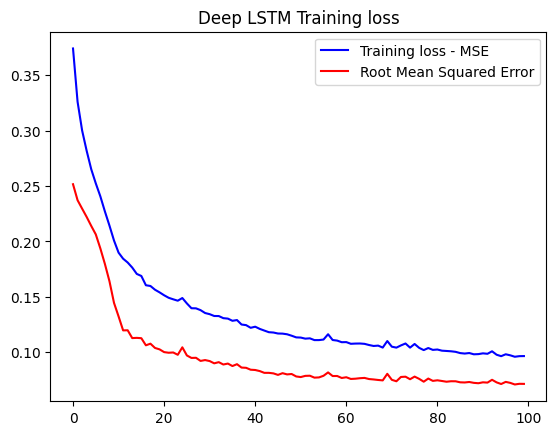

2/2 [==============================] - 0s 6ms/step
the test RMSE for Stock MSFT is 10.137585021675267


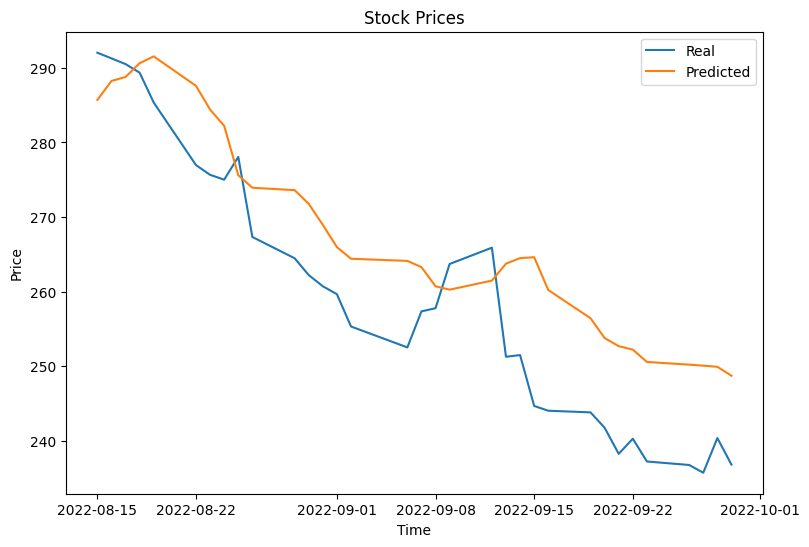

In [ ]:
X, y, date = clean_data(all_tweets, all_stocks, 'MSFT')
X_train, y_train, yc_train, X_test, y_test, y_scaler, input_dim, feature_size, output_dim = data_preprocess(X, y, days_to_consider, days_to_predict)

#
shallow_model = make_LSTM_model(input_dim, feature_size, output_dim)
print(shallow_model.summary())

#Defining Optimizers
optimizeAdam=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
optimizeRMS=tf.keras.optimizers.RMSprop()
optimizeSGD =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
optimizeSGD1 =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

#Evaluation metric
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
      return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# Compile & Fit
#single_step_model.compile(optimizer=optimizeAdam, loss='mae',metrics=["mae"])
shallow_model.compile(optimizer=optimizeAdam, loss=root_mean_squared_error,metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = shallow_model.fit(x = X_train, y = y_train ,epochs=100, verbose = 0)
# evaluate the model on the training data
loss, accuracy = shallow_model.evaluate(X_train, y_train)
print('Training loss:', loss)

#Plotting the training loss curve against the epochs
def plot_train_history(history, title):
  loss = history.history['loss']
  rmse = history.history['root_mean_squared_error']
  #mse = history.history['mse']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss - MSE')
  plt.plot(epochs, rmse, 'r', label='Root Mean Squared Error')
  #plt.plot(epochs, mse, 'r', label='Mean Squared Error')
  plt.title(title)
  plt.legend()

  plt.show()

plot_train_history(history, 'Deep LSTM Training loss')

#Testing and making Predictions
y_test_predicted = shallow_model.predict(X_test)
real_y = y_scaler.inverse_transform(y_test)
predicted_y = y_scaler.inverse_transform(y_test_predicted)

#Printing the test RMSE
Test_RMSE = np.sqrt(mean_squared_error(real_y, predicted_y))
print("the test RMSE for Stock MSFT is",Test_RMSE)

#Plot the predictions
fig, ax = plt.subplots(figsize=(9,6))

# Plot the two arrays as lines on the same plot
ax.plot(date[X_train.shape[0] + days_to_consider :], real_y, label='Real')
ax.plot(date[X_train.shape[0] + days_to_consider :], predicted_y, label='Predicted')

# Set the x-axis and y-axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Price')

# Add a title to the plot
ax.set_title('Stock Prices')

# Add a legend to the plot
ax.legend()

# Show the plot
plt.show()


# Stock Prediction for 'NIO'

## Deep LSTM

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.44 µs


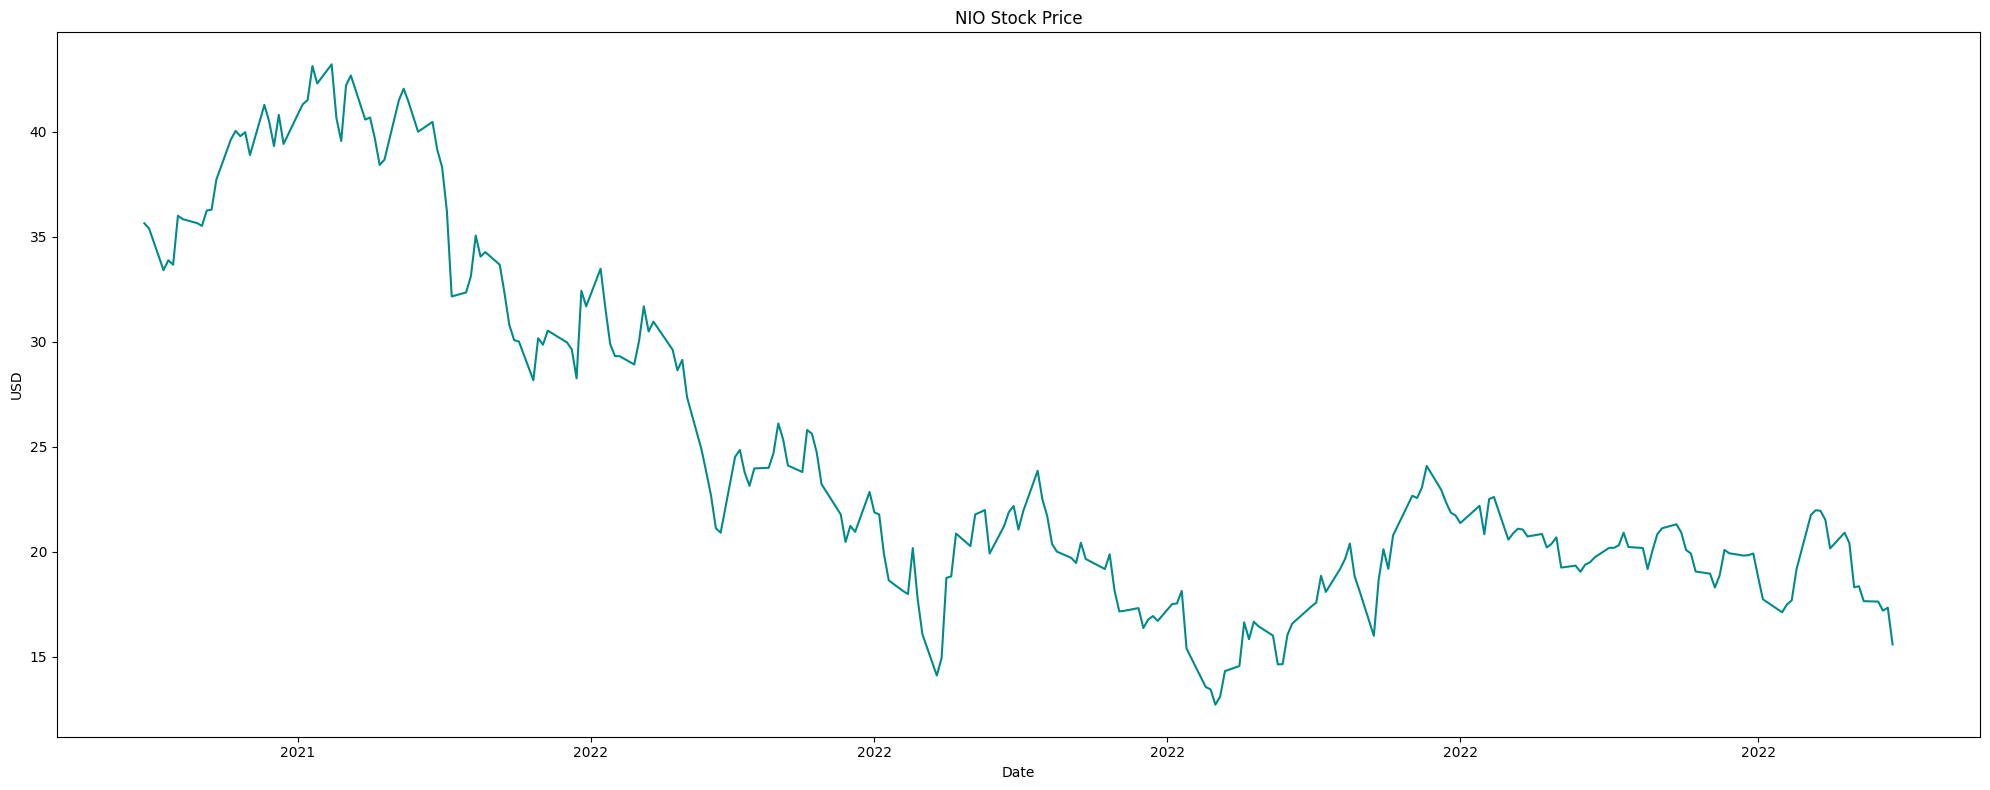

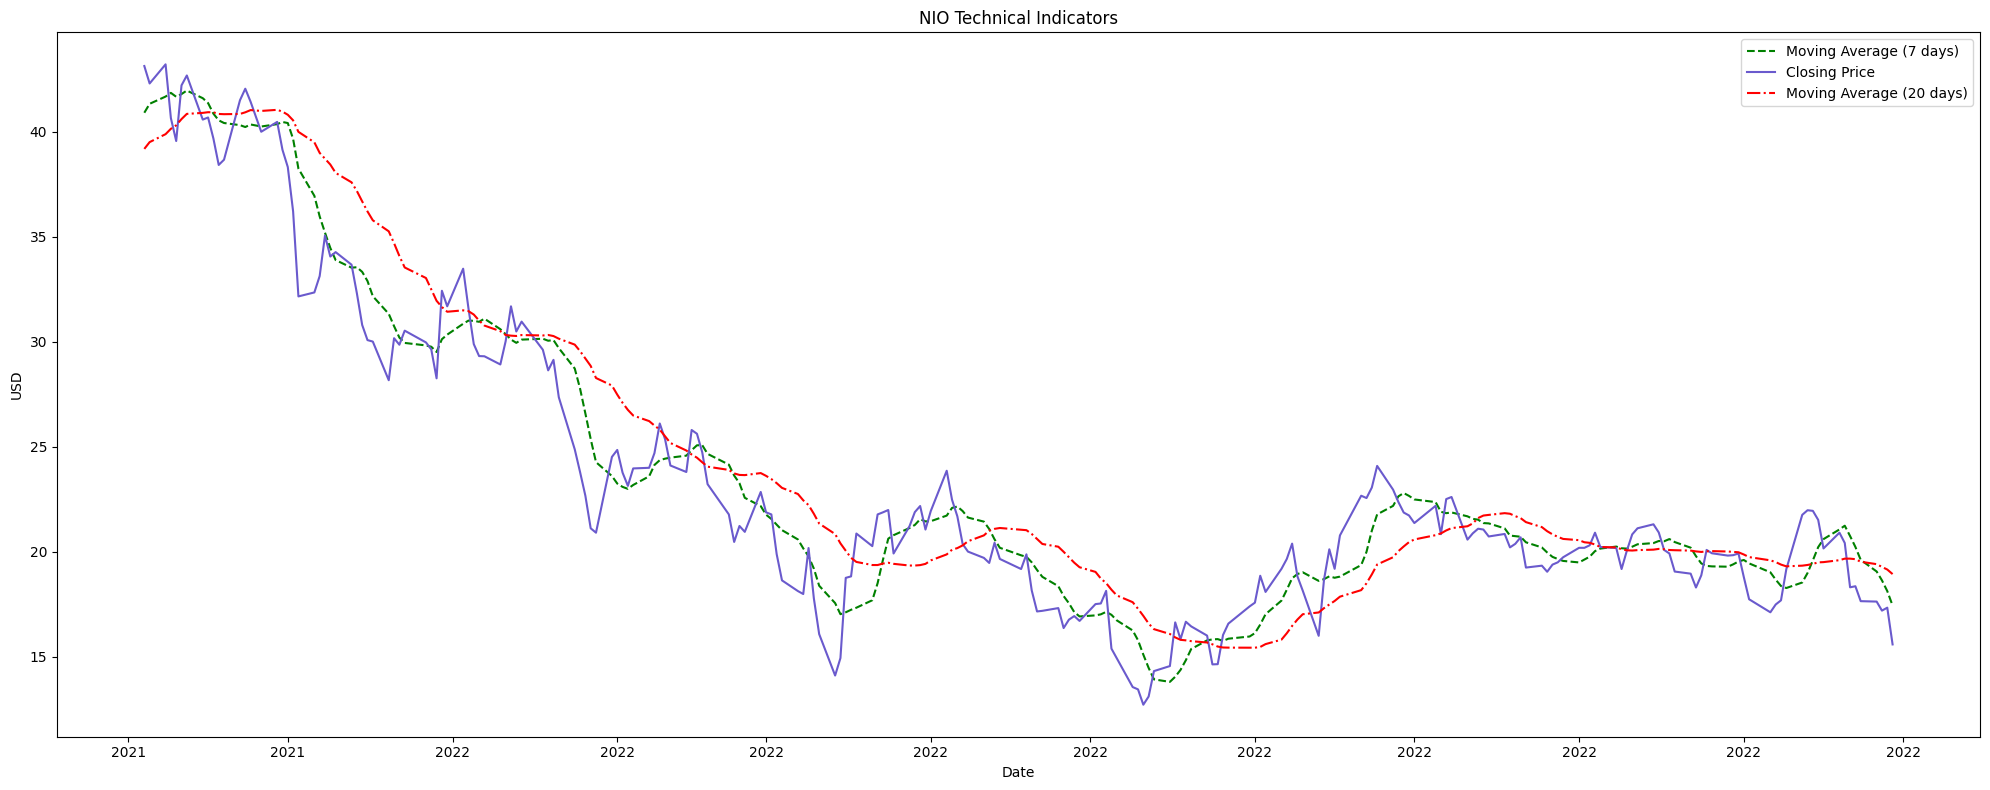

(227, 13)
X_train shape (190, 4, 13)
y_train shape (190, 1)
yc_train shape (190, 4, 1)
X_test shape (33, 4, 13)
y_test shape (33, 1)
yc_test shape (33, 4, 1)
Input dimension 4
Feature dimension 13
Output dimension 1
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 4, 512)            1077248   
                                                                 
 lstm_26 (LSTM)              (None, 4, 256)            787456    
                                                                 
 dense_52 (Dense)            (None, 4, 128)            32896     
                                                                 
 dense_53 (Dense)            (None, 4, 64)             8256      
                                                                 
 dense_54 (Dense)            (None, 4, 32)             2080      
                                   

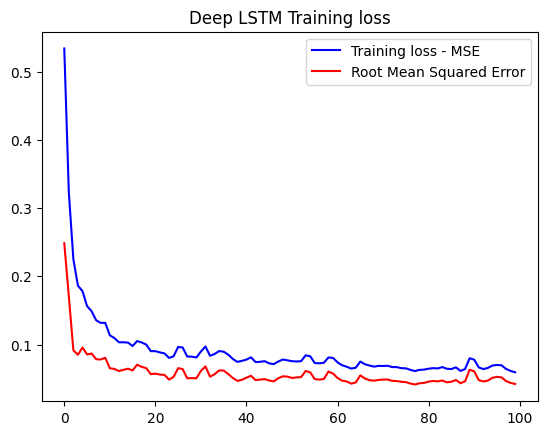

2/2 [==============================] - 2s 11ms/step
the test RMSE for Stock NIO is 0.9762570436826088


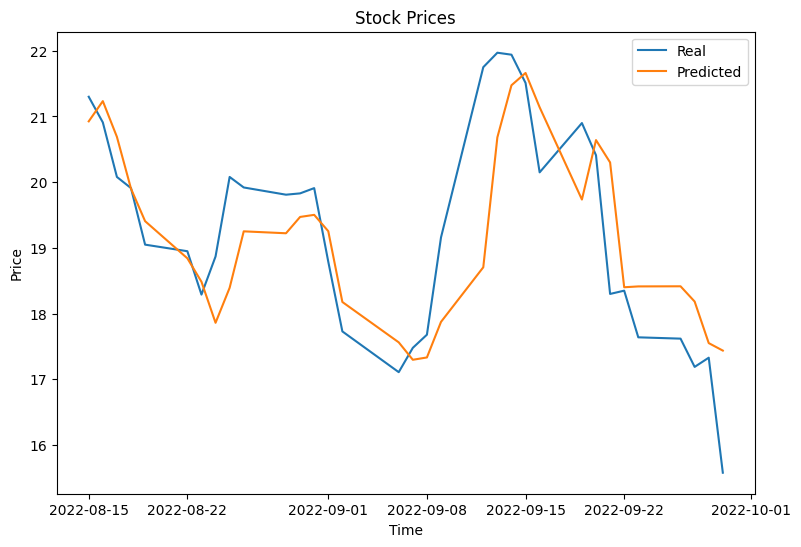

In [ ]:
X, y, date = clean_data(all_tweets, all_stocks, 'NIO')
X_train, y_train, yc_train, X_test, y_test, y_scaler, input_dim, feature_size, output_dim = data_preprocess(X, y, days_to_consider, days_to_predict)

#
deep_model = make_deep_LSTM_model(input_dim, feature_size, output_dim)
print(deep_model.summary())

#Defining Optimizers
optimizeAdam=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
optimizeRMS=tf.keras.optimizers.RMSprop()
optimizeSGD =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
optimizeSGD1 =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

#Evaluation metric
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
      return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# Compile & Fit
#single_step_model.compile(optimizer=optimizeAdam, loss='mae',metrics=["mae"])
deep_model.compile(optimizer=optimizeAdam, loss=root_mean_squared_error,metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = deep_model.fit(x = X_train, y = y_train ,epochs=100, verbose = 0)
# evaluate the model on the training data
loss, accuracy = deep_model.evaluate(X_train, y_train)
print('Training loss:', loss)

#Plotting the training loss curve against the epochs
def plot_train_history(history, title):
  loss = history.history['loss']
  rmse = history.history['root_mean_squared_error']
  #mse = history.history['mse']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss - MSE')
  plt.plot(epochs, rmse, 'r', label='Root Mean Squared Error')
  #plt.plot(epochs, mse, 'r', label='Mean Squared Error')
  plt.title(title)
  plt.legend()

  plt.show()

plot_train_history(history, 'Deep LSTM Training loss')

#Testing and making Predictions
y_test_predicted = deep_model.predict(X_test)
real_y = y_scaler.inverse_transform(y_test)
predicted_y = y_scaler.inverse_transform(y_test_predicted)

#Printing the test RMSE
Test_RMSE = np.sqrt(mean_squared_error(real_y, predicted_y))
print("the test RMSE for Stock NIO is",Test_RMSE)

#Plot the predictions
fig, ax = plt.subplots(figsize=(9,6))

# Plot the two arrays as lines on the same plot
ax.plot(date[X_train.shape[0] + days_to_consider :], real_y, label='Real')
ax.plot(date[X_train.shape[0] + days_to_consider :], predicted_y, label='Predicted')

# Set the x-axis and y-axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Price')

# Add a title to the plot
ax.set_title('Stock Prices')

# Add a legend to the plot
ax.legend()

# Show the plot
plt.show()


## Shallow LSTM

CPU times: user 0 ns, sys: 5 µs, total: 5 µs
Wall time: 8.58 µs


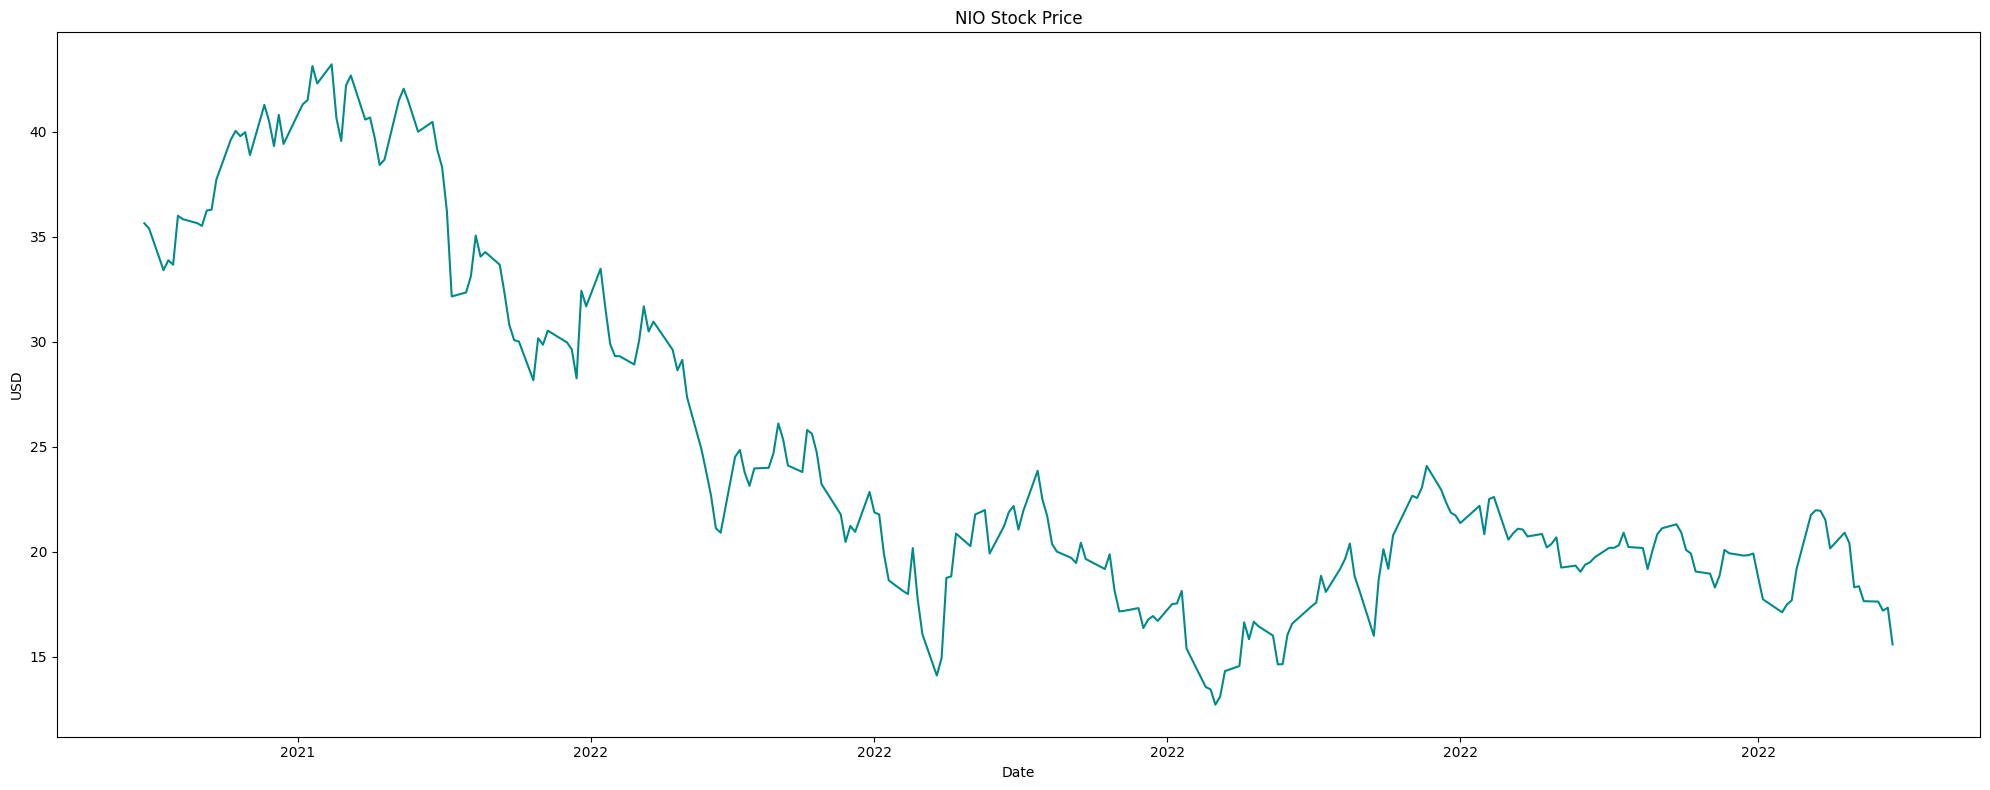

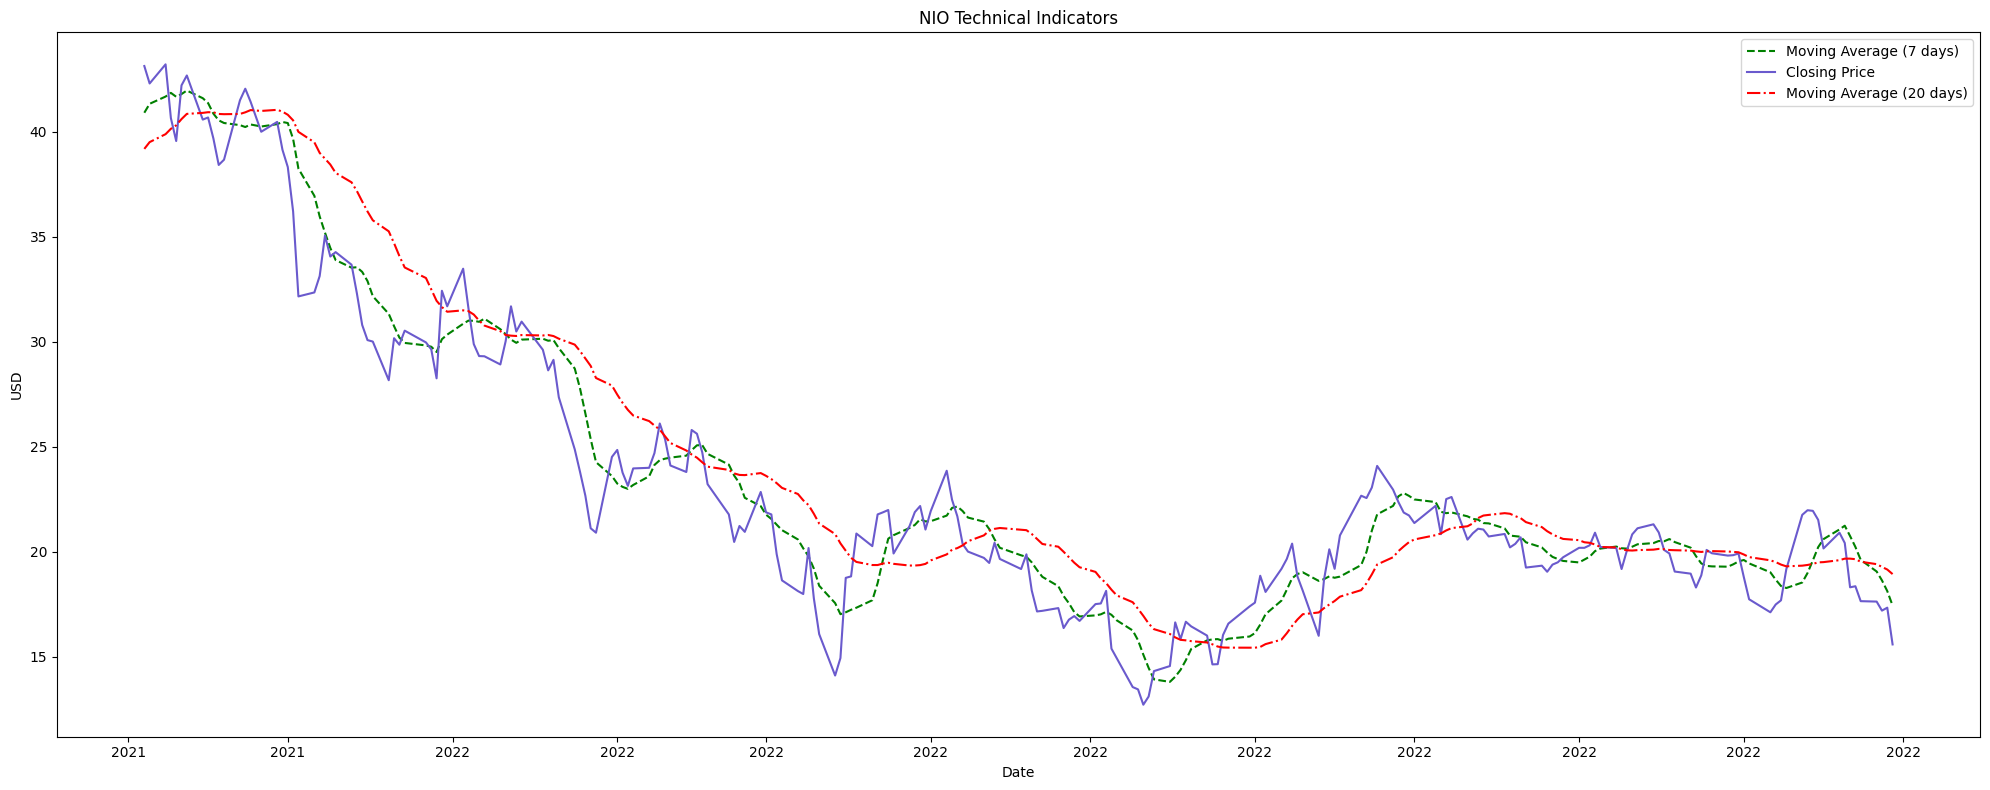

(227, 13)
X_train shape (190, 4, 13)
y_train shape (190, 1)
yc_train shape (190, 4, 1)
X_test shape (33, 4, 13)
y_test shape (33, 1)
yc_test shape (33, 4, 1)
Input dimension 4
Feature dimension 13
Output dimension 1
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 4, 64)             19968     
                                                                 
 flatten_17 (Flatten)        (None, 256)               0         
                                                                 
 dense_57 (Dense)            (None, 1)                 257       
                                                                 
Total params: 20,225
Trainable params: 20,225
Non-trainable params: 0
_________________________________________________________________
None
6/6 [==============================] - 0s 6ms/step - loss: 0.0792 - root_mean_squared_error:

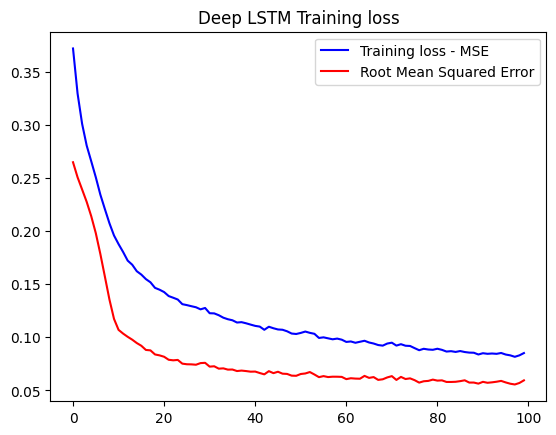

2/2 [==============================] - 0s 9ms/step
the test RMSE for Stock PG is 1.5299804120796212


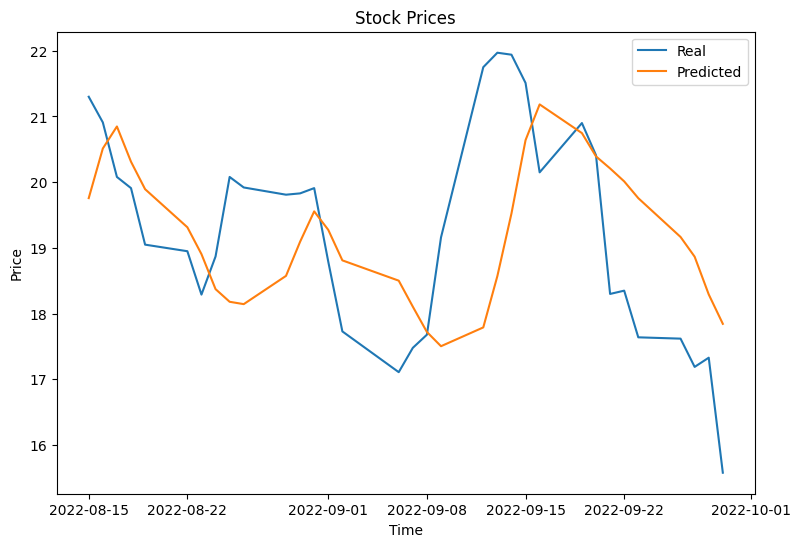

In [ ]:
X, y, date = clean_data(all_tweets, all_stocks, 'NIO')
X_train, y_train, yc_train, X_test, y_test, y_scaler, input_dim, feature_size, output_dim = data_preprocess(X, y, days_to_consider, days_to_predict)

#
shallow_model = make_LSTM_model(input_dim, feature_size, output_dim)
print(shallow_model.summary())

#Defining Optimizers
optimizeAdam=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
optimizeRMS=tf.keras.optimizers.RMSprop()
optimizeSGD =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
optimizeSGD1 =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

#Evaluation metric
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
      return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# Compile & Fit
#single_step_model.compile(optimizer=optimizeAdam, loss='mae',metrics=["mae"])
shallow_model.compile(optimizer=optimizeAdam, loss=root_mean_squared_error,metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = shallow_model.fit(x = X_train, y = y_train ,epochs=100, verbose = 0)
# evaluate the model on the training data
loss, accuracy = shallow_model.evaluate(X_train, y_train)
print('Training loss:', loss)

#Plotting the training loss curve against the epochs
def plot_train_history(history, title):
  loss = history.history['loss']
  rmse = history.history['root_mean_squared_error']
  #mse = history.history['mse']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss - MSE')
  plt.plot(epochs, rmse, 'r', label='Root Mean Squared Error')
  #plt.plot(epochs, mse, 'r', label='Mean Squared Error')
  plt.title(title)
  plt.legend()

  plt.show()

plot_train_history(history, 'Deep LSTM Training loss')

#Testing and making Predictions
y_test_predicted = shallow_model.predict(X_test)
real_y = y_scaler.inverse_transform(y_test)
predicted_y = y_scaler.inverse_transform(y_test_predicted)

#Printing the test RMSE
Test_RMSE = np.sqrt(mean_squared_error(real_y, predicted_y))
print("the test RMSE for Stock PG is",Test_RMSE)

#Plot the predictions
fig, ax = plt.subplots(figsize=(9,6))

# Plot the two arrays as lines on the same plot
ax.plot(date[X_train.shape[0] + days_to_consider :], real_y, label='Real')
ax.plot(date[X_train.shape[0] + days_to_consider :], predicted_y, label='Predicted')

# Set the x-axis and y-axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Price')

# Add a title to the plot
ax.set_title('Stock Prices')

# Add a legend to the plot
ax.legend()

# Show the plot
plt.show()


# Stock Prediction for 'META'

## Deep LSTM

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


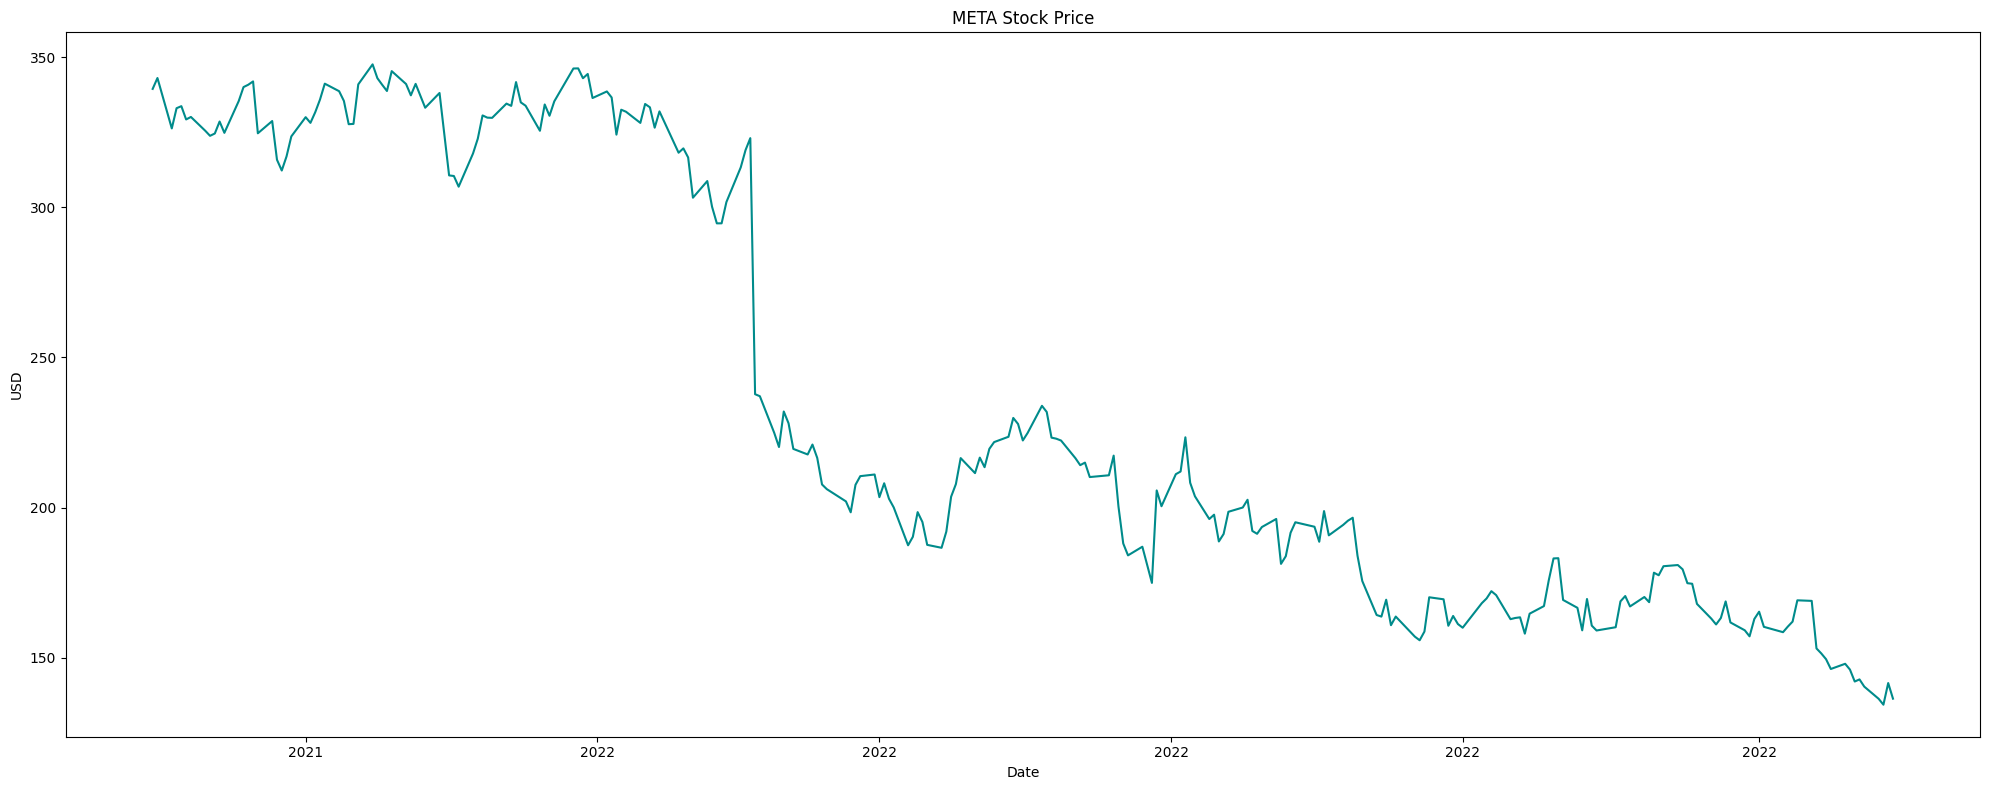

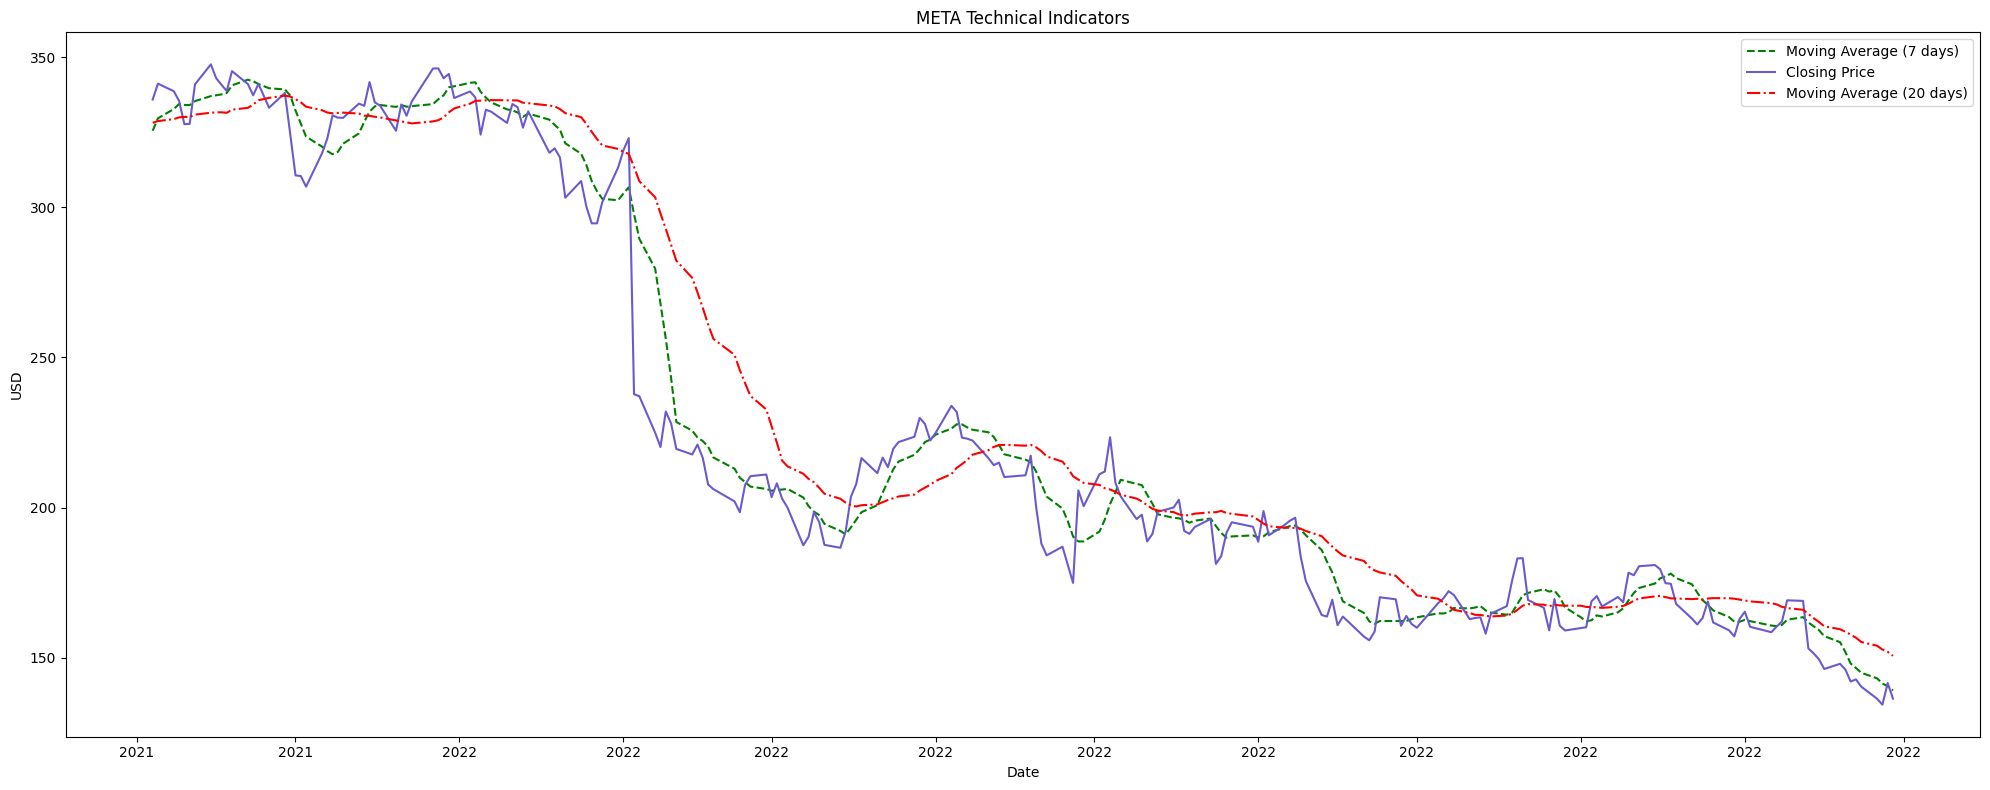

(227, 13)
X_train shape (190, 4, 13)
y_train shape (190, 1)
yc_train shape (190, 4, 1)
X_test shape (33, 4, 13)
y_test shape (33, 1)
yc_test shape (33, 4, 1)
Input dimension 4
Feature dimension 13
Output dimension 1
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 4, 512)            1077248   
                                                                 
 lstm_29 (LSTM)              (None, 4, 256)            787456    
                                                                 
 dense_58 (Dense)            (None, 4, 128)            32896     
                                                                 
 dense_59 (Dense)            (None, 4, 64)             8256      
                                                                 
 dense_60 (Dense)            (None, 4, 32)             2080      
                                   

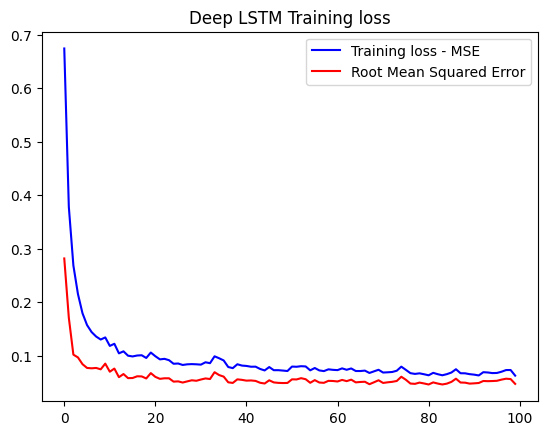

2/2 [==============================] - 1s 14ms/step
the test RMSE for Stock META is 12.302601921245492


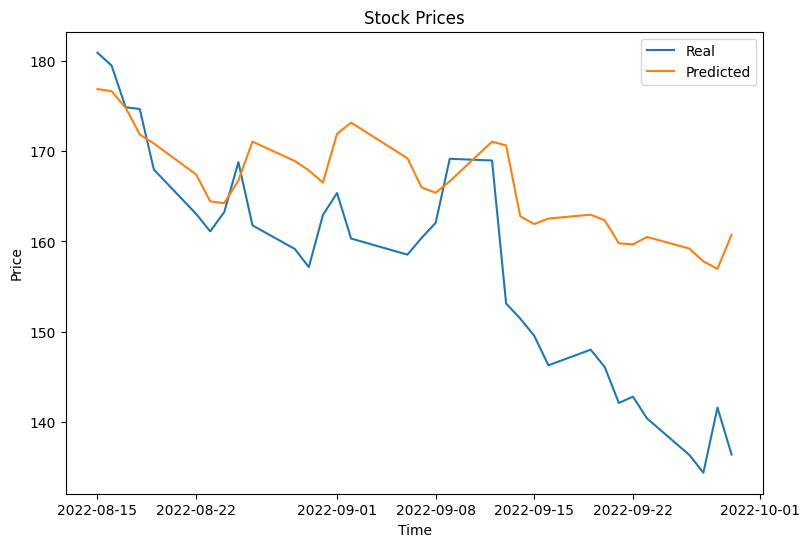

In [ ]:
X, y, date = clean_data(all_tweets, all_stocks, 'META')
X_train, y_train, yc_train, X_test, y_test, y_scaler, input_dim, feature_size, output_dim = data_preprocess(X, y, days_to_consider, days_to_predict)

#
deep_model = make_deep_LSTM_model(input_dim, feature_size, output_dim)
print(deep_model.summary())

#Defining Optimizers
optimizeAdam=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
optimizeRMS=tf.keras.optimizers.RMSprop()
optimizeSGD =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
optimizeSGD1 =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

#Evaluation metric
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
      return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# Compile & Fit
#single_step_model.compile(optimizer=optimizeAdam, loss='mae',metrics=["mae"])
deep_model.compile(optimizer=optimizeAdam, loss=root_mean_squared_error,metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = deep_model.fit(x = X_train, y = y_train ,epochs=100, verbose = 0)
# evaluate the model on the training data
loss, accuracy = deep_model.evaluate(X_train, y_train)
print('Training loss:', loss)

#Plotting the training loss curve against the epochs
def plot_train_history(history, title):
  loss = history.history['loss']
  rmse = history.history['root_mean_squared_error']
  #mse = history.history['mse']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss - MSE')
  plt.plot(epochs, rmse, 'r', label='Root Mean Squared Error')
  #plt.plot(epochs, mse, 'r', label='Mean Squared Error')
  plt.title(title)
  plt.legend()

  plt.show()

plot_train_history(history, 'Deep LSTM Training loss')

#Testing and making Predictions
y_test_predicted = deep_model.predict(X_test)
real_y = y_scaler.inverse_transform(y_test)
predicted_y = y_scaler.inverse_transform(y_test_predicted)

#Printing the test RMSE
Test_RMSE = np.sqrt(mean_squared_error(real_y, predicted_y))
print("the test RMSE for Stock META is",Test_RMSE)

#Plot the predictions
fig, ax = plt.subplots(figsize=(9,6))

# Plot the two arrays as lines on the same plot
ax.plot(date[X_train.shape[0] + days_to_consider :], real_y, label='Real')
ax.plot(date[X_train.shape[0] + days_to_consider :], predicted_y, label='Predicted')

# Set the x-axis and y-axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Price')

# Add a title to the plot
ax.set_title('Stock Prices')

# Add a legend to the plot
ax.legend()

# Show the plot
plt.show()


## Shallow LSTM

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


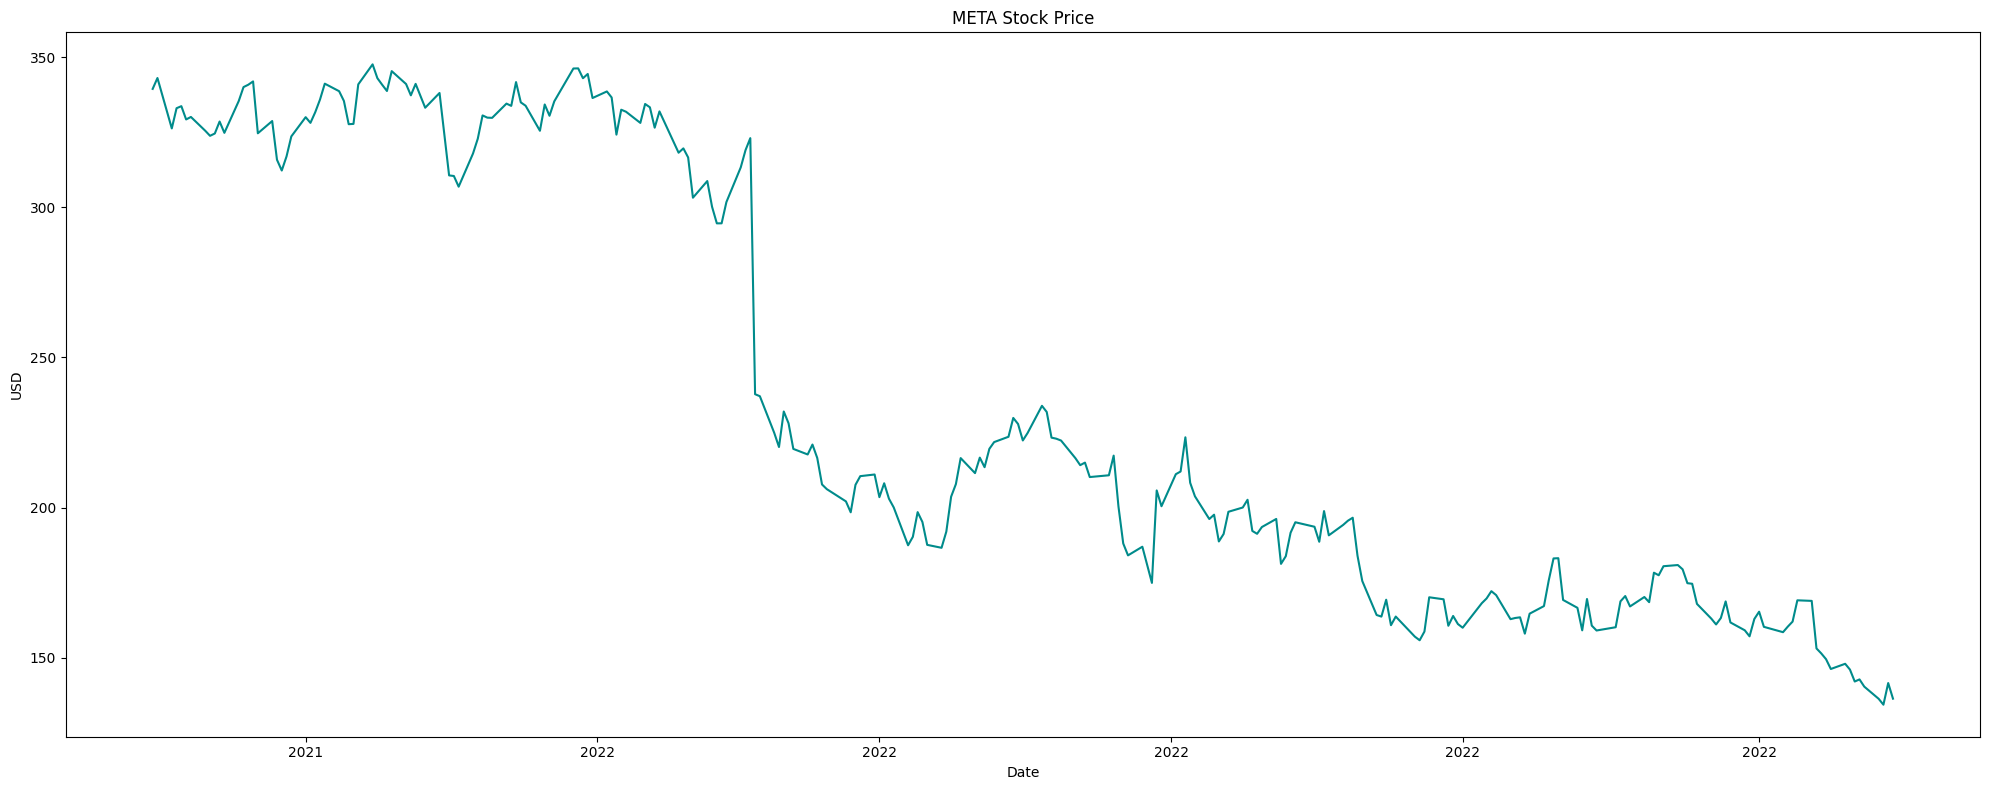

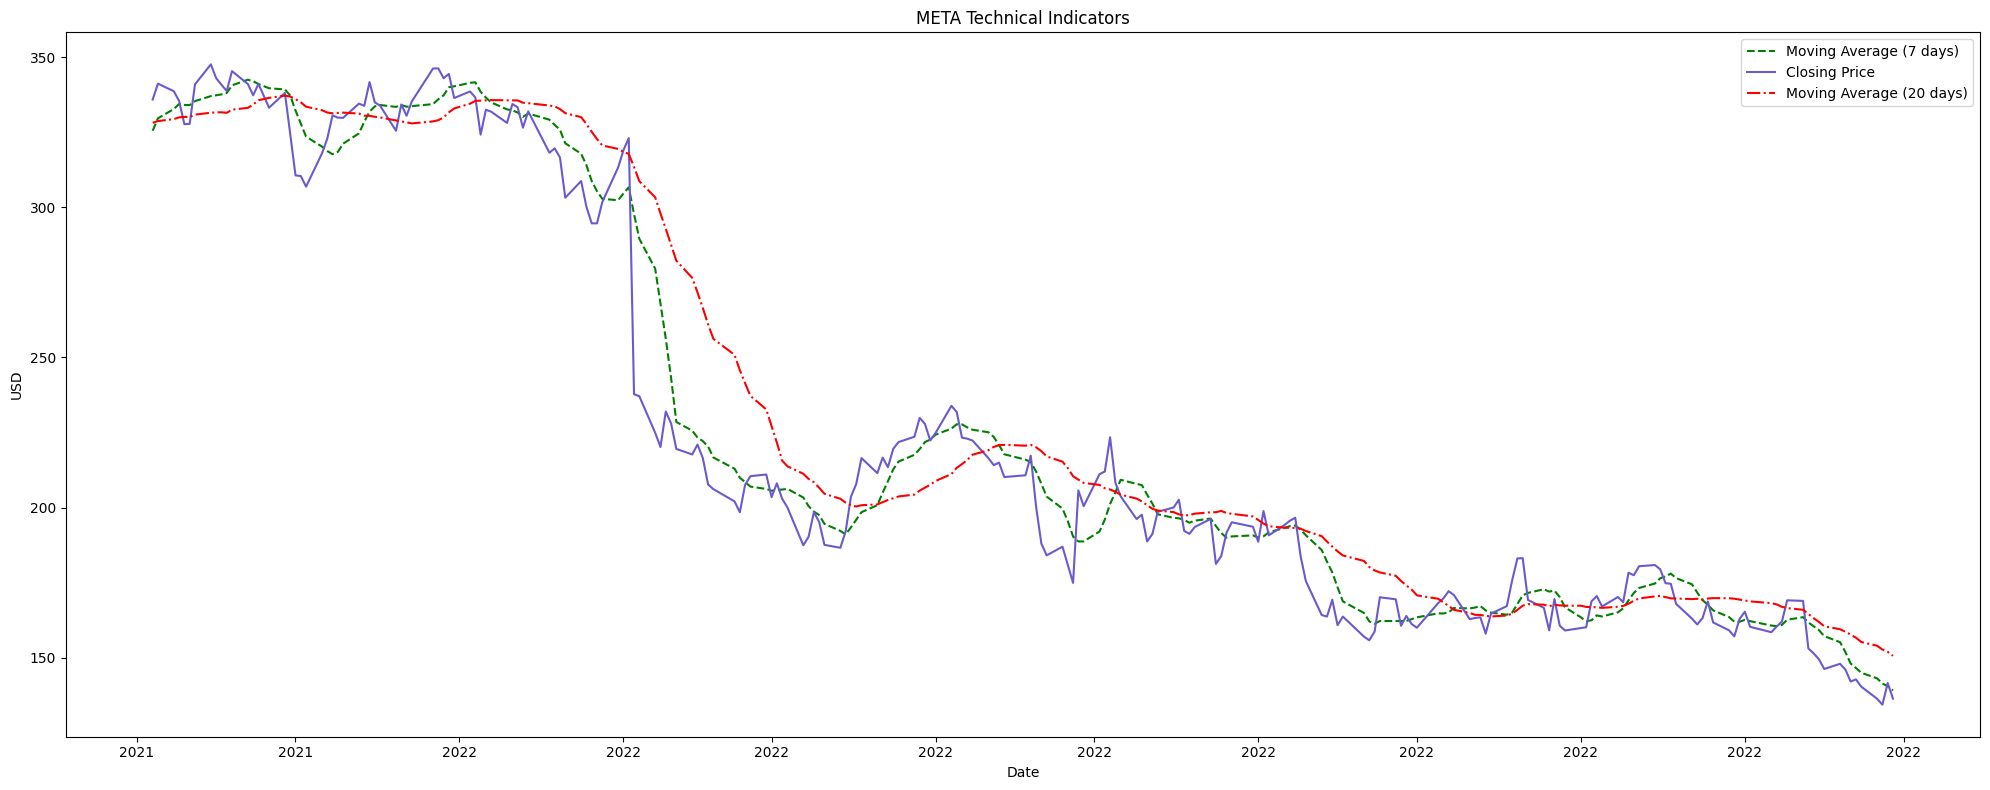

(227, 13)
X_train shape (190, 4, 13)
y_train shape (190, 1)
yc_train shape (190, 4, 1)
X_test shape (33, 4, 13)
y_test shape (33, 1)
yc_test shape (33, 4, 1)
Input dimension 4
Feature dimension 13
Output dimension 1
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 4, 64)             19968     
                                                                 
 flatten_19 (Flatten)        (None, 256)               0         
                                                                 
 dense_63 (Dense)            (None, 1)                 257       
                                                                 
Total params: 20,225
Trainable params: 20,225
Non-trainable params: 0
_________________________________________________________________
None
6/6 [==============================] - 1s 8ms/step - loss: 0.0869 - root_mean_squared_error:

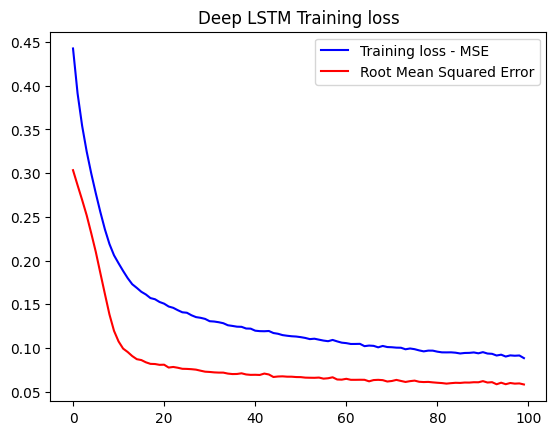

2/2 [==============================] - 0s 11ms/step
the test RMSE for Stock META is 12.45486484260395


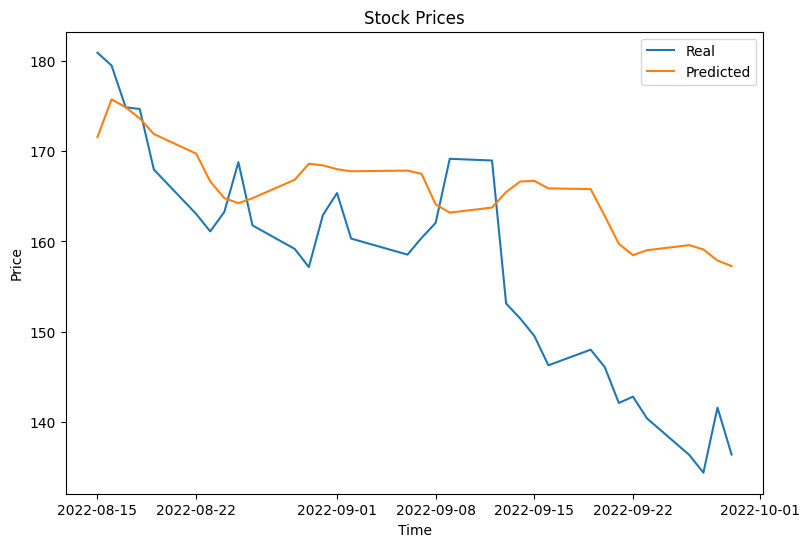

In [ ]:
X, y, date = clean_data(all_tweets, all_stocks, 'META')
X_train, y_train, yc_train, X_test, y_test, y_scaler, input_dim, feature_size, output_dim = data_preprocess(X, y, days_to_consider, days_to_predict)

#
shallow_model = make_LSTM_model(input_dim, feature_size, output_dim)
print(shallow_model.summary())

#Defining Optimizers
optimizeAdam=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
optimizeRMS=tf.keras.optimizers.RMSprop()
optimizeSGD =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
optimizeSGD1 =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

#Evaluation metric
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
      return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# Compile & Fit
#single_step_model.compile(optimizer=optimizeAdam, loss='mae',metrics=["mae"])
shallow_model.compile(optimizer=optimizeAdam, loss=root_mean_squared_error,metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = shallow_model.fit(x = X_train, y = y_train ,epochs=100, verbose = 0)
# evaluate the model on the training data
loss, accuracy = shallow_model.evaluate(X_train, y_train)
print('Training loss:', loss)

#Plotting the training loss curve against the epochs
def plot_train_history(history, title):
  loss = history.history['loss']
  rmse = history.history['root_mean_squared_error']
  #mse = history.history['mse']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss - MSE')
  plt.plot(epochs, rmse, 'r', label='Root Mean Squared Error')
  #plt.plot(epochs, mse, 'r', label='Mean Squared Error')
  plt.title(title)
  plt.legend()

  plt.show()

plot_train_history(history, 'Deep LSTM Training loss')

#Testing and making Predictions
y_test_predicted = shallow_model.predict(X_test)
real_y = y_scaler.inverse_transform(y_test)
predicted_y = y_scaler.inverse_transform(y_test_predicted)

#Printing the test RMSE
Test_RMSE = np.sqrt(mean_squared_error(real_y, predicted_y))
print("the test RMSE for Stock META is",Test_RMSE)

#Plot the predictions
fig, ax = plt.subplots(figsize=(9,6))

# Plot the two arrays as lines on the same plot
ax.plot(date[X_train.shape[0] + days_to_consider :], real_y, label='Real')
ax.plot(date[X_train.shape[0] + days_to_consider :], predicted_y, label='Predicted')

# Set the x-axis and y-axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Price')

# Add a title to the plot
ax.set_title('Stock Prices')

# Add a legend to the plot
ax.legend()

# Show the plot
plt.show()


# Stock Prediction for 'AMD'

## Deep LSTM

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.2 µs


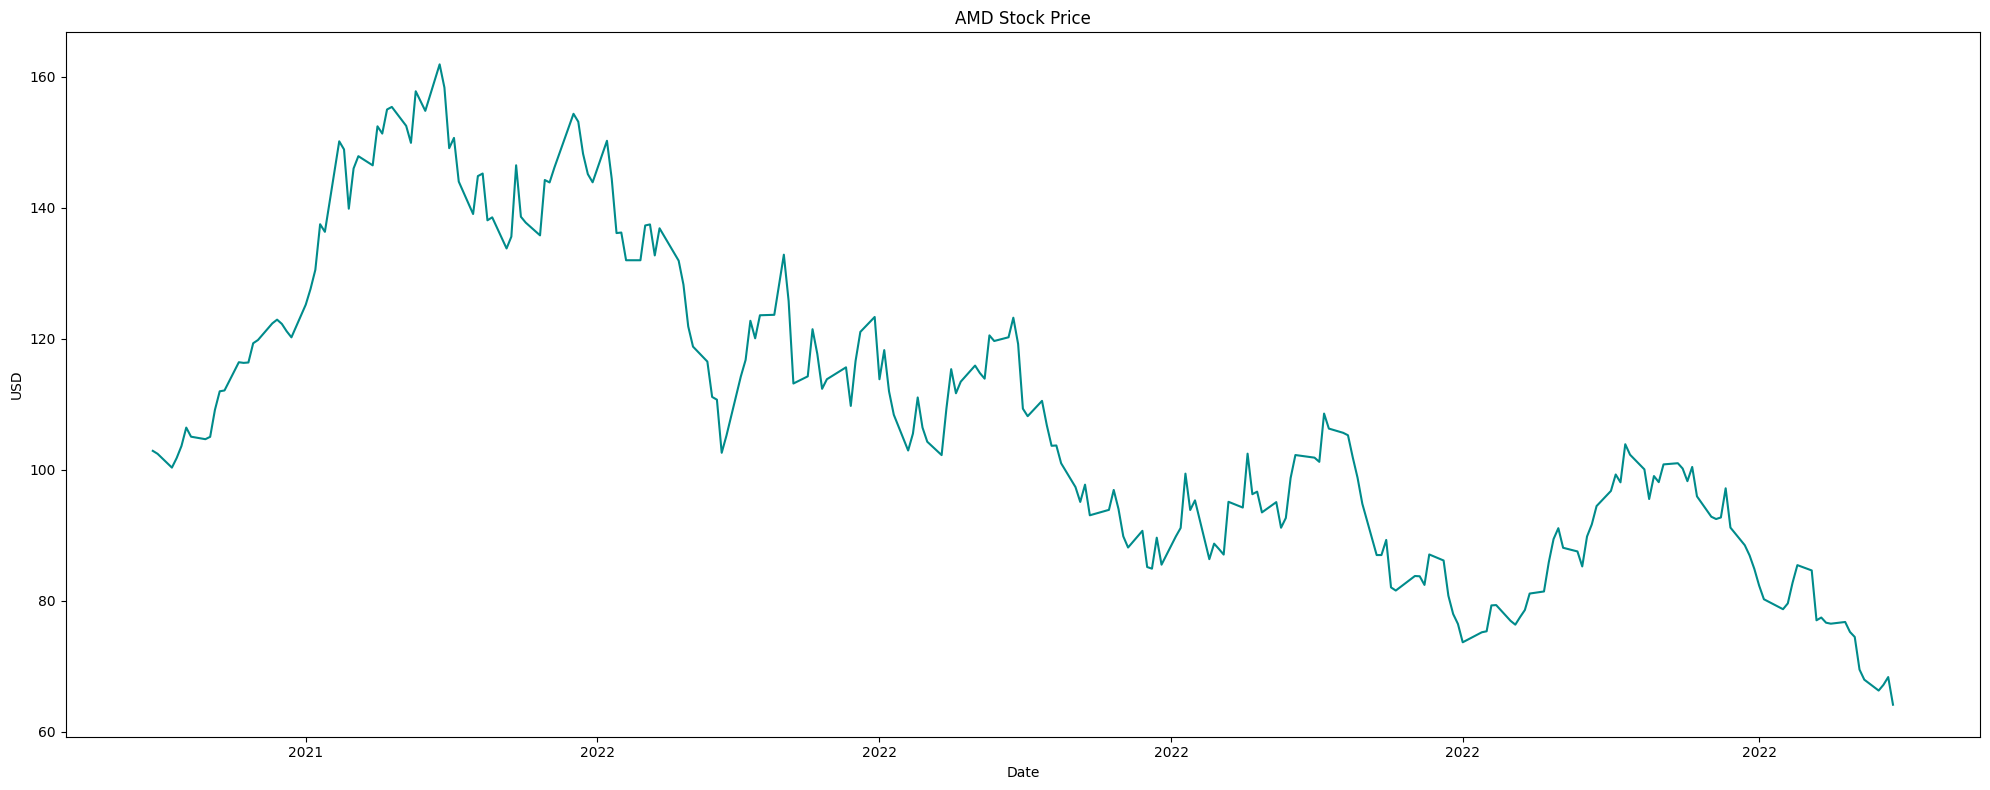

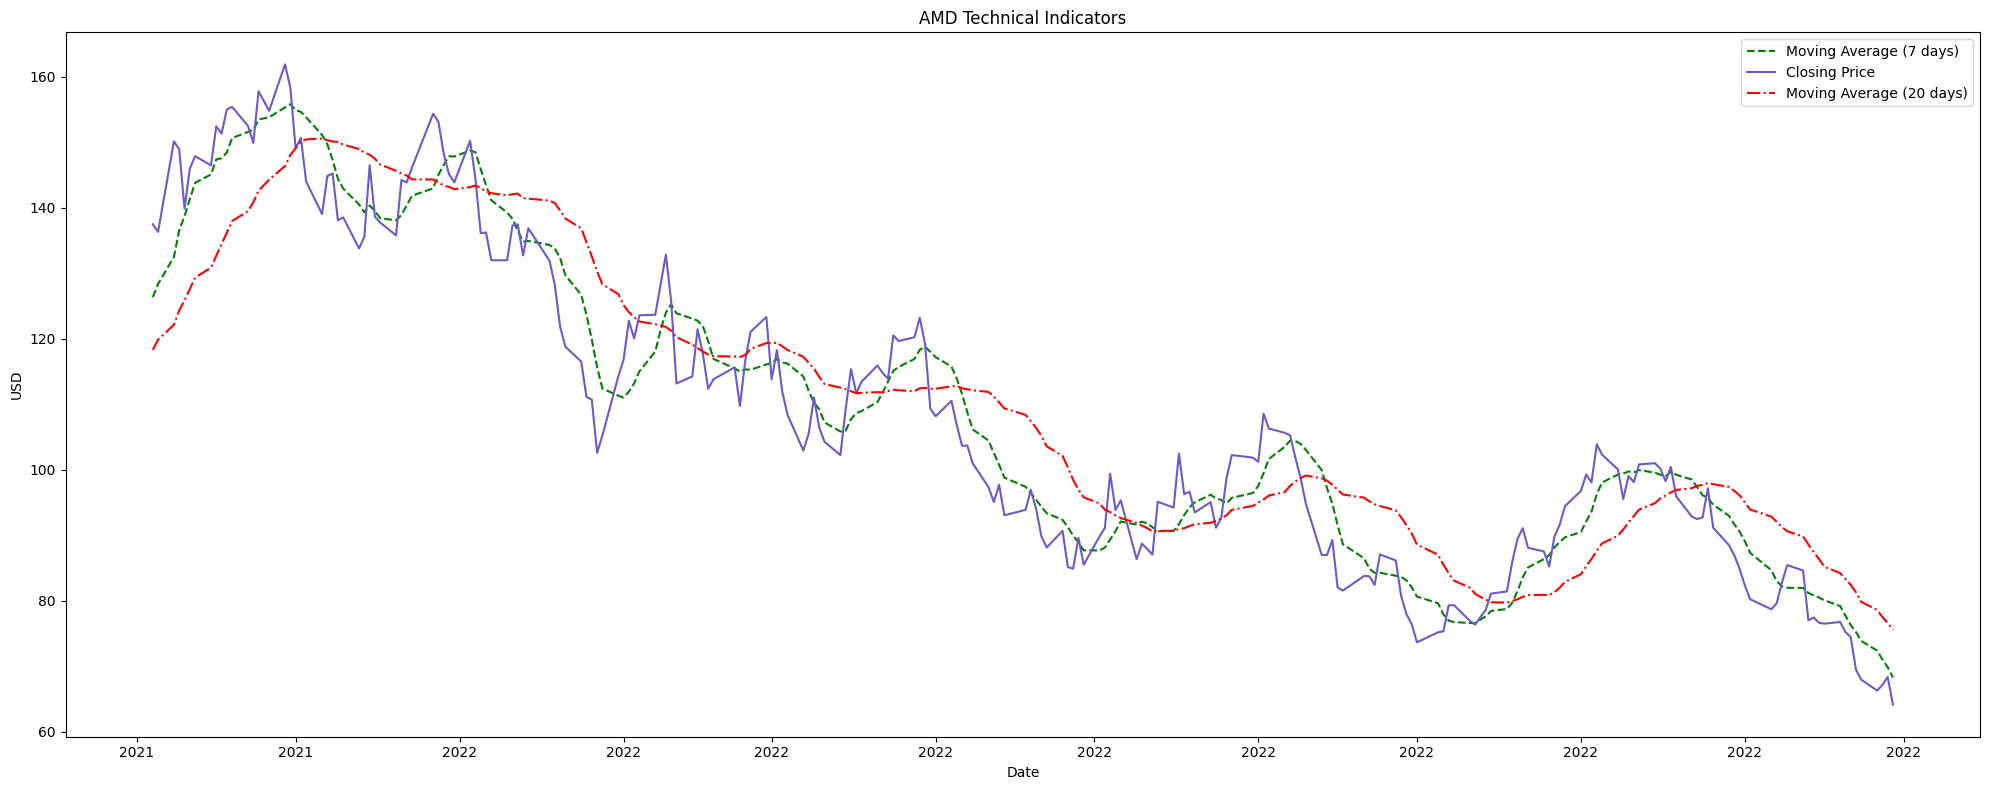

(227, 13)
X_train shape (190, 4, 13)
y_train shape (190, 1)
yc_train shape (190, 4, 1)
X_test shape (33, 4, 13)
y_test shape (33, 1)
yc_test shape (33, 4, 1)
Input dimension 4
Feature dimension 13
Output dimension 1
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 4, 512)            1077248   
                                                                 
 lstm_32 (LSTM)              (None, 4, 256)            787456    
                                                                 
 dense_64 (Dense)            (None, 4, 128)            32896     
                                                                 
 dense_65 (Dense)            (None, 4, 64)             8256      
                                                                 
 dense_66 (Dense)            (None, 4, 32)             2080      
                                   

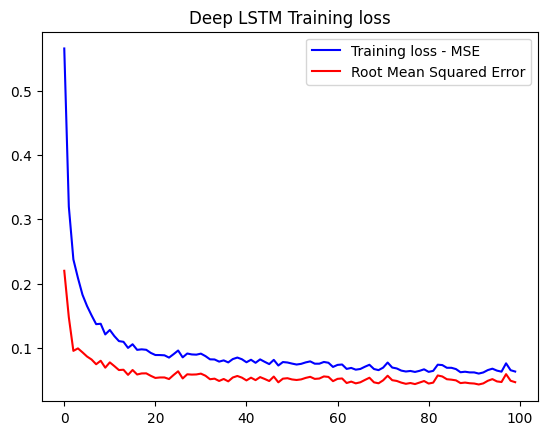

2/2 [==============================] - 1s 17ms/step
the test RMSE for Stock AMD is 4.392929985566937


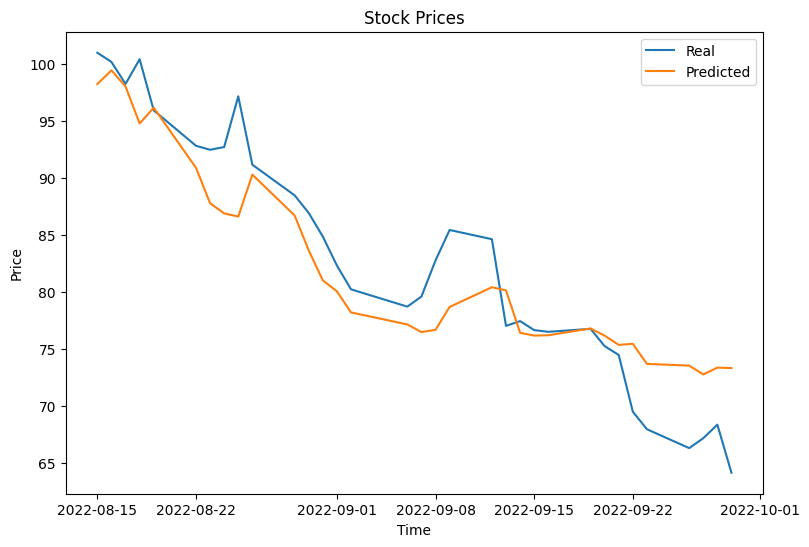

In [ ]:
X, y, date = clean_data(all_tweets, all_stocks, 'AMD')
X_train, y_train, yc_train, X_test, y_test, y_scaler, input_dim, feature_size, output_dim = data_preprocess(X, y, days_to_consider, days_to_predict)

#
deep_model = make_deep_LSTM_model(input_dim, feature_size, output_dim)
print(deep_model.summary())

#Defining Optimizers
optimizeAdam=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
optimizeRMS=tf.keras.optimizers.RMSprop()
optimizeSGD =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
optimizeSGD1 =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

#Evaluation metric
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
      return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# Compile & Fit
#single_step_model.compile(optimizer=optimizeAdam, loss='mae',metrics=["mae"])
deep_model.compile(optimizer=optimizeAdam, loss=root_mean_squared_error,metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = deep_model.fit(x = X_train, y = y_train ,epochs=100, verbose = 0)
# evaluate the model on the training data
loss, accuracy = deep_model.evaluate(X_train, y_train)
print('Training loss:', loss)

#Plotting the training loss curve against the epochs
def plot_train_history(history, title):
  loss = history.history['loss']
  rmse = history.history['root_mean_squared_error']
  #mse = history.history['mse']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss - MSE')
  plt.plot(epochs, rmse, 'r', label='Root Mean Squared Error')
  #plt.plot(epochs, mse, 'r', label='Mean Squared Error')
  plt.title(title)
  plt.legend()

  plt.show()

plot_train_history(history, 'Deep LSTM Training loss')

#Testing and making Predictions
y_test_predicted = deep_model.predict(X_test)
real_y = y_scaler.inverse_transform(y_test)
predicted_y = y_scaler.inverse_transform(y_test_predicted)

#Printing the test RMSE
Test_RMSE = np.sqrt(mean_squared_error(real_y, predicted_y))
print("the test RMSE for Stock AMD is",Test_RMSE)

#Plot the predictions
fig, ax = plt.subplots(figsize=(9,6))

# Plot the two arrays as lines on the same plot
ax.plot(date[X_train.shape[0] + days_to_consider :], real_y, label='Real')
ax.plot(date[X_train.shape[0] + days_to_consider :], predicted_y, label='Predicted')

# Set the x-axis and y-axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Price')

# Add a title to the plot
ax.set_title('Stock Prices')

# Add a legend to the plot
ax.legend()

# Show the plot
plt.show()


## Shallow LSTM

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.58 µs


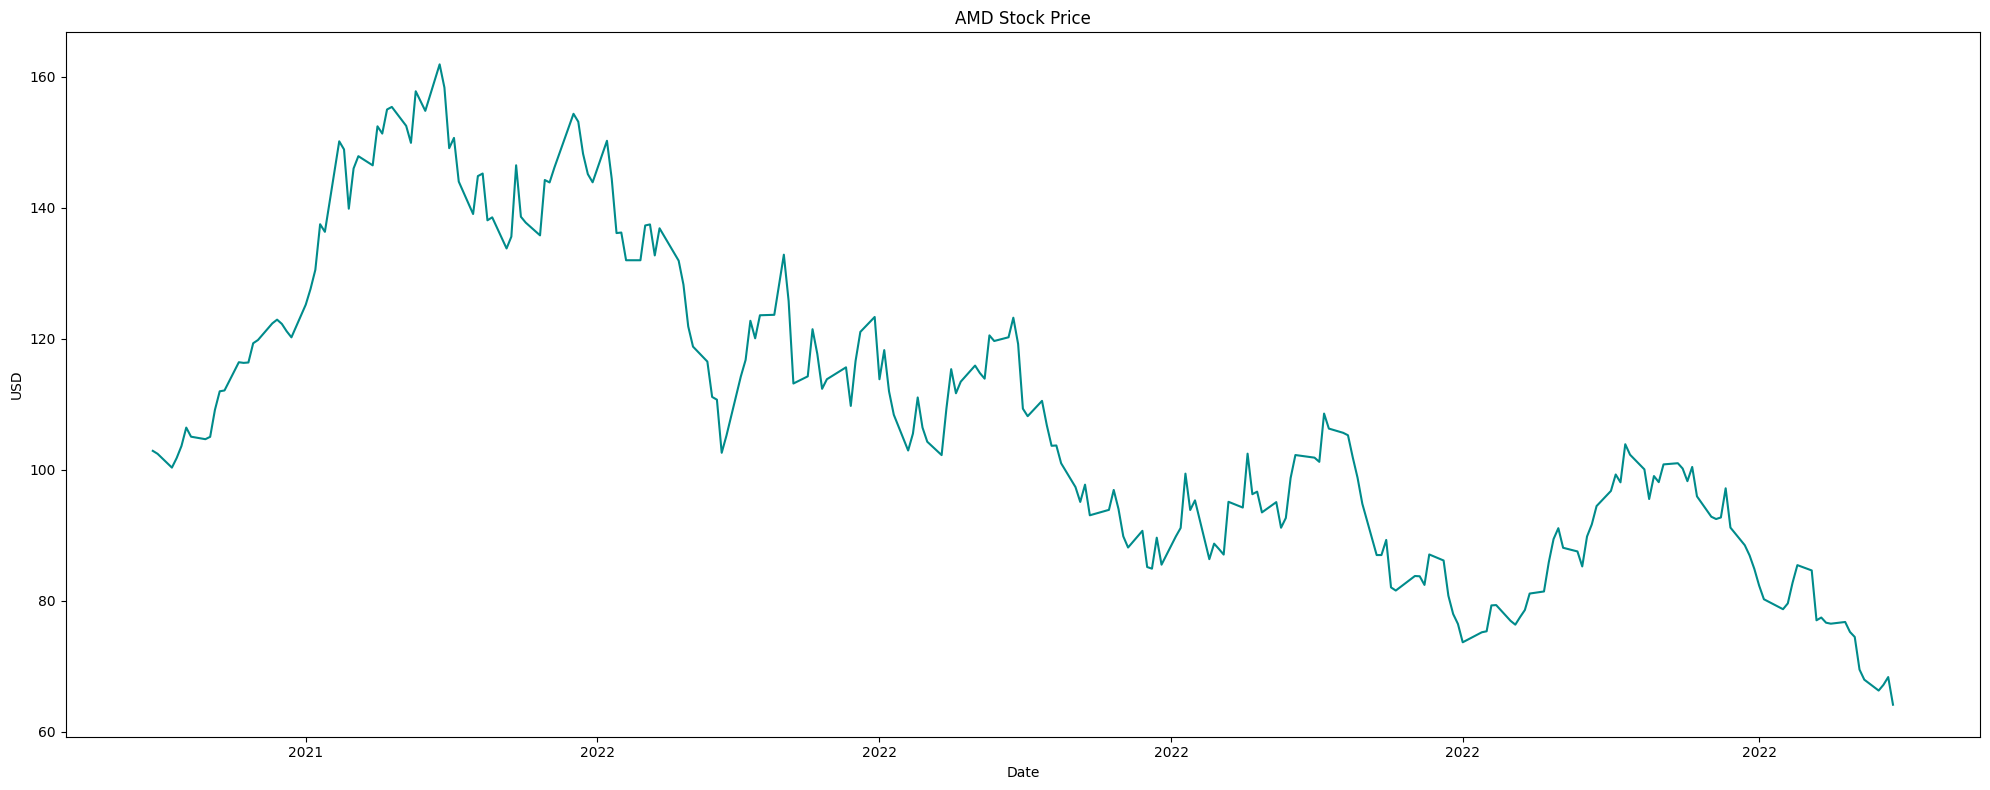

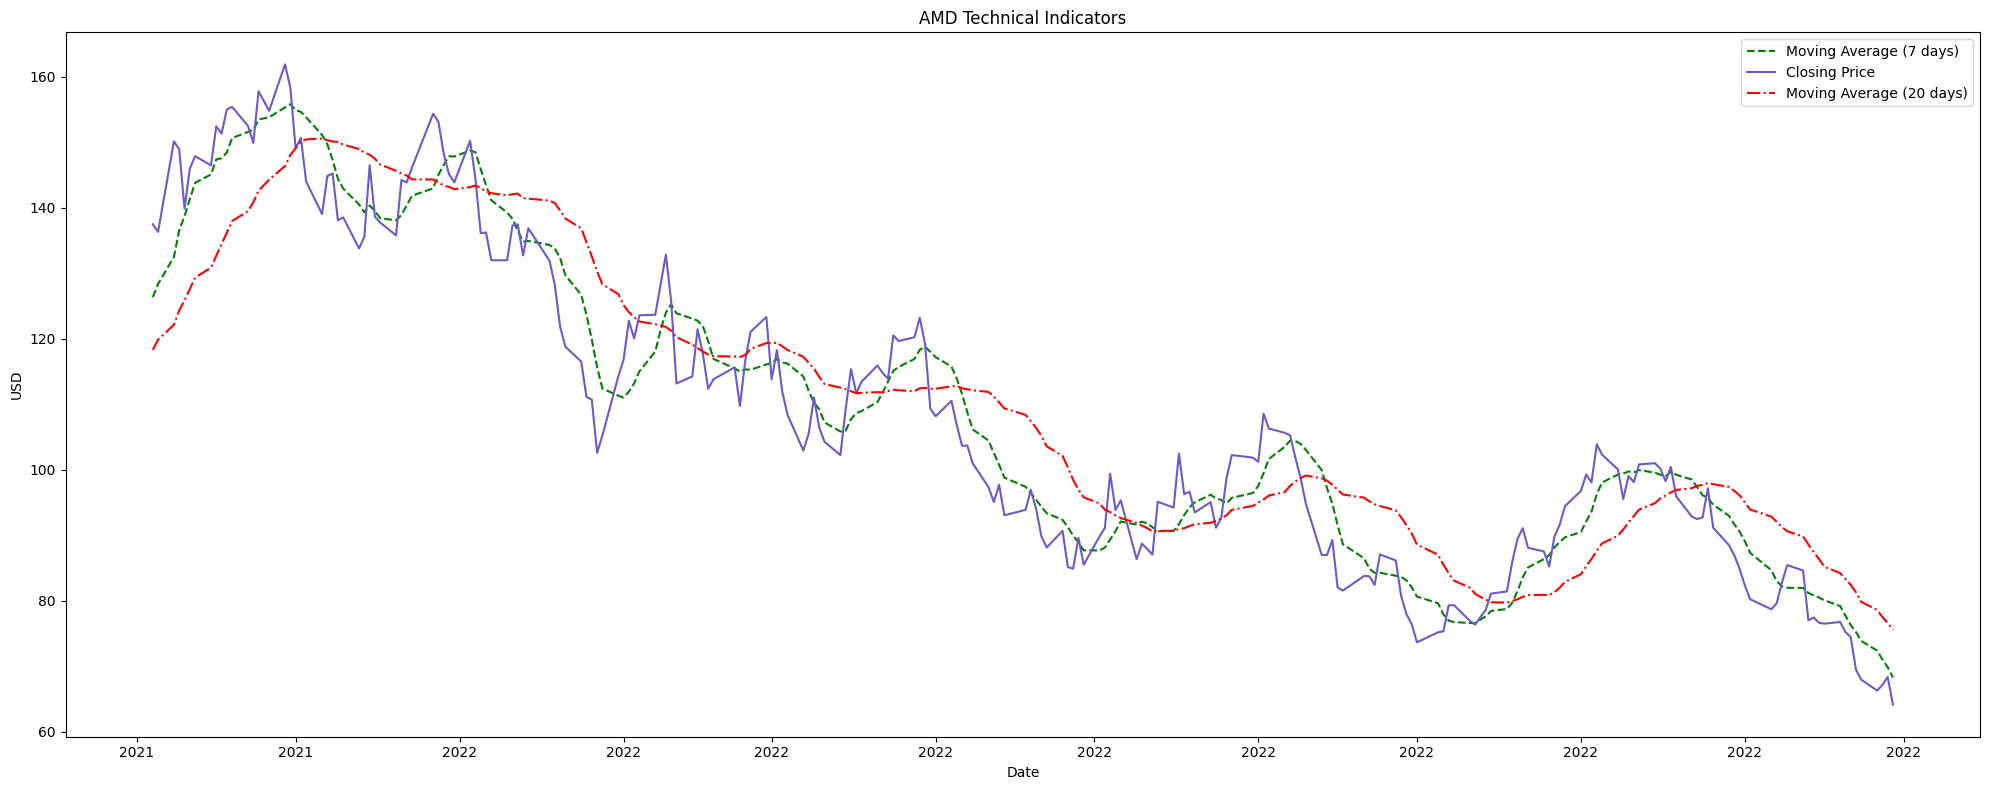

(227, 13)
X_train shape (190, 4, 13)
y_train shape (190, 1)
yc_train shape (190, 4, 1)
X_test shape (33, 4, 13)
y_test shape (33, 1)
yc_test shape (33, 4, 1)
Input dimension 4
Feature dimension 13
Output dimension 1
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 4, 64)             19968     
                                                                 
 flatten_21 (Flatten)        (None, 256)               0         
                                                                 
 dense_69 (Dense)            (None, 1)                 257       
                                                                 
Total params: 20,225
Trainable params: 20,225
Non-trainable params: 0
_________________________________________________________________
None
6/6 [==============================] - 0s 5ms/step - loss: 0.0819 - root_mean_squared_error:

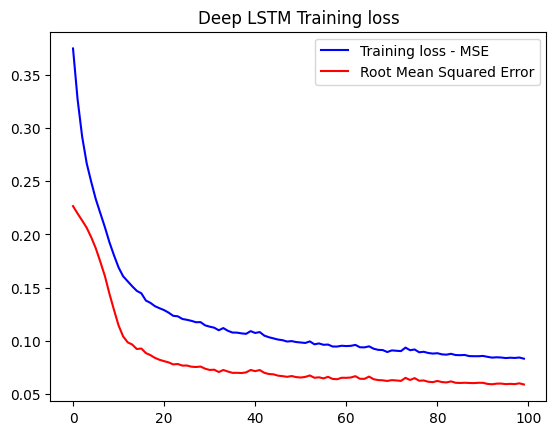

2/2 [==============================] - 0s 11ms/step
the test RMSE for Stock AMD is 5.0967966151734


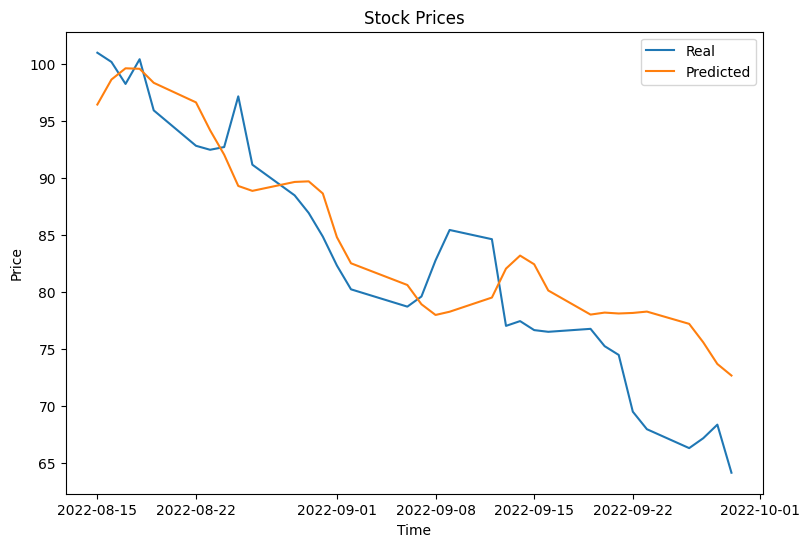

In [ ]:
X, y, date = clean_data(all_tweets, all_stocks, 'AMD')
X_train, y_train, yc_train, X_test, y_test, y_scaler, input_dim, feature_size, output_dim = data_preprocess(X, y, days_to_consider, days_to_predict)

#
shallow_model = make_LSTM_model(input_dim, feature_size, output_dim)
print(shallow_model.summary())

#Defining Optimizers
optimizeAdam=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
optimizeRMS=tf.keras.optimizers.RMSprop()
optimizeSGD =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
optimizeSGD1 =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

#Evaluation metric
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
      return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# Compile & Fit
#single_step_model.compile(optimizer=optimizeAdam, loss='mae',metrics=["mae"])
shallow_model.compile(optimizer=optimizeAdam, loss=root_mean_squared_error,metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = shallow_model.fit(x = X_train, y = y_train ,epochs=100, verbose = 0)
# evaluate the model on the training data
loss, accuracy = shallow_model.evaluate(X_train, y_train)
print('Training loss:', loss)

#Plotting the training loss curve against the epochs
def plot_train_history(history, title):
  loss = history.history['loss']
  rmse = history.history['root_mean_squared_error']
  #mse = history.history['mse']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss - MSE')
  plt.plot(epochs, rmse, 'r', label='Root Mean Squared Error')
  #plt.plot(epochs, mse, 'r', label='Mean Squared Error')
  plt.title(title)
  plt.legend()

  plt.show()

plot_train_history(history, 'Deep LSTM Training loss')

#Testing and making Predictions
y_test_predicted = shallow_model.predict(X_test)
real_y = y_scaler.inverse_transform(y_test)
predicted_y = y_scaler.inverse_transform(y_test_predicted)

#Printing the test RMSE
Test_RMSE = np.sqrt(mean_squared_error(real_y, predicted_y))
print("the test RMSE for Stock AMD is",Test_RMSE)

#Plot the predictions
fig, ax = plt.subplots(figsize=(9,6))

# Plot the two arrays as lines on the same plot
ax.plot(date[X_train.shape[0] + days_to_consider :], real_y, label='Real')
ax.plot(date[X_train.shape[0] + days_to_consider :], predicted_y, label='Predicted')

# Set the x-axis and y-axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Price')

# Add a title to the plot
ax.set_title('Stock Prices')

# Add a legend to the plot
ax.legend()

# Show the plot
plt.show()


# Stock Prediction for 'NFLX'

## Deep LSTM

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs


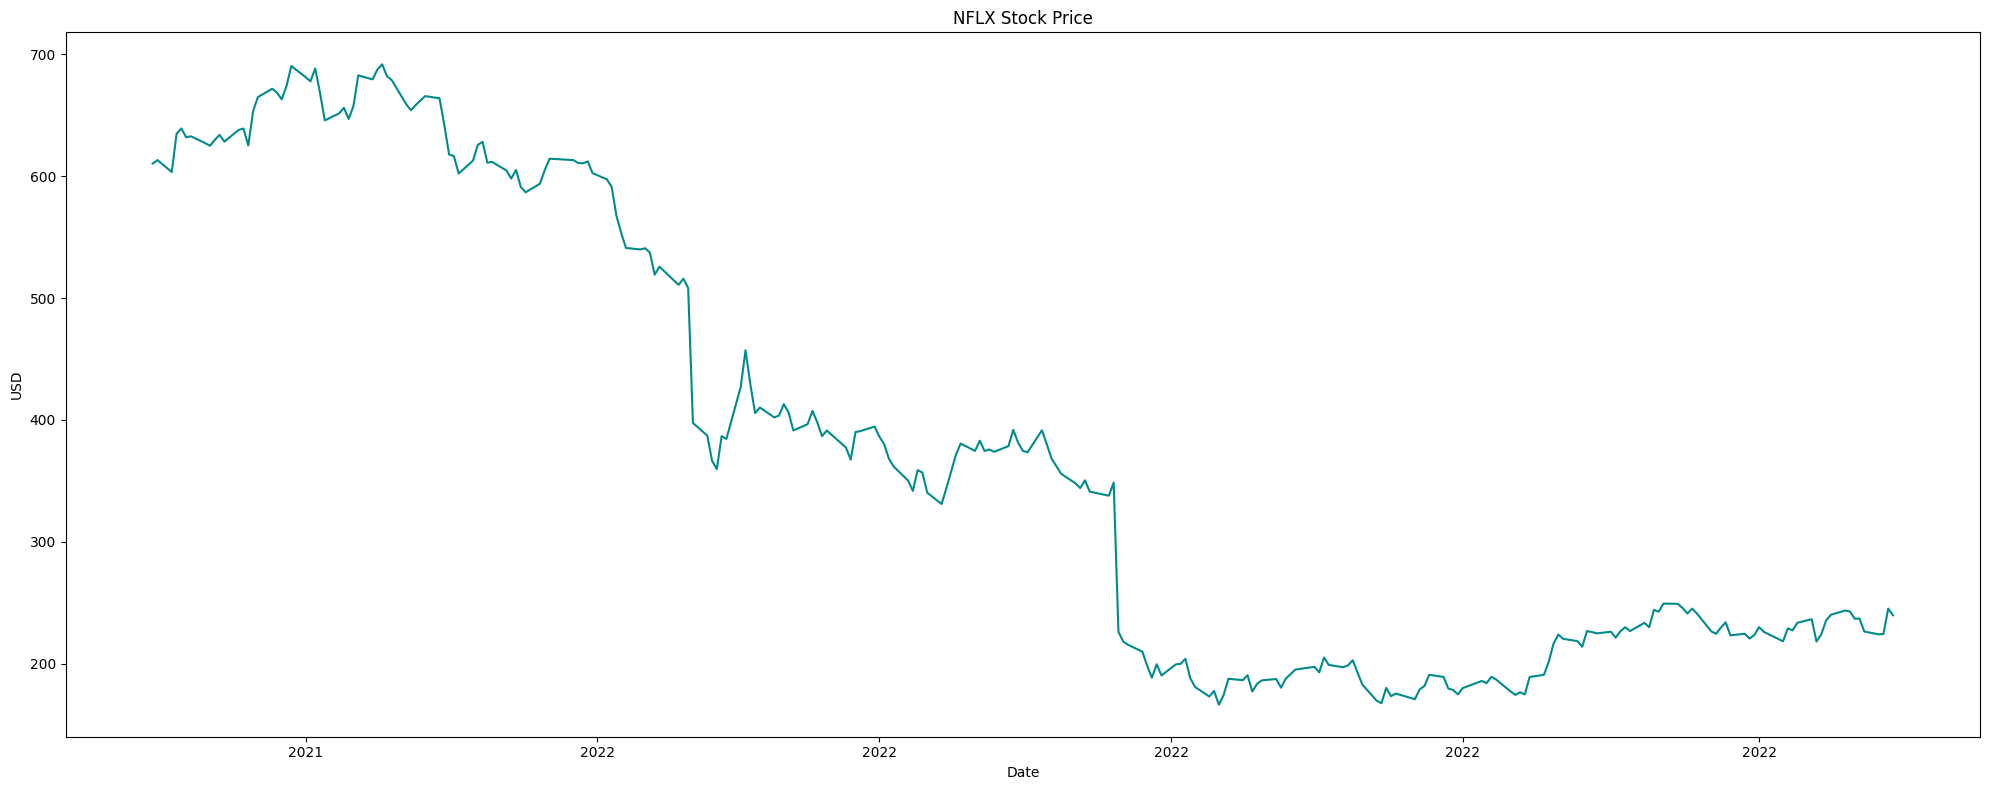

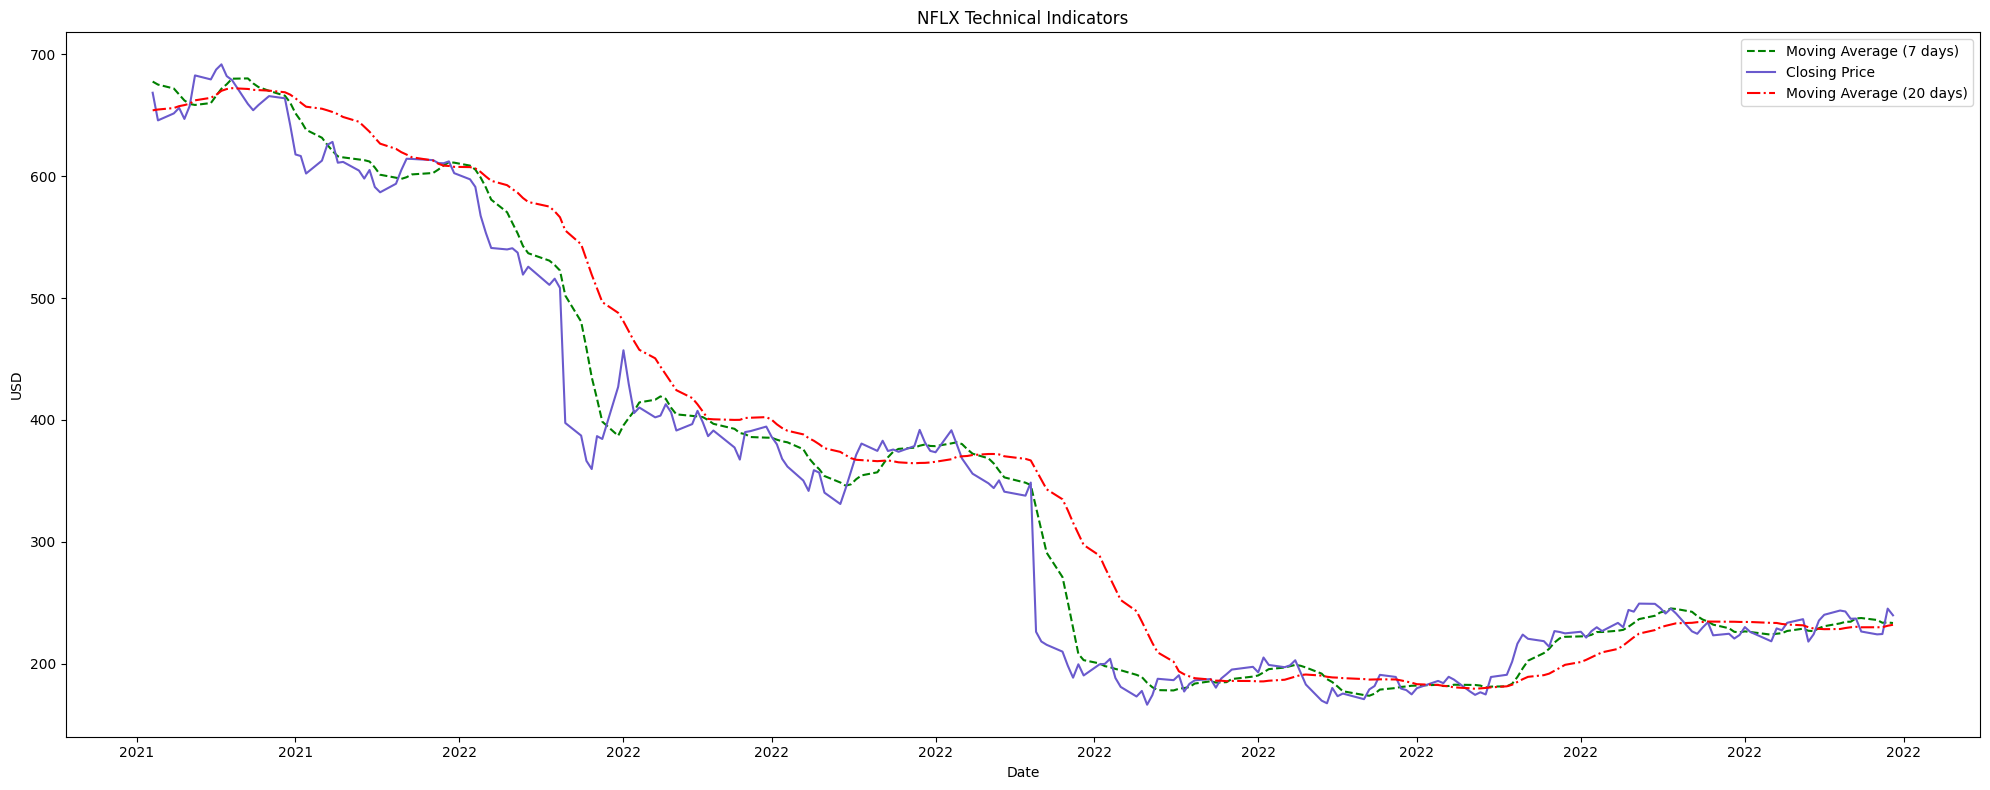

(227, 13)
X_train shape (190, 4, 13)
y_train shape (190, 1)
yc_train shape (190, 4, 1)
X_test shape (33, 4, 13)
y_test shape (33, 1)
yc_test shape (33, 4, 1)
Input dimension 4
Feature dimension 13
Output dimension 1


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 512)            1077248   
                                                                 
 lstm_1 (LSTM)               (None, 4, 256)            787456    
                                                                 
 dense (Dense)               (None, 4, 128)            32896     
                                                                 
 dense_1 (Dense)             (None, 4, 64)             8256      
                                                                 
 dense_2 (Dense)             (None, 4, 32)             2080      
                                                                 
 dense_3 (Dense)             (None, 4, 16)             528       
                                                                 
 flatten (Flatten)           (None, 64)                0

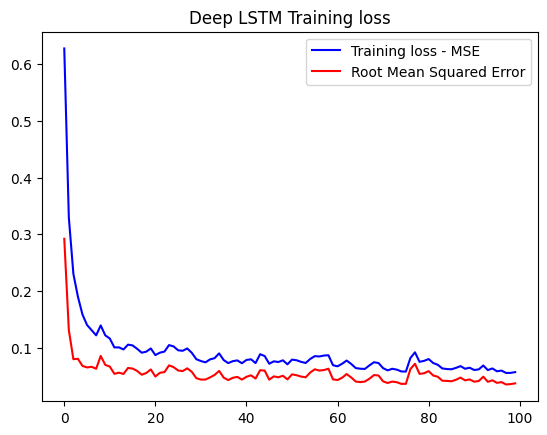

2/2 [==============================] - 1s 12ms/step
the test RMSE for Stock NFLX is 13.167532947132424


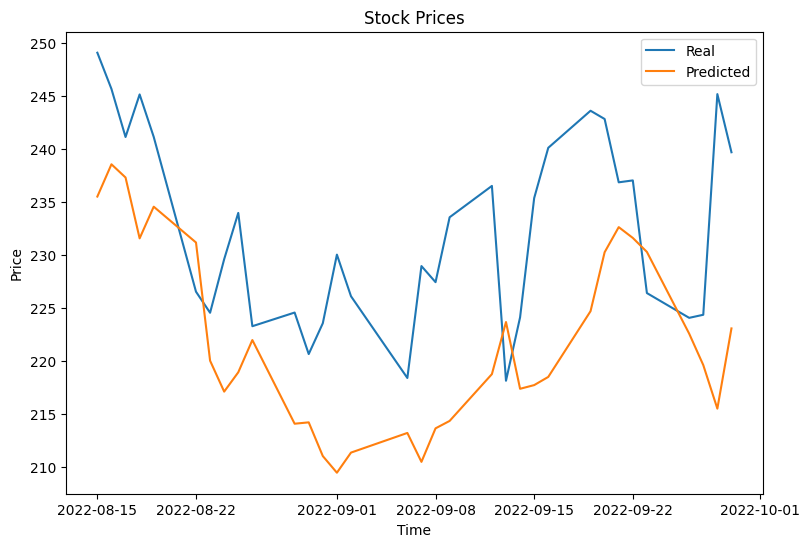

In [ ]:
X, y, date = clean_data(all_tweets, all_stocks, 'NFLX')
X_train, y_train, yc_train, X_test, y_test, y_scaler, input_dim, feature_size, output_dim = data_preprocess(X, y, days_to_consider, days_to_predict)

#
deep_model = make_deep_LSTM_model(input_dim, feature_size, output_dim)
print(deep_model.summary())

#Defining Optimizers
optimizeAdam=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
optimizeRMS=tf.keras.optimizers.RMSprop()
optimizeSGD =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
optimizeSGD1 =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

#Evaluation metric
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
      return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# Compile & Fit
#single_step_model.compile(optimizer=optimizeAdam, loss='mae',metrics=["mae"])
deep_model.compile(optimizer=optimizeAdam, loss=root_mean_squared_error,metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = deep_model.fit(x = X_train, y = y_train ,epochs=100, verbose = 0)
# evaluate the model on the training data
loss, accuracy = deep_model.evaluate(X_train, y_train)
print('Training loss:', loss)

#Plotting the training loss curve against the epochs
def plot_train_history(history, title):
  loss = history.history['loss']
  rmse = history.history['root_mean_squared_error']
  #mse = history.history['mse']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss - MSE')
  plt.plot(epochs, rmse, 'r', label='Root Mean Squared Error')
  #plt.plot(epochs, mse, 'r', label='Mean Squared Error')
  plt.title(title)
  plt.legend()

  plt.show()

plot_train_history(history, 'Deep LSTM Training loss')

#Testing and making Predictions
y_test_predicted = deep_model.predict(X_test)
real_y = y_scaler.inverse_transform(y_test)
predicted_y = y_scaler.inverse_transform(y_test_predicted)

#Printing the test RMSE
Test_RMSE = np.sqrt(mean_squared_error(real_y, predicted_y))
print("the test RMSE for Stock NFLX is",Test_RMSE)

#Plot the predictions
fig, ax = plt.subplots(figsize=(9,6))

# Plot the two arrays as lines on the same plot
ax.plot(date[X_train.shape[0] + days_to_consider :], real_y, label='Real')
ax.plot(date[X_train.shape[0] + days_to_consider :], predicted_y, label='Predicted')

# Set the x-axis and y-axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Price')

# Add a title to the plot
ax.set_title('Stock Prices')

# Add a legend to the plot
ax.legend()

# Show the plot
plt.show()


## Shallow LSTM

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.2 µs


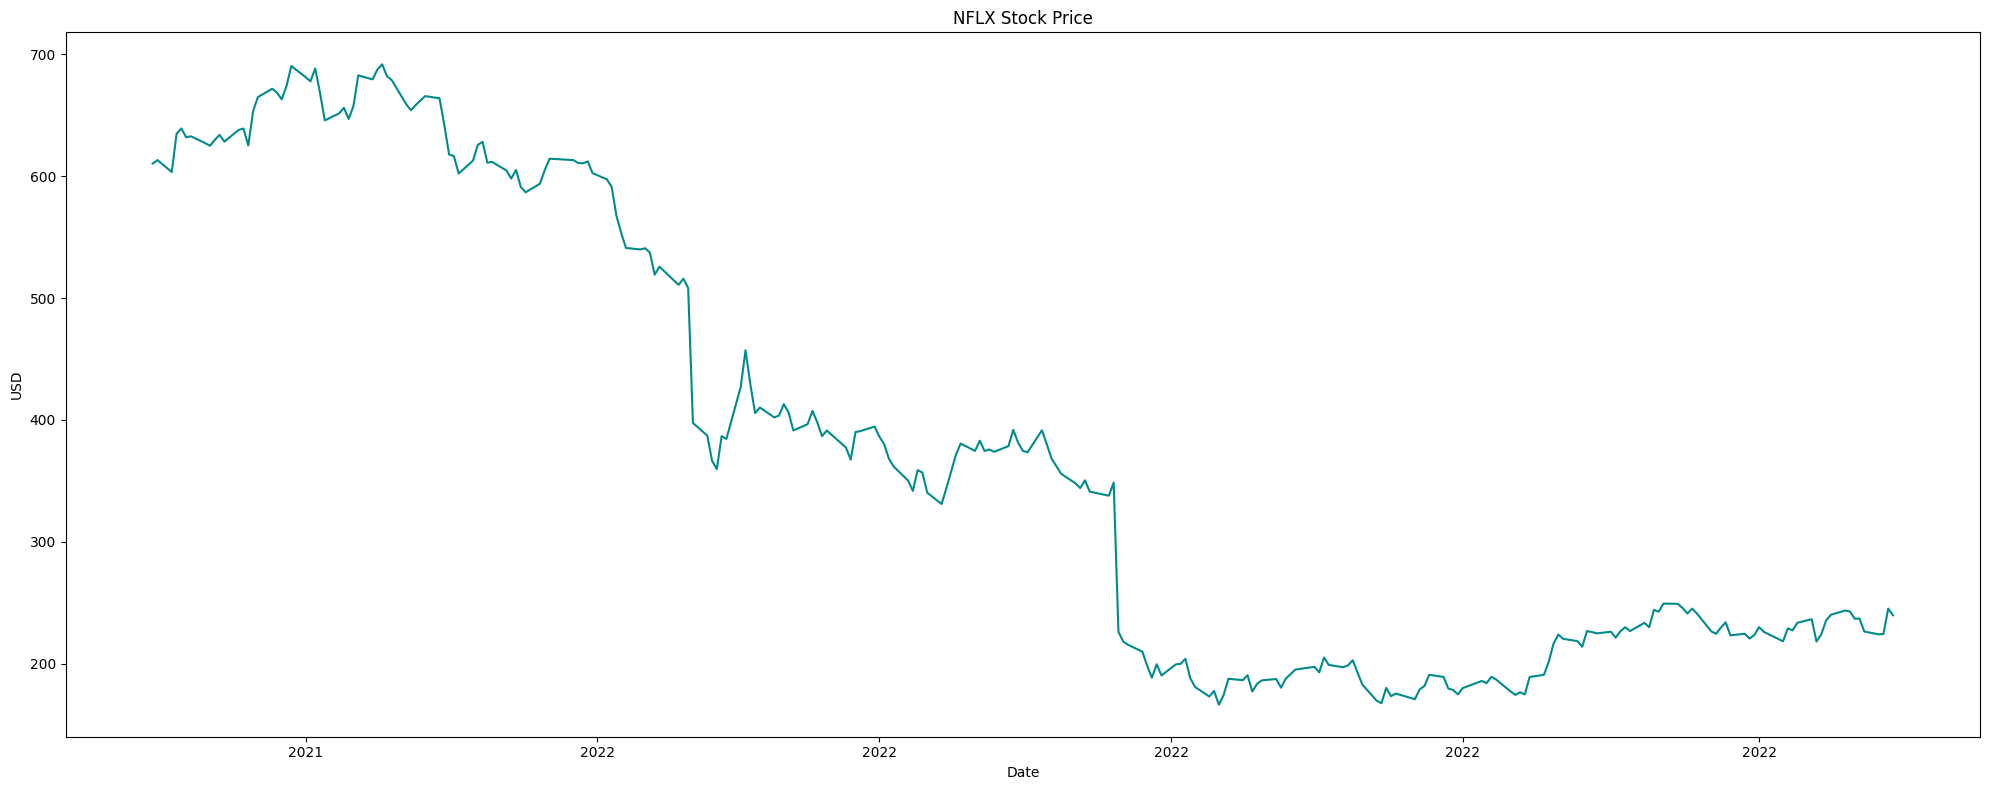

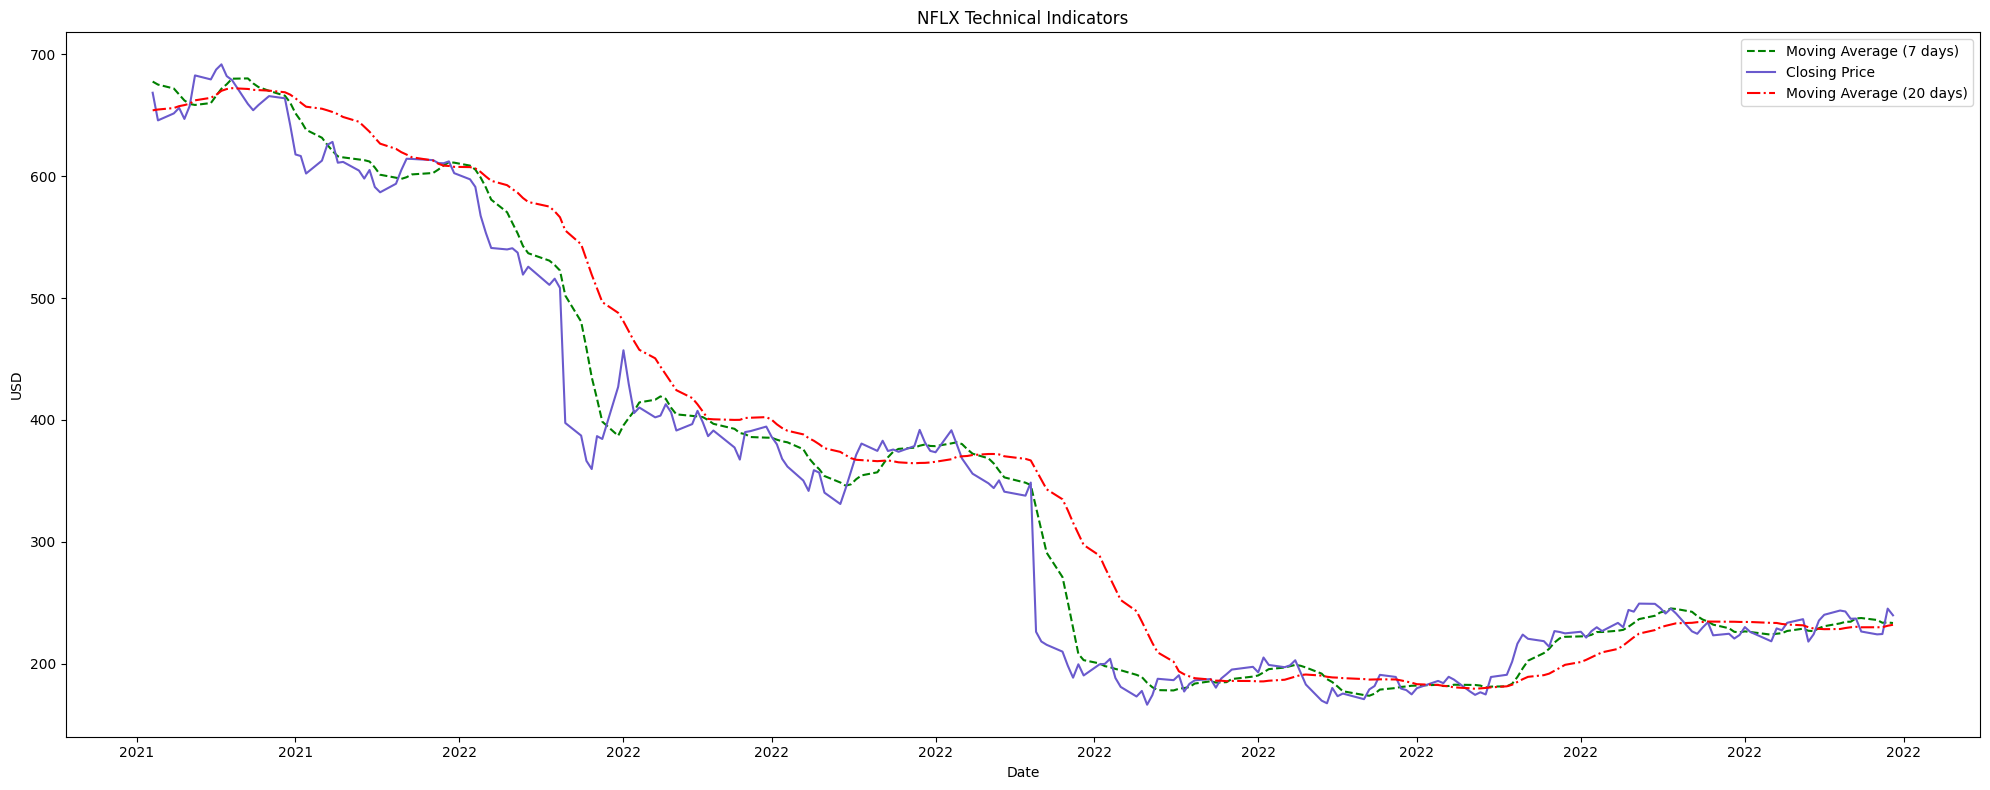

(227, 13)
X_train shape (190, 4, 13)
y_train shape (190, 1)
yc_train shape (190, 4, 1)
X_test shape (33, 4, 13)
y_test shape (33, 1)
yc_test shape (33, 4, 1)
Input dimension 4
Feature dimension 13
Output dimension 1
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 4, 64)             19968     
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 20,225
Trainable params: 20,225
Non-trainable params: 0
_________________________________________________________________
None
6/6 [==============================] - 0s 5ms/step - loss: 0.0827 - root_mean_squared_error: 

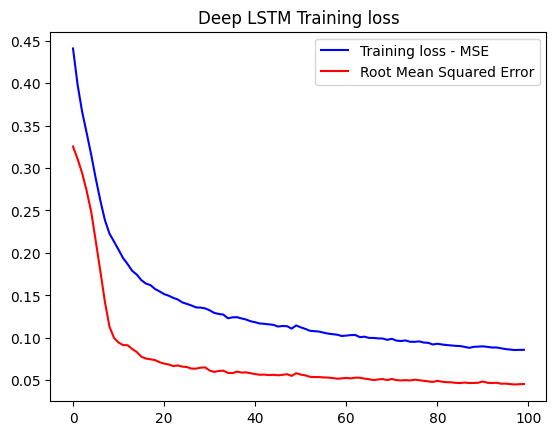

2/2 [==============================] - 0s 10ms/step
the test RMSE for Stock NFLX is 11.328169766815526


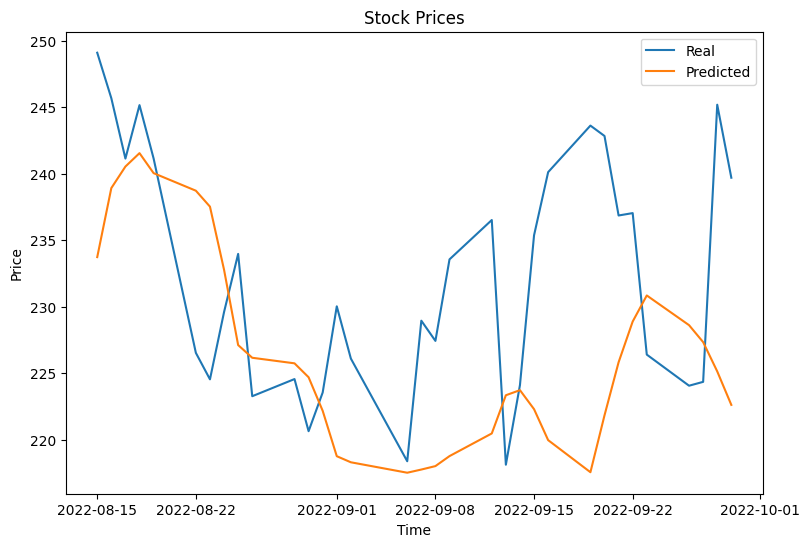

In [ ]:
X, y, date = clean_data(all_tweets, all_stocks, 'NFLX')
X_train, y_train, yc_train, X_test, y_test, y_scaler, input_dim, feature_size, output_dim = data_preprocess(X, y, days_to_consider, days_to_predict)

#
shallow_model = make_LSTM_model(input_dim, feature_size, output_dim)
print(shallow_model.summary())

#Defining Optimizers
optimizeAdam=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
optimizeRMS=tf.keras.optimizers.RMSprop()
optimizeSGD =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
optimizeSGD1 =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

#Evaluation metric
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
      return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# Compile & Fit
#single_step_model.compile(optimizer=optimizeAdam, loss='mae',metrics=["mae"])
shallow_model.compile(optimizer=optimizeAdam, loss=root_mean_squared_error,metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = shallow_model.fit(x = X_train, y = y_train ,epochs=100, verbose = 0)
# evaluate the model on the training data
loss, accuracy = shallow_model.evaluate(X_train, y_train)
print('Training loss:', loss)

#Plotting the training loss curve against the epochs
def plot_train_history(history, title):
  loss = history.history['loss']
  rmse = history.history['root_mean_squared_error']
  #mse = history.history['mse']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss - MSE')
  plt.plot(epochs, rmse, 'r', label='Root Mean Squared Error')
  #plt.plot(epochs, mse, 'r', label='Mean Squared Error')
  plt.title(title)
  plt.legend()

  plt.show()

plot_train_history(history, 'Deep LSTM Training loss')

#Testing and making Predictions
y_test_predicted = shallow_model.predict(X_test)
real_y = y_scaler.inverse_transform(y_test)
predicted_y = y_scaler.inverse_transform(y_test_predicted)

#Printing the test RMSE
Test_RMSE = np.sqrt(mean_squared_error(real_y, predicted_y))
print("the test RMSE for Stock NFLX is",Test_RMSE)

#Plot the predictions
fig, ax = plt.subplots(figsize=(9,6))

# Plot the two arrays as lines on the same plot
ax.plot(date[X_train.shape[0] + days_to_consider :], real_y, label='Real')
ax.plot(date[X_train.shape[0] + days_to_consider :], predicted_y, label='Predicted')

# Set the x-axis and y-axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Price')

# Add a title to the plot
ax.set_title('Stock Prices')

# Add a legend to the plot
ax.legend()

# Show the plot
plt.show()
